# The Lending Club: Finding an Optimal Investment Portfolio

<div style="line-height: 1.6;">
IFTE0002 Coursework, Group F

Iman Zafar, Rickey Chen, Ariq Zidane, Aadhira Chavan, Gabriella Larissa, Owen Babbington-Ellis, Kane Basu
</div>

# **1. Introduction**

Lending Club is a peer-to-peer lending platform that connects borrowers seeking personal loans with individual and institutional investors willing to fund them. This project aims to design and evaluate two distinct investment strategies for selecting loans based on predicted return and default probabilities. The performance of these strategies will be compared against each other and against a random investment strategy to assess their effectiveness.

The dataset used originates from Lending Club’s public loan issuance records and contains detailed borrower information, loan attributes, and repayment outcomes. Using this data, we build predictive models to estimate the expected return and likelihood of default for individual loans at the time of issuance.

The remainder of this notebook is structured as follows: Section 2 covers exploratory data analysis to understand key patterns in the dataset. Section 3 details the random baseline benchmark. Section 4 & 5 presents the construction of the two investment strategies. Section 6 evaluates the performance of each strategy based on realized returns and risk measures. Finally, section 7 & 8 summarizes the findings and suggests possible improvements for future research.

# **2. Data Exploration**

<div style="line-height: 1.6;">
The lending club dataset provides loan-level data about loan agreements that took place on the platform. The data includes information about the borrower's profile, the loan's terms, and the performance of the loan. As part of our data exploration, we dive into each of the features provided in the dataset to better understand the properties of the features and how they interact with each other.
</div>
<br>
<div style="line-height: 1.6;">
A general examination of the completeness of the dataset revealed that only the 'emp_length' column had missing values, with 6.4% of the values being null. As this is not a significant proportion, we don't expect this to impact model training.
</div>
<br>
<div style="line-height: 1.6;">
As the aim of our project is creating optimal investment strategies based on loan return and default, we begin by examining the distributions of our target variables. We use the 'loan_status' feature for the strategy based on default and 'ret_INTa' for the strategy based on return. The feature used for return here is treated as a proxy for the purpose of data exploration, and a custom definition of return is defined at a later stage.
</div>

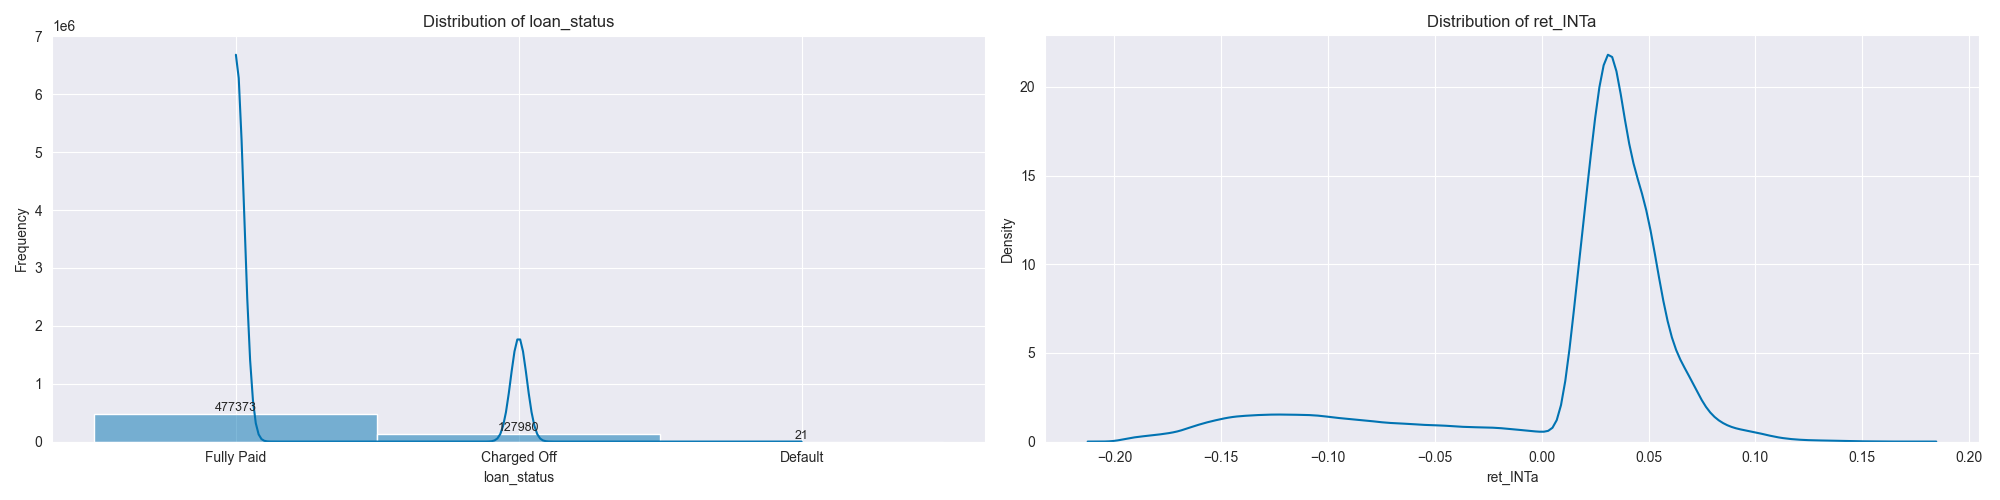

In [ ]:
display(figure_1_1)

<div style="line-height: 1.6;">
As seen in the plot above, the 'loan_status' feature has significant class imbalance. Since we are looking to predict default, which has a count of only 21 among the 605374 loans, predicting with this feature may lead to poor model performance. This is because the model will not have enough instances of default to learn from and may only learn to predict the majority class. In order to improve this issue, we create our target feature to consider both 'Default' and 'Charged Off' as instances of default. We expect this to have no impact conceptually since a loan is written off as 'Charged Off' when it has become unlikely for the loan to be recovered, indicating a failure to repay.
</div>
<br>
<div style="line-height: 1.6;">
The distribution of return provides some positive implications as most regression models assume 'normally distributed' errors. A gaussian-like (roughly bell-shaped, as above) distribution is also useful as there's a lower chance of having issues of heteroskedasticity (changing variance across the ranges of predictions).
</div>

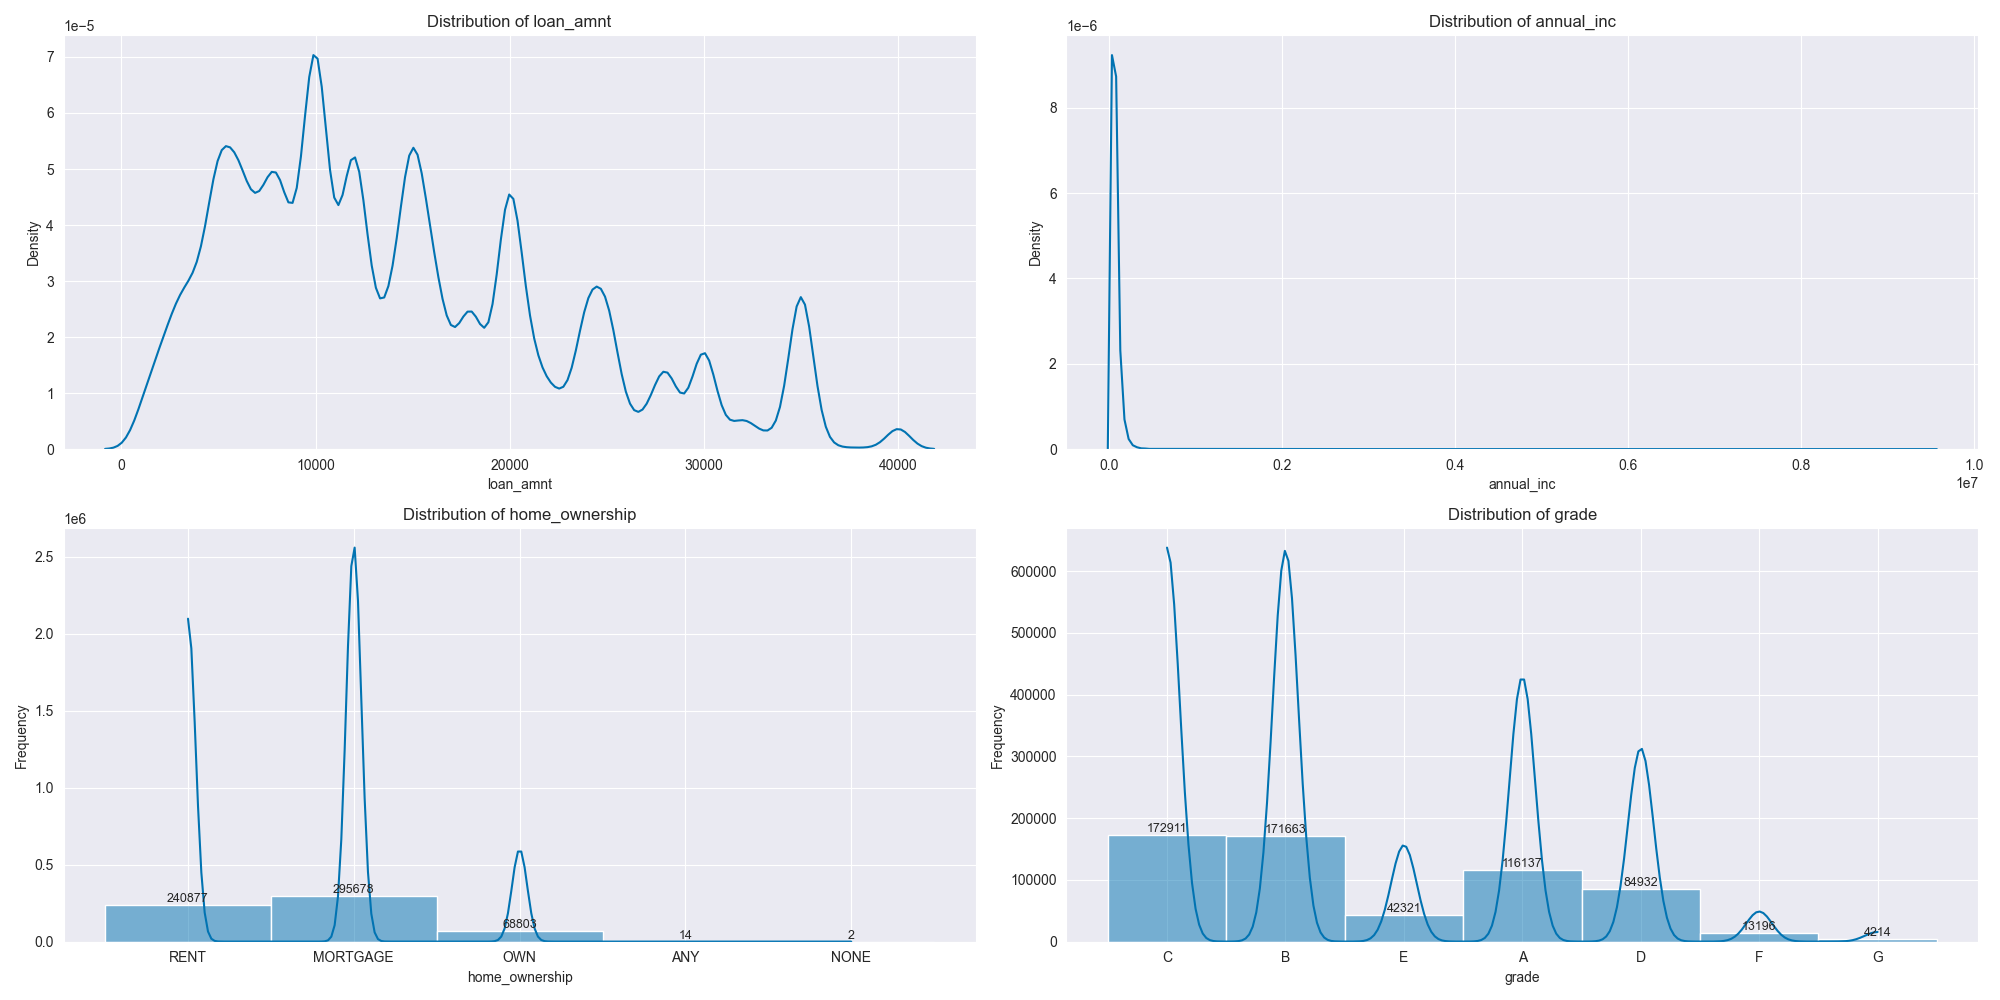

In [ ]:
display(figure_1_2)

<div style="line-height: 1.6;">
Looking at the above distributions of some of the explanatory features, we see that 'loan_amnt' shows a multi-modal distribution, meaning it has more than one peak, specficially around 10k, 15k, 20k etc, which tend to be typical loan values. 'annual_inc' has an extreme right-skewed distribution, also aligned with expectations of incomes across a representative dataset. Carrying on from behaviour expected from majority low or medium-income individuals, we see higher occurrences of renting and mortgages and a low occurence of ownership. 'grade' sees majority instances across grades A - C, showing fewer instances of low-grade loans.
</div>
<br>
<div style="line-height: 1.6;">
Before building our models, we also examine the relationship between some of our key features to ensure conceptual soundness and analyse what we may expect of feature importances.
</div>

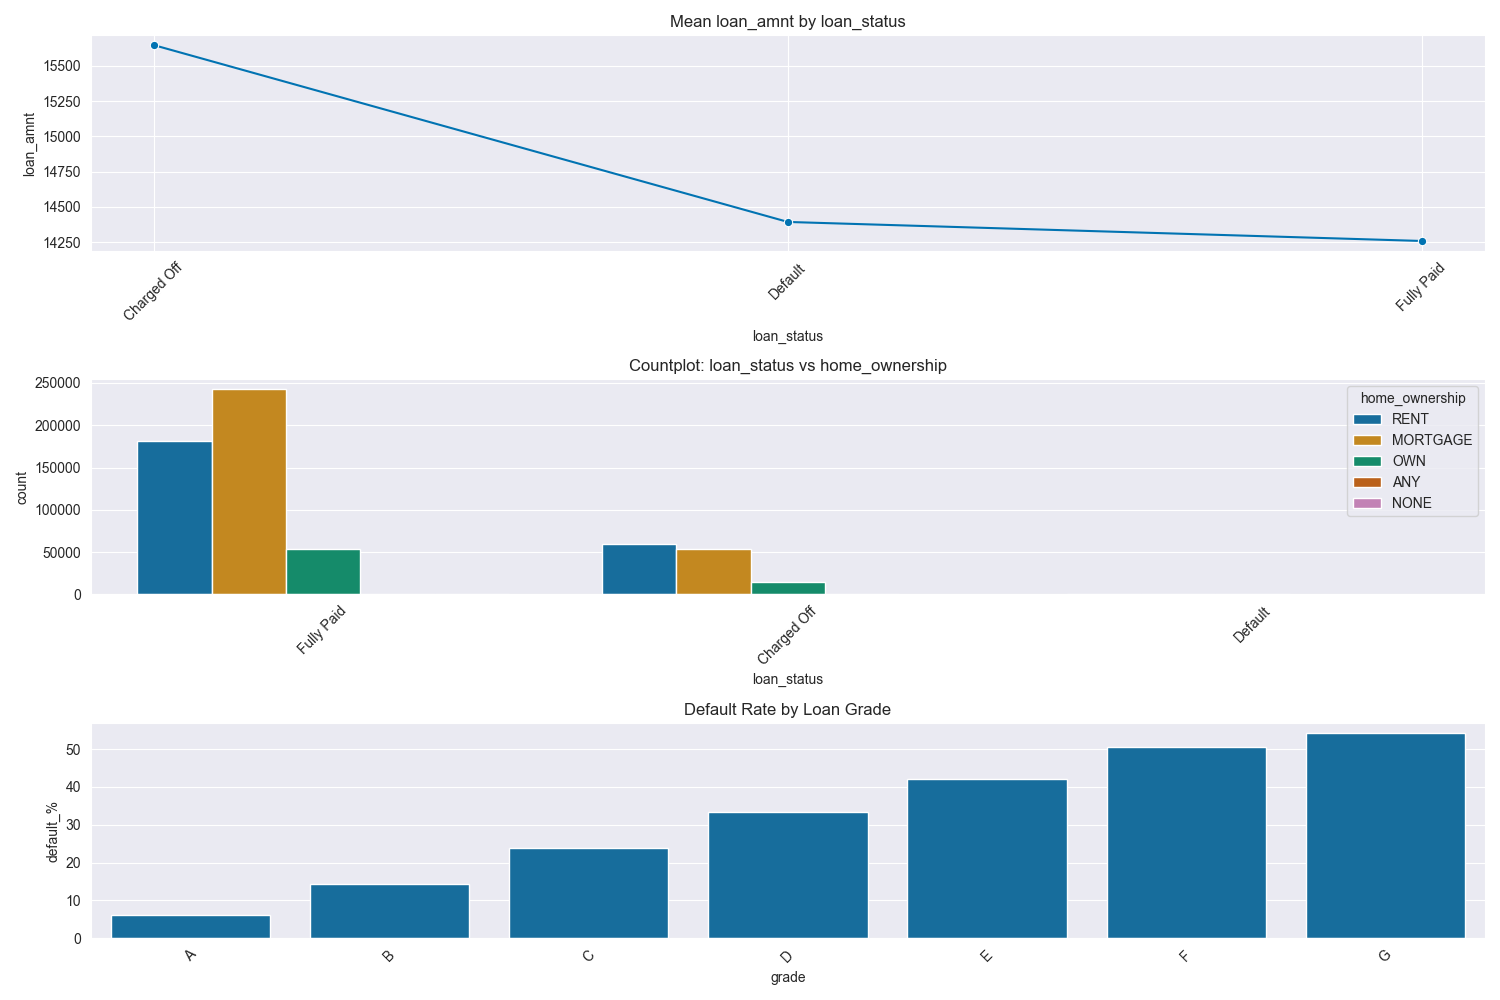

In [ ]:
display(figure_1_3)

<div style="line-height: 1.6;">
As expected, a lower loan amount show more occurences of full payment, with loans issues at high amounts being mostly charged off. We also see that loans that were fully paid had a greater proportion of mortgage holders than those that were charged off. In the last plot, we see that loans with a better grade had a lower percentage of default. All these findings are in line with our expectations of general customer behaviour.
</div>

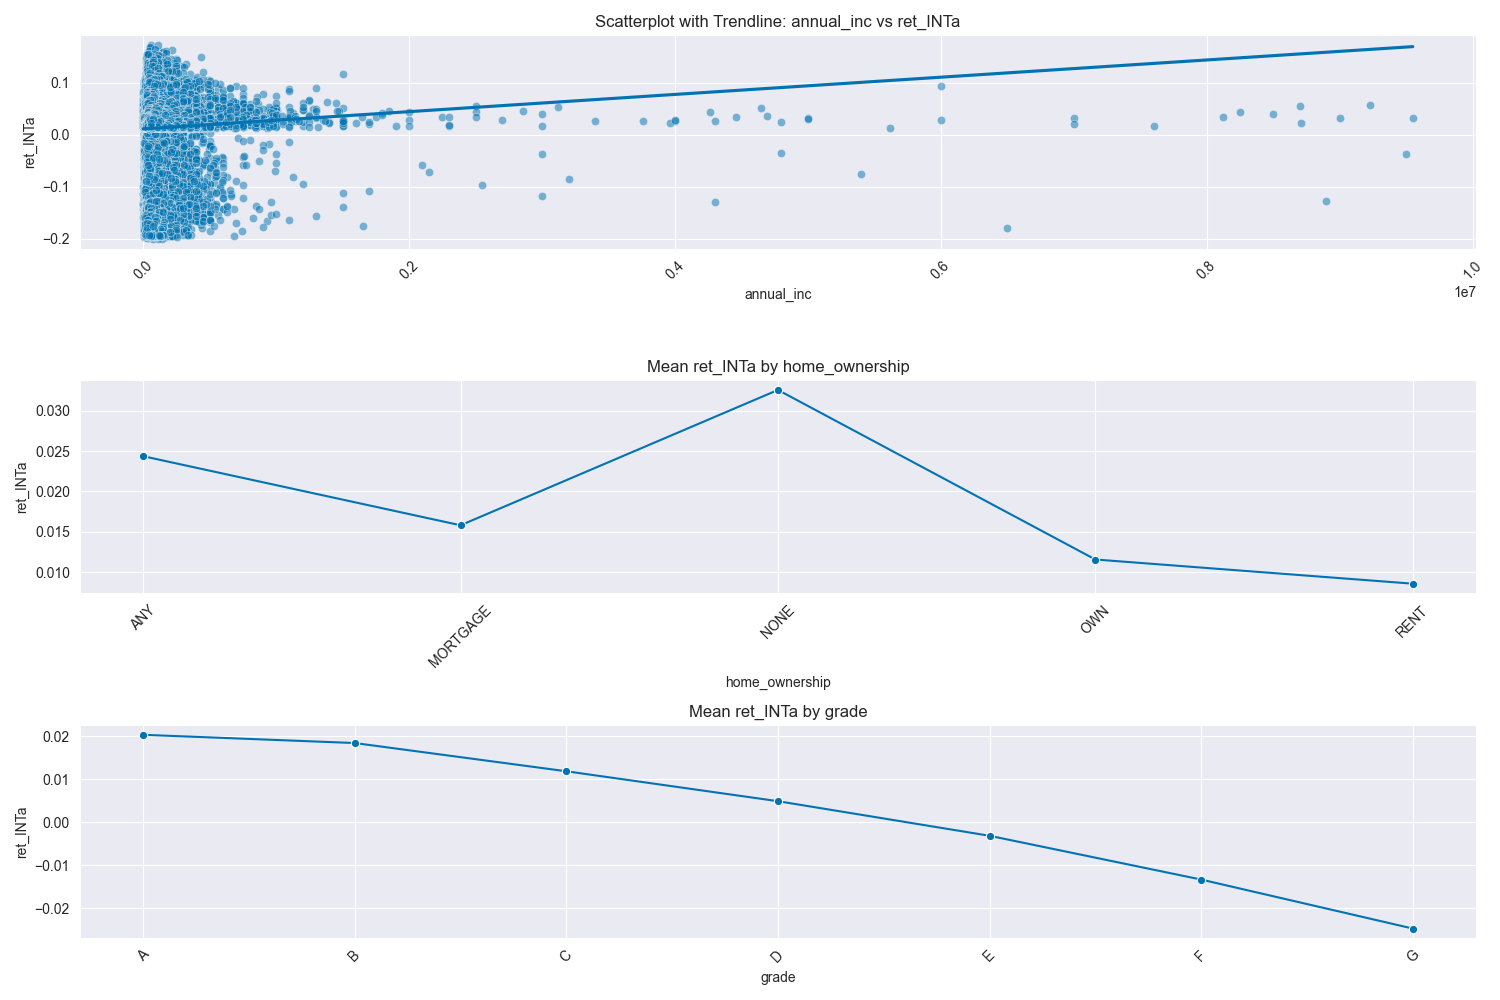

In [ ]:
display(figure_1_4)

<div style="line-height: 1.6;">
Annual income and grade interact with return as expected, we see a higher return as income rises and lower return as grade decreases. We don't see a clear relationship between home ownership and return, although mortgage holders seeing greater return than those that are renting can be justified conceptually.
</div>
<br>
<div style="line-height: 1.6;">
Finally, we plot correlations across all features to identify any features that may cause leakage or features that may be redundant (i.e., high correlation with another feature would mean only one of those features would be useful to the model).
</div>

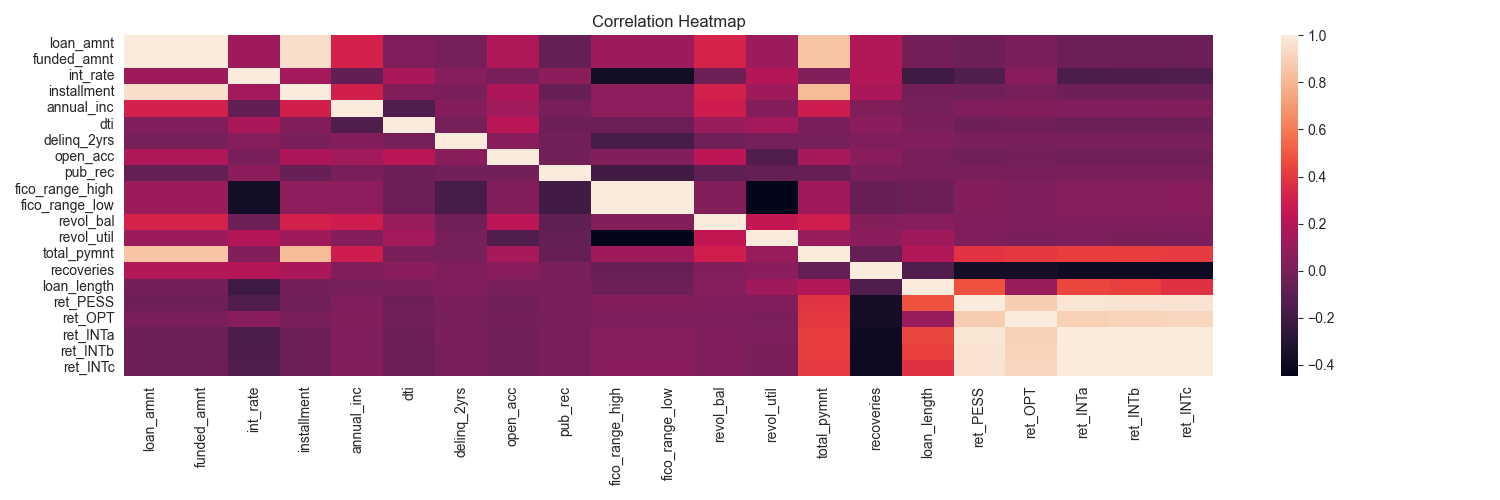

In [ ]:
display(figure_1_5)

<div style="line-height: 1.6;">
The heatmap above shows us correlations between the continuous variables in the dataset. After using the above and anaysing the conceptual definitions of all the features in the dataset, we identified the below as features that may cause data leakage or were redundant and will need to be removed prior to modelling.
<br><br>
<div style="padding-left: 20px;">
<ol>
    <li>'id': does not provide the model with any useful information.</li>
    <li>'issue_d', 'last_pymnt_d', 'earliest_cr_line' (date columns): as these would classify as categorical columns, the high cardinality of these features would reduce their usefulness. Instead of using these features as is, we compute a feature called to represent the length of the customer's credit history in either months or years.</li>
    <li>'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc' (return columns): As these were likely computed after the loan had reached maturity or had defaulted, they classify as 'leaky' feaures.</li>
    <li>'total_pymnt', 'recoveries': Both features are also only available after loan has matured and will cause data leakage.</li>
    <li>'term', 'funded_amnt': These are both redundant features. They are highly correlated with 'term_num' and 'loan_amnt' respectively and therefore add no usefu information to the model.</li>
    <li>'fico_range_low', 'fico_range_high': As visible in the heatmap, these features are also highly correlated. At least one of these features was removed before model training.</li>
</ol>
    </div>
</div>

# **3. Benchmark: Random Allocation**

Before we begin modelling, we define a benchmark to evaluate the investment strategies against. In order to do this, we define a strategy using a random allocation of N number of loans. To calculate return for the benchmark, we use the definition of return defined in section 4. This definition of return is used for portfolio evaluation for all strategies defined in this report in order to allow for comparability between the strategies.

The returns from a random portfolio are as follows:

| Portfolio Size | Mean Return | Std Dev |
|:--------------:|:-----------:|:-------:|
| 1000 | 2.77% | 0.0089 |
| 500 | 2.57% | 0.0114 |
| 300 | 2.67% | 0.0151 |


# **4. Investment Strategy 1: Maximising Return**

##  4.1 Model 1

- definition of return & explain
- what model you chose
- why you chose it
- any pre-processing done
- which hyperparameters you tuned
- how you chose your model and hyperparameters

## 4.2 Model 2 - Artifical Neural Network

<div style="line-height: 1.6;">

Artificial Neural Networks (ANNs) are brain-inspired computational models made up of interconnected “neurons” that process inputs and generate outputs (Katal & Singh, 2021). Introduced formally by McCulloch and Pitts in 1943, ANNs use weighted connections between layers to mathematically transform inputs into outputs (Zakaria, Al-Shebany & Sarhan, 2014). Widely applied across disciplines, ANNs are particularly effective in finance and economics for forecasting and optimizing returns. Atsalakis and Valavanis (2009) found ANNs outperform traditional methods in predicting stock returns, while Berg et al. (2020) showed that machine learning models, including ANNs, enhance credit risk assessment and support improved lending returns.

**Definition of Return**

The return is defined as the annualized yield on each loan, calculated by comparing total borrower repayments, including post-default recoveries, to the original loan amount. Calculating return in a logarithmic form smooths extreme values and makes the target distribution closer to normal. This metric, constructed as custom_return, serves as the target variable in the ANN model and aligns with the goal of maximizing investment returns. It offers a realistic, continuous, and investor-focused measure of loan performance, making it well-suited for modeling Lending Club data. Unlike default classifications or credit grades, it reflects the actual financial outcome for lenders in annualized terms, directly supporting the model’s objective to identify and recommend highly profitable loans.

What makes this return metric especially powerful is its basis in real borrower behavior. It incorporates the total amount repaid by the borrower, along with any recoveries obtained after default, rather than relying on binary assumptions of full repayment or complete loss. As a result, the ANN learns from a wide range of repayment outcomes, from fully performing loans to partially recovered defaults. This granular information enables more accurate predictions and better-informed investment decisions.

Moreover, annualizing the return ensures that loans of different term lengths are directly comparable. This standardization allows the ANN to uncover consistent and generalizable patterns in loan performance, regardless of duration. Additionally, recoveries are incorporated to account for funds recouped after defaults, providing a more accurate reflection of the lender’s real-world financial experience. Together, these characteristics make custom_return a highly effective and meaningful target for training an ANN model aimed at return maximization.

**Input Variables**

To select the most relevant features for modeling, the f_regression method is used to measure the correlation between each feature and the target variable, ranking them based on an F-statistic to retain the top 30. This process filters out irrelevant or weakly correlated inputs, improving the model’s ability to generalize to unseen data and reduce overfitting, while ensuring that only features with demonstrated predictive value for returns are included. The following input variables were used in the model, each showing a measured correlation with return.

</div>

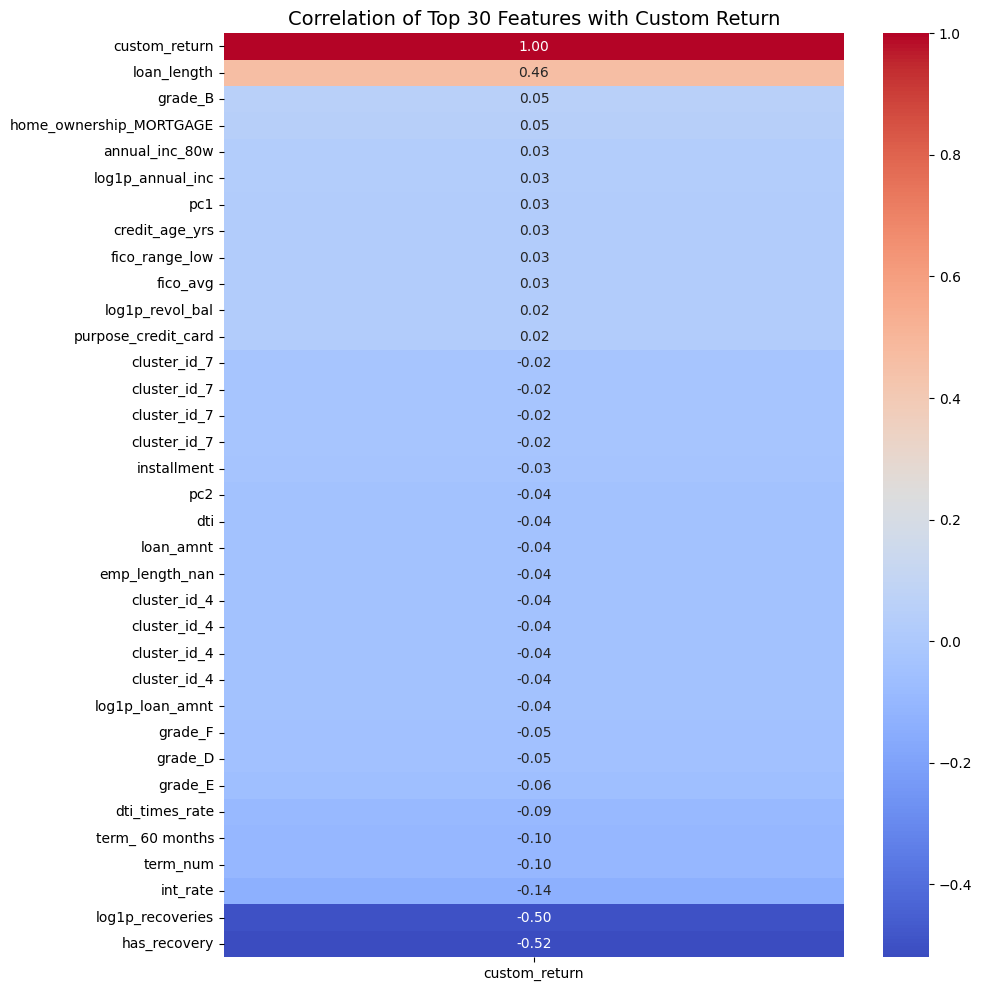

In [18]:
display(figure_3_1)

<div style="line-height: 1.6;">

**Methodology**

To prepare the data for ANN modeling, highly skewed numerical features were log-transformed, and moderately skewed ones were square-root transformed to normalize distributions while preserving rank order. A new feature, credit_age_yrs was created to capture borrower credit age from issue_d and earliest_cr_line. Categorical variables were also one-hot encoded for combability with the network. Financial ratios such as loan_to_inc and payment_to_inc were engineered to enhance metric accuracy. Finally, feature scaling was applied to ensure all numeric inputs were on a comparable scale, critical for ANN stability and unbiased learning. The target variable is then binarized where any return >0 becomes 1 (profitable), else 0 (not profitable). The dataset was then split into 80% training and 20% testing sets to separate learning from evaluation, with a random seed of 42 used to ensure model reproducibility. This pre-processing approach is applied to both the ANN and Random Forest models used in Strategy 1.

To improve the model’s performance, hyperparameter tuning was conducted. Rather than manually selecting key parameters such as number of neurons, batch size, or network depth, the tuning process was automated using Keras Tuner. Specifically, a Random Search approach was implemented to explore different configurations efficiently. The tuner tested various neuron counts between 10 and 100 in steps of 10, each using the ReLu activation function, which helps the model to lean complex, non-linear relationships in the data.

The hyperparameter search was carried out across 10 random trials, with each configuration trained twice for stability. During tuning, 10% of the training data was held out for validation, and models were trained for 20 epochs using a batch size of 64. The configuration that resulted in the lowest validation mean squared error was selected as the best-performing model. This optimal ANN model was then used to predict returns on the data.

</div>

# **5. Investment Strategy 2: Minimising Default**

## 5.1 Model 1

### 5.1.1 Random Forest Modeling Approach

#### Objective:
Random Forest was selected as the initial model to establish a strong baseline due to its robustness, ability to handle mixed data types, and good out-of-the-box performance without heavy hyperparameter tuning.

#### Data Preprocessing:

| Step                        | Details                                                                                                  |
|------------------------------|----------------------------------------------------------------------------------------------------------|
| **Definition of Default**    | Loans labeled as 1 if `loan_status` was 'Charged Off' or 'Default'; otherwise labeled as 0.               |
| **Preventing Data Leakage**  | Post-loan variables (`recoveries`, `total_pymnt`, `last_pymnt_d`, etc.) were removed to ensure only pre-loan information was used for training. |
| **Handling Missing Values**  | Rows with missing values were dropped to maintain dataset consistency and avoid biases from imputation.  |
| **Feature Engineering**      | - Converted `earliest_cr_line` to datetime format. <br> - Created a new feature `credit_history_years` to represent the borrower’s credit history length. <br> - Dropped the original `earliest_cr_line` column. |
| **Categorical Encoding**     | One-hot encoding on categorical features (`home_ownership`, `grade`, `emp_length`, `purpose`, `verification_status`, `term`) with `drop_first=True`. |
| **Train-Test Split**         | Random 80/20 split between training and testing sets using `train_test_split()`. |

#### Model Variations

Loan defaults are rare in our dataset, causing a baseline Random Forest to predict most loans as non-defaults—achieving high accuracy but poor default detection. To address this, we applied two strategies:

##### **Class Weighting**
We assigned higher weights to defaults and lower weights to non-defaults, penalizing misclassified defaults more heavily. This improved the model’s focus on the minority class and boosted default detection.

##### **Threshold Tuning**
We lowered the classification threshold from 0.5 to 0.2 for both baseline and weighted models, prioritizing recall over precision. This trade-off reduces undetected defaults, aligning with the strategy's risk-averse focus.


| Model Variation                            | Description                                                                                                                                               |
|---------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Baseline Random Forest**                  | Random Forest trained with default settings, no adjustments to threshold or class balance.                                                               |
| **Threshold-Tuned Random Forest**           | Lowered decision threshold to 0.2 to prioritise identifying defaults, increasing recall at the cost of more false positives.                             |
| **Class-Weighted Random Forest**            | Applied higher weight to defaults (2.41) and lower weight to non-defaults (0.63) during model training to address class imbalance.                        |
| **Threshold-Tuned Class-Weighted Random Forest** | Combined class weighting with threshold adjustment (threshold 0.2) to maximise recall while controlling the precision-recall trade-off.                |

#### Evaluation and Decision:

| Model                     | Recall (Default) | Precision (Default) | Recall (Non-Default) | Precision (Non-Default) | AUC   |
|---------------------------|------------------|----------------------|----------------------|-------------------------|-------|
| Baseline                  | 0.17             | 0.58                 | 0.97                 | 0.82                    | 0.776 |
| Threshold-Tuned Baseline  | 0.81             | 0.34                 | 0.59                 | 0.92                    | 0.776 |
| Class-Weighted            | 0.15             | 0.59                 | 0.97                 | 0.81                    | 0.779 |
| Threshold-Tuned Weighted  | 0.79             | 0.35                 | 0.62                 | 0.92                    | 0.779 |

Although threshold tuning significantly improved recall, the general performance of Random Forest models plateaued. Their ability to distinguish defaults remained limited, motivating exploration of more advanced ensemble methods.

### 5.1.2 XGBoost Modeling Approach

#### Objective:
XGBoost was implemented following Random Forest to achieve higher recall, better handling of class imbalance, and improved scalability.

#### Data Preprocessing:

Included some additional preprocessing not explored in Random Forest.

| Step                        | Details                                                                                                  |
|------------------------------|----------------------------------------------------------------------------------------------------------|
| **Definition of Default**    | Loans labeled as 1 if `loan_status` was 'Charged Off' or 'Default'; otherwise labeled as 0.               |
| **Preventing Data Leakage**  | Post-loan variables were excluded.                                                                      |
| **Handling Missing Values**  | - Continuous features imputed with the median. <br> - Categorical features imputed with "Unknown".        |
| **Target Encoding**          | Defaults mapped to 1; others mapped to 0.                                                                |
| **Feature Engineering**      | Created `cr_hist` by computing the difference in months between the loan issue date (`issue_d`) and the borrower's earliest credit line (`earliest_cr_line`). |
| **Categorical Encoding**     | One-hot encoding applied, dropping the first category to avoid multicollinearity.                        |
| **Type Consistency & Cleaning** | Columns were cleaned, continuous features enforced as floats.                                            |
| **Train-Test Split**         | Stratified sampling used to split the dataset, with 25% of data allocated to the test set.               |


#### Model Variations:

| Model Variation                       | Description                                                                                                                                      |
|----------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| **Baseline XGBoost**                   | Trained with default parameters and no class weighting; used as a starting benchmark.                                                            |
| **Weighted XGBoost**                   | Introduced `scale_pos_weight` to adjust for class imbalance by giving more importance to the minority (default) class during training.           |
| **Tuned XGBoost (Weights + Hyperparameter Tuning)**          | Applied class weighting and tuned hyperparameters to optimise performance across AUC, precision, and recall.|

A comprehensive parameter grid was defined to tune the hyperparameters, targeting key model aspects such as tree depth, learning rate, number of boosting rounds, and sampling ratios: 

| Hyperparameter        | Description                                                             | Values         |
|------------------------|-------------------------------------------------------------------------|----------------|
| **n_estimators**        | Number of boosting rounds                                               | 100, 200       |
| **learning_rate**       | Step size shrinkage used in updates                                     | 0.05, 0.1, 0.2 |
| **max_depth**           | Maximum depth of each decision tree                                     | 3, 5, 7        |
| **subsample**           | Fraction of training instances randomly sampled for each tree          | 0.8, 1.0       |
| **colsample_bytree**    | Fraction of features randomly sampled for each tree                     | 0.8, 1.0       |


A 3-fold cross-validated GridSearchCV was applied to systematically evaluate all parameter combinations, using ROC AUC as the evaluation metric. A total of 72 candidate models were tested, resulting in 216 model fits overall.

The optimal set of hyperparameters identified was:

| Hyperparameter        | Selected Value |
|------------------------|----------------|
| `colsample_bytree`     | 1.0            |
| `learning_rate`        | 0.1            |
| `max_depth`            | 5              |
| `n_estimators`         | 200            |
| `subsample`            | 0.8            |


This configuration achieved the best balance between model complexity and predictive performance. This best-performing model was then selected for subsequent evaluation and threshold tuning to support the default-minimisation investment strategy.

#### Evaluation and Final Model Selection:

##### Threshold Tuning

Similar to the approach used in Random Forest, threshold tuning was applied to the class-weighted and hyperparameter-optimised XGBoost model to prioritise the minimisation of undetected defaults. The model's performance across different threshold levels is summarised below:

| Threshold | Precision | Recall  | F1 Score | ROC AUC |
|-----------|-----------|---------|----------|---------|
| 0.30      | 0.2626    | 0.9256  | 0.4091   | 0.7317  |
| 0.50      | 0.3463    | 0.6815  | 0.4592   | 0.7317  |
| 0.70      | 0.4886    | 0.2862  | 0.3610   | 0.7317  |

At a threshold of 0.30, the model achieves a recall of 92.56%, significantly reducing the likelihood of missing high-risk borrowers. Compared to the Random Forest models, this evaluation demonstrates superior recall and overall predictive performance, making XGBoost a more effective tool for minimising default risk.

##### Final Model Selection

Based on this evaluation, the **Class-Weighted and Tuned XGBoost** model with a **threshold of 0.30** was selected as the final model. It achieved the strongest balance between recall, F1 score, and overall model robustness, aligning best with the strategic objective of minimising default risk in the investment portfolio.


## 5.2 Model 2 - Artificial Neural Network

<div style="line-height: 1.6;">
For our second model, we consider an Artificial Neural Network (ANN) with a binary target variable. As described in section 3.2, ANNs are powerful computational models that use interconnected 'neurons' to mimic the structure and function of a human brain. These models have found success across multiple industries, with applications in areas like lending and portfolio optimisation within finance.
<br><br>
There's four main components to an ANN:

1. Nodes: single computational unit within a layer. The number of nodes within a layer can vary.
1. Input layer: processes the input data and passes it on to the first hidden layer.
2. Hidden layer: processes the data it receives and passes it on to the next hidden layer. ANNs can have a large number of hidden layers, but for the sake of simplicity and ease of implementation, we limit our model to one hidden layer.
3. Output layer: the final layer of the ANN. The number of nodes within the output layer depends on the type of model. A multi-class classification model would have nodes corresponding to the number of classes, while a binary classifier will have only one.

<br>

**Data Pre-processing**

A number of pre-processing steps were undertaken before we began modelling. To start with, we create our target variable using the 'loan_status' column. Our target is defined as taking the value of 1 if a loan held a 'Default' or 'Charged Off' status, and 0 if it hold a 'Fully Paid' status. As discussed in section 2, we consider 'Charged Off' as default in order to reduce the class imbalance, and expect no conceptual issues to arise from this. Additionally, we deal with our date columns, namely 'issue_d', 'last_pymnt_d', 'earliest_cr_line', by creating a numeric column called 'credit_history_months' to depict the length of the borrower's credit history.
<br><br>
We then drop any columns that could cause feature leakage, details of which were also discussed in section 2. To summarise, the following features were dropped: 'loan_status', 'id', 'issue_d', 'last_pymnt_d', 'earliest_cr_line', 'term', 'funded_amnt', 'fico_range_low', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc', 'total_pymnt', 'recoveries'. Categorical columns were then transformed using one-hot encoding, and the data was standardised using scikit-learn's standard scaler to avoid the implicit weighting of columns due to varying scales.
<br><br>
Finally, we split our dataset into training and test sets, with 10% of the dataset retained as a test set. We limit the test set to 10% since 20% of the training dataset will be used for validation while tuning hyperparameters and we aim to provide the model with as much data as possible for training.

<br>

**Hyperparameter Tuning**

There's a number of parameters that can typically be tuned when training an ANN. These may include the number of hidden layers, the number of units within each layer, and the learning rate. However, since we are training a model with only one hidden layer, we consider only the number of units within the hidden layer and the learning rate for this model. A range of 1 - 100 was considered for the number of units, while the learning rate was controlled using the ReduceLROnPlateau callback. We use a callback instead of tuning for the learning rate to avoid overfitting due to extensive tuning and for efficiency in model development. A dynamic learning rate also offers better adaptation to the model's needs. In addition to ReduceLROnPlateau, we also use the EarlyStopping callback to avoid overfitting the model when the model stops seeing improvement.

<br>

**Model Training**

We use the keras tuner to do a parameter search and identify the best value for the number of units in the hidden layer. A reLU (Rectified Linear Unit) activation function is used for the hidden layer, and a sigmoid activation function is used for the output layer in order to force values between 0 and 1. The validation set was set to 20% and 10 epochs were used for each trial, with 15 trials in total. Additionally, 'val_auc' was used as the 'objective', since the AUC evaluates the models ability to distinguish between the two classes. Since we have an imbalanced dataset, we also pass class weights to the tuner to use in model training. This ensures that the model pays attention to the minority class, which is especially important in this case since 'default' is the minority class.

<br>

**Model Evaluation**

We evaluate our model using key metrics like accuracy, precision, recall, and AUC. In this case, we aim to have a higher recall since our priority is to catch as many default cases as possible. This does typically lead to a lower precision, but was decided to be acceptable in this scenario since we are building a risk-averse portfolio and have a lower threshold for false negatives.
<br><br>
As part of model evaluation, we also analyse feature importances to ensure conceptual soundness in our model. Additionally, we tune the model threshold to achieve our desired threshold for recall.

<br>

**Portfolio Construction**

In order to construct our final portfolio, we predict the probability of default on our test set using our trained model. Before selecting loans for our portfolio, we drop all loans that don't meet our chosen threshold for probability of default. We then select the top N loans with the lowest probability of default from the remaining loans, where N is the number of loans we want in our portfolio.

</div>

# **6. Experiments & Results**

## 6.1.1 Return Random Forest Expermients

| Portfolio Size (N) | Predicted Avg Return | Actual Avg Return |
|:------------------:|:--------------------:|:-----------------:|
| 50                 | 0.1064                | 0.1220            |
| 100                | 0.1029                | 0.1177            |
| 200                | 0.0995                | 0.1118            |

The table shows that while the Random Forest model slightly underpredicts returns across all portfolio sizes, it successfully identifies high-performing loans, with actual returns consistently exceeding predicted values.

| Portfolio Size (N) | RF Top-N Avg Return | Random Top-N Avg Return |
|:------------------:|:-------------------:|:-----------------------:|
| 50                 | 0.1226               | 0.0790                  |
| 100                | 0.1205               | 0.0917                  |
| 200                | 0.1168               | 0.0874                  |

The table shows that the Random Forest model consistently selects higher-return loans compared to a random selection baseline across all portfolio sizes, highlighting its ability to identify more profitable opportunities.


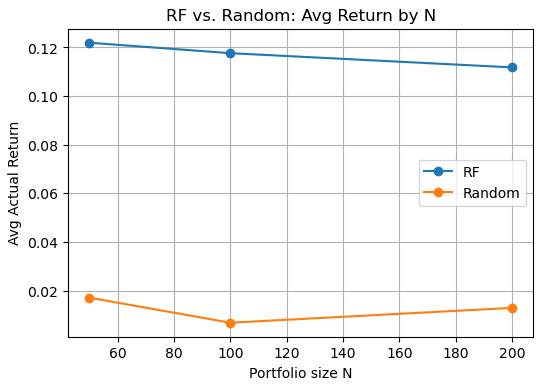

In [232]:
display(figure_rf_vs_random)

Across all portfolio sizes, the Random Forest model consistently achieves higher average returns than random selection.

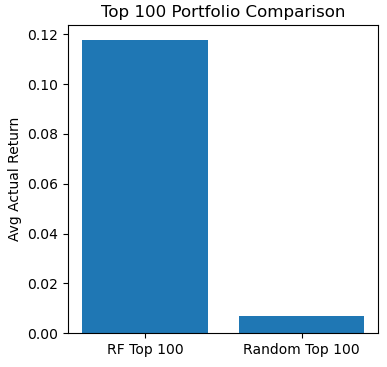

In [230]:
display(figure_top_100)

The Random Forest Top 100 loans deliver a significantly higher average return compared to a randomly selected Top 100 portfolio.

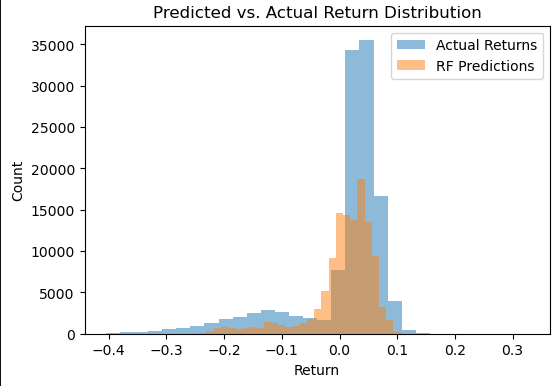

In [228]:
display(figure_pred_vs_actual)

The distribution shows that Random Forest predictions capture the general shape of actual returns but underestimate extreme outcomes.

## 6.1.2 Return ANN Model Experiments

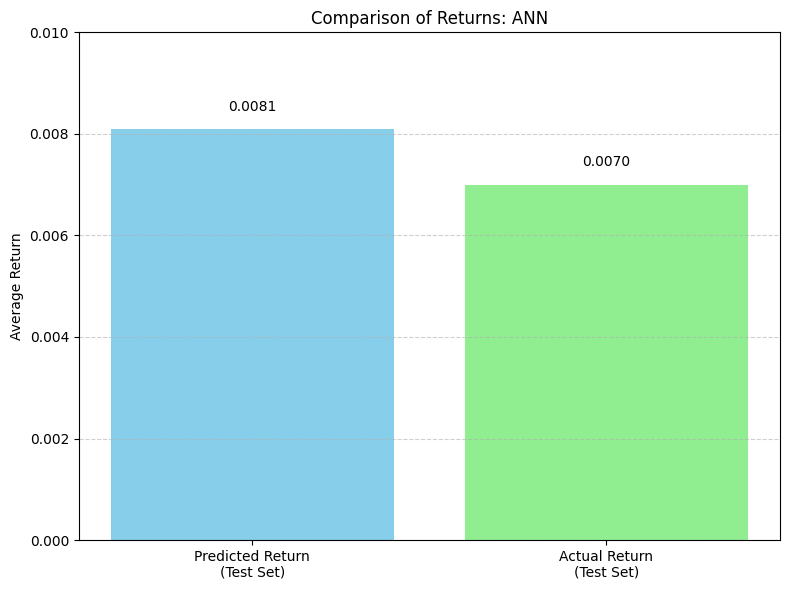

In [26]:
display(figure_6_1)

The ANN model achieved a predicted return of 0.0081 on the test set, closely aligning with actual returns despite slight overestimation. Its directional accuracy of 80.72% indicates strong trend detection. Compared to a random strategy (average return 0.0069), the ANN delivered higher profitability, demonstrating more informed investment predictions even with a modest margin.


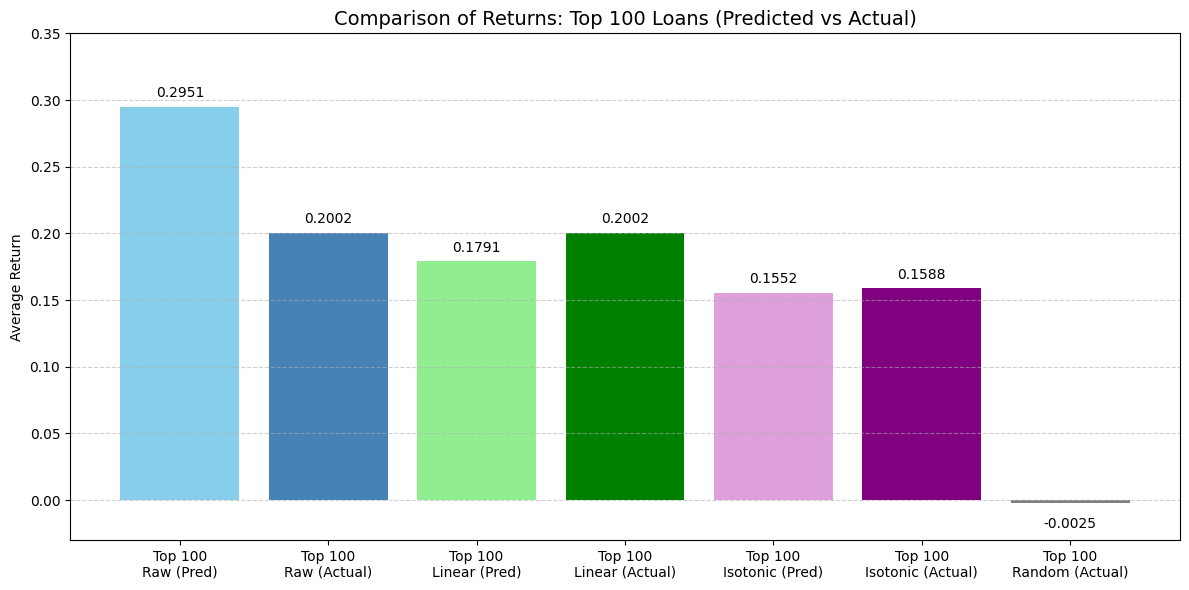

In [25]:
display(figure_6_2)

The ANN model effectively identifies high-return loans, with all three top 100 selection strategies outperforming random selection. Raw predictions yield the highest returns, while linear scaling offers conservative yet strong results. Isotonic calibration further improves accuracy by smoothing predictions and reducing overfitting risk. In contrast, random selection produces negative returns, highlighting the model’s ability to distinguish high- from low-performing investments.

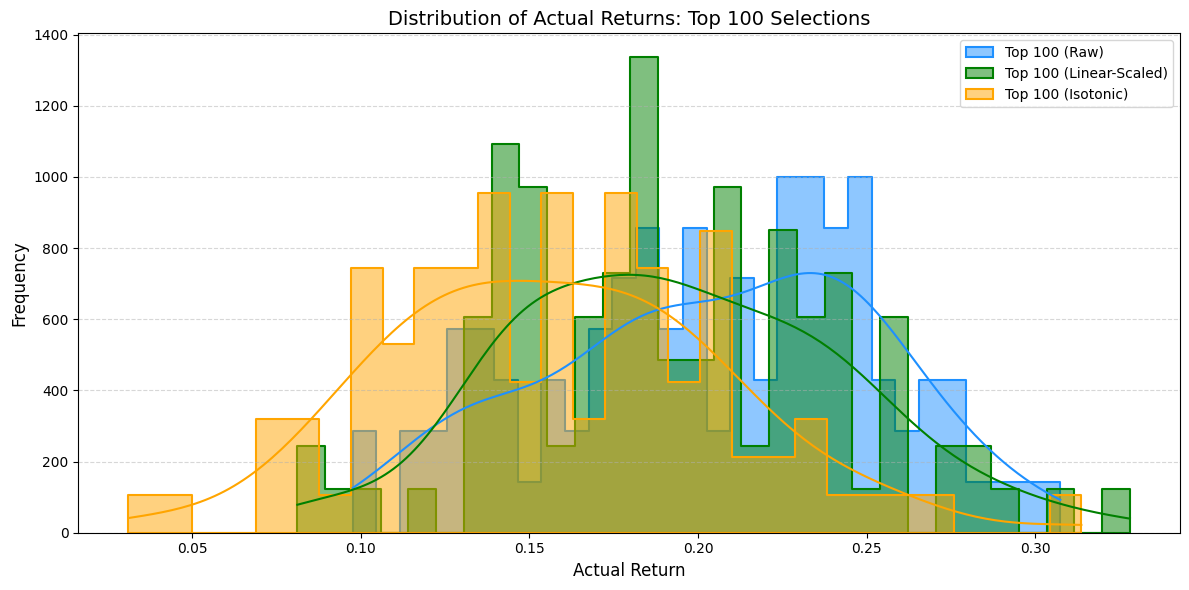

In [24]:
display(figure_6_3)

Raw return predictions are right-shifted with a peak around 0.20–0.30, showing higher but riskier returns. Linear scaling shifts the peak to 0.15–0.22, moderating predictions for more consistent outcomes. Isotonic calibration shifts further left (0.10–0.18), closely matching real-world returns and improving robustness by reducing overfitting.

The ANN model performs strongly, with a low MSE (0.00303) and MAE (2.67%), indicating small prediction errors. An R² of 0.55 shows it captures over half the variation in returns—solid given the noisy nature of financial data. Directional accuracy of 80.72% further highlights its reliability in forecasting positive or negative returns.

During model development, we tested various ANN configurations and return definitions. Logarithmic annualized return proved best for the dataset. For feature selection, f_regression outperformed basic correlation analysis, streamlining inputs and boosting overall model performance.


## 6.1.3 Default XGBoost Experiments

### XGBoost Model Performance Comparison

The models variations were evaluated using a hold-out validation approach based on the 75/25 train-test split, where performance was assessed on the unseen test set using metrics such as accuracy, F1 score, and ROC AUC. Predicted probabilities were converted into class labels by applying a threshold of 0.5 for classification.

| Model                               | Accuracy | F1 Score | ROC AUC |
|-------------------------------------|----------|----------|---------|
| Baseline XGBoost (No Weights, No Tuning) | 0.7947   | 0.2159   | 0.7301  |
| Weighted XGBoost (Class Weights, No Tuning) | 0.6629   | 0.4566   | 0.7288  |
| Tuned XGBoost (Weights + Hyperparameter Tuning) | 0.6607   | 0.4592   | 0.7317  |

While the baseline model achieved the highest overall accuracy, its low F1 score highlighted poor balance between precision and recall. Applying class weighting significantly improved the F1 score, and further hyperparameter tuning produced additional gains in both F1 score and ROC AUC. Consequently, the Tuned XGBoost model was selected as the final model due to its superior balance across recall, precision, and overall discriminatory ability.

### Overfitting Assessment

To evaluate model stability, ROC AUC scores were compared across training, test, and cross-validation sets:

| Model                     | Train AUC | Test AUC | 3-Fold CV AUC (Train) |
|----------------------------|-----------|----------|-----------------------|
| Baseline XGBoost           | 0.7285    | 0.7278   | 0.7262 ± 0.0010        |
| Tuned XGBoost (final)      | 0.7444    | 0.7317   | 0.7295 ± 0.0011        |

Both models showed minimal overfitting, with consistent performance between training and testing.


### Learning Curve Analysis

The learning curve shows the evolution of model performance as the training set size increases:

| Metric            | Trend                                                    | Insight                                         |
|-------------------|-----------------------------------------------------------|-------------------------------------------------|
| Training AUC      | Started high (~0.84), gradually declined to ~0.75          | Indicates initial overfitting, stabilising with more data |
| Validation AUC    | Steadily increased from ~0.718 to ~0.729                  | Shows improved generalisation over time        |
| Gap Between Curves| Narrowed as training progressed                           | Moderate, manageable overfitting               |

Overall, the model generalizes effectively, though additional data offers diminishing returns beyond a certain point.

### Feature Importance Analysis

Using gain-based feature importance scores from the tuned XGBoost model, the top predictors of loan default were identified based on their contribution to model performance:

| Rank | Feature                    | Key Insight                                                                                   |
|-----:|-----------------------------|----------------------------------------------------------------------------------------------|
| 1    | `int_rate`                  | Higher interest rates strongly correlate with higher credit risk and default probability.   |
| 2    | `grade_B`                   | Credit grade linked to borrower risk profiling and expected repayment behavior.             |
| 3    | `term_60 months`             | Longer loan terms increase risk due to extended borrower exposure over time.                 |
| 4    | `home_ownership_MORTGAGE`    | Mortgage status may signal higher financial obligations compared to outright ownership.      |
| 5    | `home_ownership_RENT`        | Renters may have less financial stability, increasing default risk.                         |
| 6    | `emp_length_Unknown`         | Missing employment length data may suggest weaker credit profiles.                          |
| 7    | `grade_C`                    | Lower credit grades (C, D, E) are associated with higher default probability.                |
| 8    | `grade_E`                    | Similar to grade_C, indicating higher credit risk borrowers.                                |
| 9    | `fico_range_high`            | Lower FICO ranges are tied to higher default risk.                                           |
| 10   | `grade_D`                    | Further reinforces the risk link between lower grades and default likelihood.               |
| 11   | `dti`                        | Higher debt-to-income ratios indicate greater repayment burden and risk.                    |
| 12   | `loan_amnt`                  | Larger loan amounts correlate with increased financial strain and default likelihood.       |
| 13   | `verification_status_Verified` | Verified income status affects borrower credibility and repayment assessment.             |
| 14   | `purpose_small_business`     | Loans for small businesses carry elevated risk due to business volatility.                  |
| 15   | `installment`                | Monthly repayment amounts impact borrower affordability and repayment behavior.             |

While features with lower gain-based importance contributed less to predictive performance in this model, they remain relevant indicators of borrower behavior and credit risk in real-world lending contexts.

## 6.1.4 Default ANN Model Experiments

The ANN model was trained as described in section 5.2 and 15 trials were run, with results from the top 3 runs displayed below:
<br><br>

| Trial ID | Units | Validation AUC Score |
|:--------|:------|:---------------------|
| **03**  | **65** | **0.7842** |
| 13      | 95    | 0.7821               |
| 06      | 98    | 0.7818               |

<br>

The plot of the ROC curve below for the model from trial 3 also shows us an ideal curve, with the curve hugging the top left, suggesting good overall performance of the model across all thresholds.

</div>

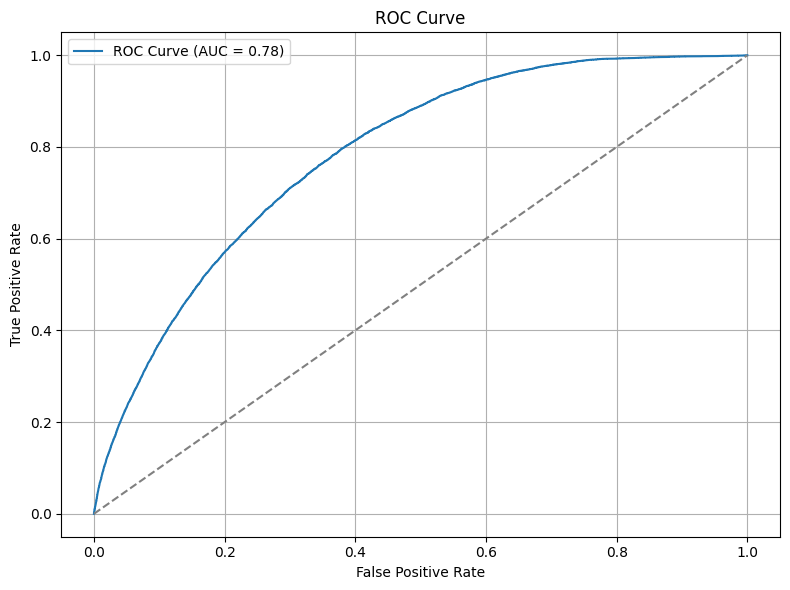

In [23]:
display(figure_6_4)

<div style="line-height: 1.6;">
We conduct threshold tuning in order to achieve a better recall score, uncovering 0.432 as the threshold at which 80% recall can be achieved. However, we round this up to 0.45 in order to avoid penalising the precision score extensively. Additionally, the model provides improved performance over the benchmark across all portfolio sizes, providing us with a good candidate model for portfolio construction. The results from the model from trial 3 with a threshold for 0.45 are as follows:
<br><br>

| Metric     | Value  |
|:-----------|:-------|
| Accuracy   | 0.668  |
| Precision  | 0.366  |
| Recall     | 0.776  |
| F1 Score   | 0.498  |
| AUC        | 0.782  |

<br>

- Selected Low-Risk Loan Portfolio Summary (Threshold < 0.45)

| Metric                             | Value   |
|:-----------------------------------|:--------|
| Total Loans Selected               | 33,325  |
| Observed Default Rate (Portfolio)  | 19.67%  |


<br>

- Top N Loan Portfolio Summary

| Top N Loans | Observed Default Rate | Average ROI |
|:-----------|:----------------------|:-----------|
| 300        | 10.00%                 | 12.45%     |
| 500        | 10.87%                 | 11.60%     |
| 1000       | 14.29%                 | 10.70%     |

</div>

## 6.2.1 Detailed Comparative Analysis of Return Models

### Model Performance Comparison

| Metric                  | ANN           | Random Forest  |
|:------------------------|:--------------|:---------------|
| Mean Squared Error (MSE) | 0.00303        | 0.00315         |
| R² (Variance Explained)  | 55.3%          | 53.6%           |

When comparing ANN and Random Forest models, the ANN shows slightly better performance, achieving a lower mean squared error (MSE) of 0.00303 versus 0.00315. It also explains more variance in returns, with an R² of 55.3% compared to 53.6%, suggesting stronger predictive accuracy on the test set.

### Top 100 Loan Selection: Predicted vs. Actual Return

| Model           | Predicted Avg Return | Actual Avg Return | Key Observation                          |
|:----------------|:---------------------|:------------------|:-----------------------------------------|
| ANN             | Close match           | High precision    | Small gap between predicted and actual   |
| Random Forest   | Underpredicted        | Higher than predicted | Larger gap between predicted and actual |

Top 100 loan selection results further highlight the ANN’s advantage. Its predicted average returns closely align with actual returns, showing high precision. In contrast, the Random Forest underpredicts returns, and the gap between predicted and actual averages is notably larger.

### Feature Selection Strategy

| Model           | Features Used                        | Notes                                        |
|:----------------|:-------------------------------------|:--------------------------------------------|
| ANN             | Top 30 features via f_regression     | Focused on strongest correlations with return |
| Random Forest   | 40 features including borrower segmentation | Broader coverage, but more noise introduced  |

The ANN’s stronger results are partly due to its feature selection strategy, using the top 30 features identified by f_regression, focusing on variables most correlated with returns. Meanwhile, Random Forest uses 40 features, including borrower segmentation attributes, offering broader coverage but introducing more noise.

## 6.2.2 Detailed Comparative Analysis of Default Models 

### Table of Model Evaluation Metric Comparisions

| Model                   | Accuracy | Precision (Class 1) | Recall (Class 1) | F1 Score (Class 1) | ROC AUC |
|--------------------------|----------|---------------------|------------------|--------------------|---------|
| ANN (Thresh 0.45)         | 0.6680   | 0.3660              | 0.7760           | 0.4980             | 0.7750  |
| XGB (Thresh 0.30)         | 0.6607   | 0.2626              | 0.9256           | 0.4091             | 0.7317  |
| XGB (Thresh 0.50)         | 0.6607   | 0.3463              | 0.6815           | 0.4592             | 0.7317  |
| XGB (Thresh 0.70)         | 0.6607   | 0.4886              | 0.2862           | 0.3610             | 0.7317  |
| RF (Baseline)             | 0.8030   | 0.5800              | 0.1700           | 0.2600             | 0.7760  |
| RF (Class Weighted)       | 0.8020   | 0.5900              | 0.1500           | 0.2400             | 0.7790  |
| RF (Thresh 0.2)           | 0.8020   | 0.3400              | 0.8100           | 0.4800             | 0.7790  |
| RF Weighted + Thresh 0.2  | 0.8020   | 0.3500              | 0.7900           | 0.4900             | 0.7790  |

The models offer complementary strengths: ANN provides stable recall and AUC, XGBoost offers flexible threshold tuning for risk control, and Random Forest achieves the best F1 balance. To best meet the coursework goal of minimising defaults, XGBoost at a 0.30 threshold is recommended as the primary model (which will be used to form the final loan portfolio).

| Goal                          | Best Model                  | Reasoning                                            |
|------------------------------- |----------------------------- |----------------------------------------------------- |
| Maximizing Recall              | XGBoost @ Threshold 0.30     | Catching nearly all positives (recall = 0.93)        |
| Maximizing Precision           | XGBoost @ Threshold 0.70     | Highest precision (0.49) with controlled recall      |
| Balanced F1 (Fair Trade-off)    | RF Weighted + Threshold      | Best F1 (0.49), strong recall and decent precision   |
| Overall AUC Performance        | ANN or RF (any tuned)         | AUC (0.775-0.779), best class discrimination         |


## 6.3.1 High-Return Loan Portfolio Analysis: Maximising Return (ANN)

Different portfolio sizes were explored to evaluate the effectiveness of model-driven selection versus random selection:
|    N | Predicted Avg ROI | Random Avg ROI |
|-----:|------------------:|---------------:|
| 1000 |          0.118950  |         0.1245 |
|  500 |          0.136371  |         0.1160 |
|  300 |          0.153812  |         0.1070 |

The table compares the average return on investment (ROI) achieved by a model-based selection strategy ("Predicted Avg ROI") against a random selection baseline ("Random Avg ROI") across different portfolio sizes (N). At larger portfolio sizes (N=1000), the random strategy slightly outperforms the model. However, as the portfolio size decreases, the model's performance improves significantly, outperforming the random baseline by an increasing margin. This suggests that the model is more effective at identifying higher-return opportunities when focusing on a smaller, more selective set of investments.



## 6.3.2 Low-Risk Loan Portfolio Analysis: Minimising Default Model (XGBoost)

### Loan Portfolio Segmentation Using XGBoost

Different threshold-based strategies for loan portfolio construction were explored. The following table summarises the key portfolio options:

| Strategy                        | Total Loans Selected | Observed Default Rate | Key Insight                                                 |
|----------------------------------|----------------------|-----------------------|-------------------------------------------------------------|
| Threshold-Based (< 0.2)          | 19,277               | 3.94%                 | Very low-risk portfolio ideal for minimising defaults.      |
| Top N Loans (Top 300 safest)     | 300                  | 1.33%                 | Ultra-low default rate but limited size and diversification.|
| Top X% Loans (Top 10%)           | 15,134               | 3.36%                 | Balances low risk with larger portfolio scale.              |

### Recommendations
- For clients prioritizing ultra-low risk, Top 300 safest portfolio is ideal.
- For those balancing risk and scale, Threshold < 0.2 portfolio provides a larger selection with still very low risk.
- Top 10% portfolios present a strong middle ground, offering both diversification and significantly reduced default risks.

# **7. Limitations**

Although the models achieved promising results, several limitations in design, training, and interpretability suggest areas for future development.

For XGBoost, moderate overfitting indicates imperfect generalization, and learning gains plateaued with more data, suggesting a ceiling effect. Interpretability also remains challenging due to model complexity. Future improvements could involve advanced feature engineering, deeper hyperparameter tuning (tree depth, learning rate, regularization), and exploring alternative models like LightGBM, CatBoost, or more interpretable options such as Explainable Boosting Machines (EBMs).

The default ANN also showed constraints. Architecture search was narrow (only 15 trials across 1–100 nodes), and learning rate tuning was handled only through callbacks. Activation function experimentation was limited to ReLU. Broader hyperparameter searches, direct learning rate optimization, and testing functions like Leaky ReLU, ELU, or SELU could improve future ANN performance.

The return-focused ANN faced additional issues. Its simple architecture (single 50-unit ReLU layer) lacked dropout or L2 regularization, making it prone to overfitting and underfitting complex patterns. Training purely on mean squared error led to overly optimistic top-ranked predictions, requiring isotonic calibration to correct bias. The model also lacked uncertainty estimates, limiting risk-sensitive decision-making. Interpretability was difficult without explainability tools like SHAP or LIME. Future improvements should prioritize regularization, alternative loss functions (e.g., quantile loss), uncertainty estimation methods (e.g., Monte Carlo dropout, Bayesian NNs), and consistent application of explainability frameworks.

# **8. Conclusions**

This coursework developed two investment strategies using Lending Club data: one to maximise returns and another to minimise default risk.

For return maximisation, a custom return metric based on realised cash flows was constructed, providing a realistic performance measure. Tree-based models and ANNs were trained with extensive preprocessing and hyperparameter tuning via Keras Tuner. The final ANN model, selected for lowest validation error, effectively captured complex patterns to support profitable, risk-aware portfolio construction.

For default minimisation, XGBoost and ANN models were used to identify low-risk borrowers. Threshold tuning and feature analysis refined borrower segmentation, enabling portfolios with significantly lower observed default rates.

Model performance was evaluated using AUC, F1 score, precision, and recall, while learning curves confirmed stability and generalisability. Portfolios maintained strong performance across both training and test sets.

Overall, the project demonstrated how machine learning, integrated with financial reasoning, can support data-driven investment strategies in peer-to-peer lending.

# **9. Acknowledgements**

Please see the below for details on individual responsibilities for this report.

| Names                 | Strategy | Model  |
|-----------------------|----------|--------|
| Kane and Owen         |  1  | Model 1 |
| Aadhira and Gabriella |  1  | Model 2 (ANN) |
| Rickey and Ariq       |  2  | Model 1 |
| Iman                  |  2  | Model 2 (ANN) |

<br>

Contributions to the EDA and experiments and results sections were made by all team members. Additionally, we employed the use of ChatGPT to aid in the following tasks:
- Generating starter code for creating plots and model building
- Debugging code
- Formatting the experiment results and references

# **10. References**

<div>

- <p>AI Multiple (n.d.) <em>Deep learning in finance: 10 use cases</em>. Available at: <a href="https://research.aimultiple.com/deep-learning-in-finance/">https://research.aimultiple.com/deep-learning-in-finance/</a> (Accessed: 24 April 2025).</p>

- <p>Amazon Web Services (n.d.) <em>What is a neural network?</em> Available at: <a href="https://aws.amazon.com/what-is/neural-network/">https://aws.amazon.com/what-is/neural-network/</a> (Accessed: 24 April 2025).</p>

- <p>Atsalakis, G.S. and Valavanis, K.P. (2009) ‘Forecasting stock market short-term trends using a neuro-fuzzy based methodology’, <em>Expert Systems with Applications</em>, 36(7), pp. 10696–10707.</p>

- <p>Berg, T., Burg, V., Gombović, A. and Puri, M. (2020) <em>Machine learning for lending: Past, present, and future</em>. European Central Bank Working Paper Series, No. 2447.</p>

- <p>Katal, A. and Singh, N. (2021) ‘Artificial neural network models: Applications and challenges’, in <em>EAI/Springer Innovations in Communication and Computing</em>. Cham: Springer International Publishing, pp. 235–257.</p>

- <p>Okhrati, R. (2020) <em>Lecture notes on Finance and AI</em>. University College London. (Unpublished).</p>

- <p>Zakaria, M., Al-Shebany, M. and Sarhan, S. (2014) ‘Artificial neural network: A brief overview’, <em>International Journal of Engineering Research and Applications</em>, 4(2), pp. 7–12.</p>

</div>

# **11. Appendices**

<div style="line-height: 1.6;">
This section provides the code used to produce the aforementioned results. Each section of the report has a corresponding section for code within this appendix.
</div>

### 11.1 Library & Data Imports

In [ ]:
from typing import List

import io
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display, Image
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from pydantic import BaseModel, ConfigDict, Field

In [ ]:
data, discrete_features, continuous_features = pd.read_pickle("lending_club_dataset.pickle")
# add column for custom return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
# add column for loan status target
data['loan_status_binary'] = data['loan_status'].apply(lambda x: 1 if x in ['Default', 'Charged Off'] else 0)

### 11.1.1 Import Images

In [12]:
from IPython.display import Image, display

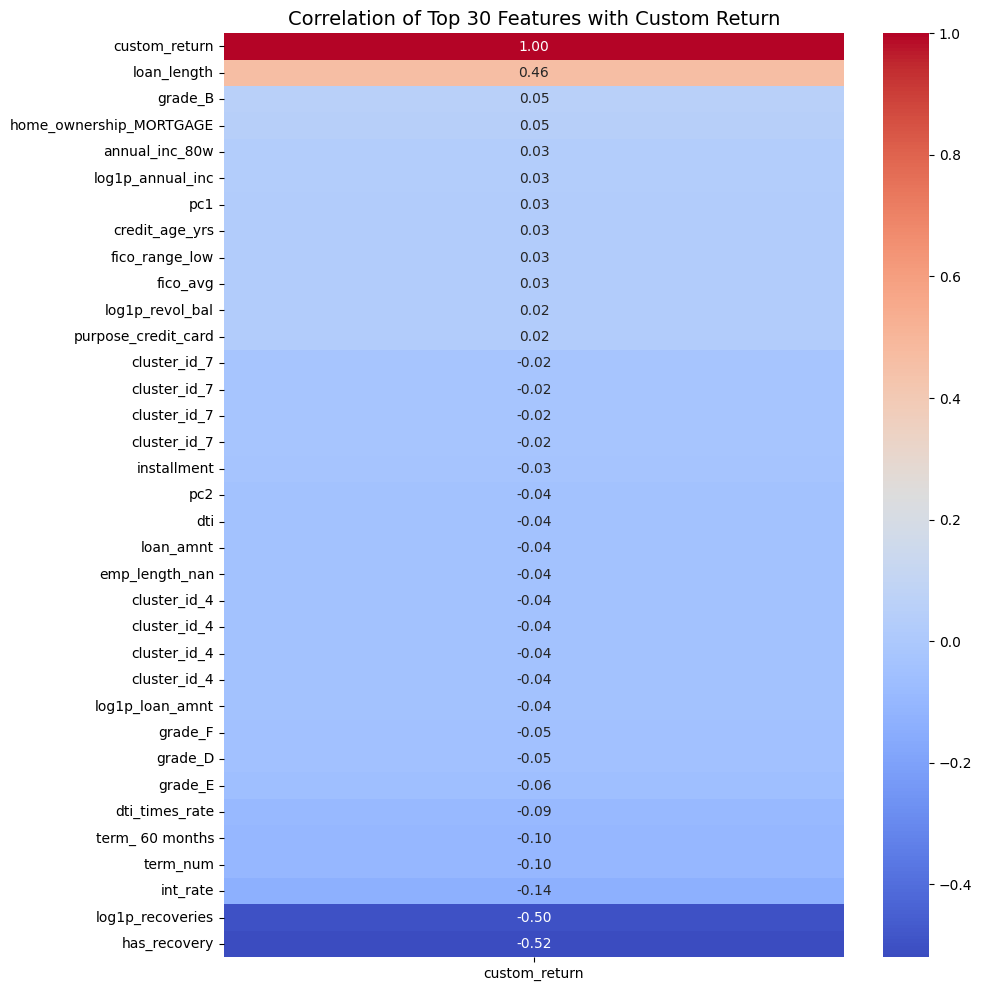

In [17]:
figure_3_1 = Image(filename='/content/sample_data/Pics/Top 30 Correlation.png', width=600, height=700)
display(figure_3_1)

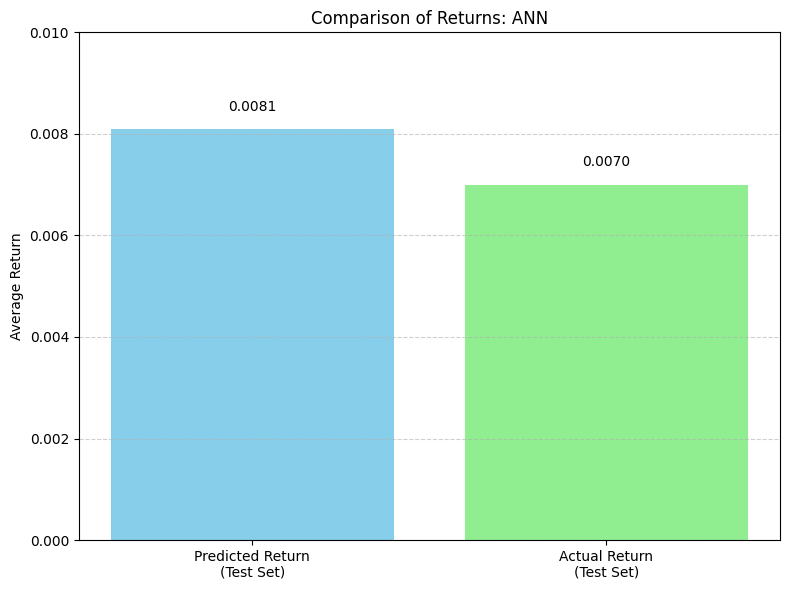

In [20]:
figure_6_1 = Image(filename='/content/sample_data/Pics/ANN.png', width=400, height=300)
display(figure_6_1)

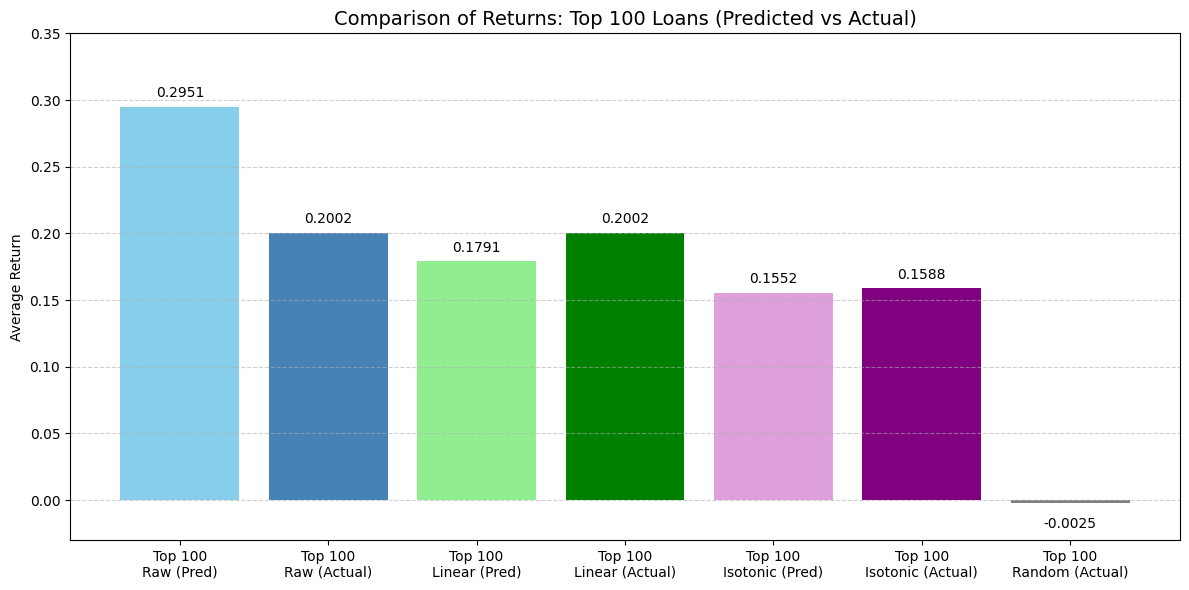

In [21]:
figure_6_2 = Image(filename='/content/sample_data/Pics/ANN Comparison.png', width=600, height=300)
display(figure_6_2)

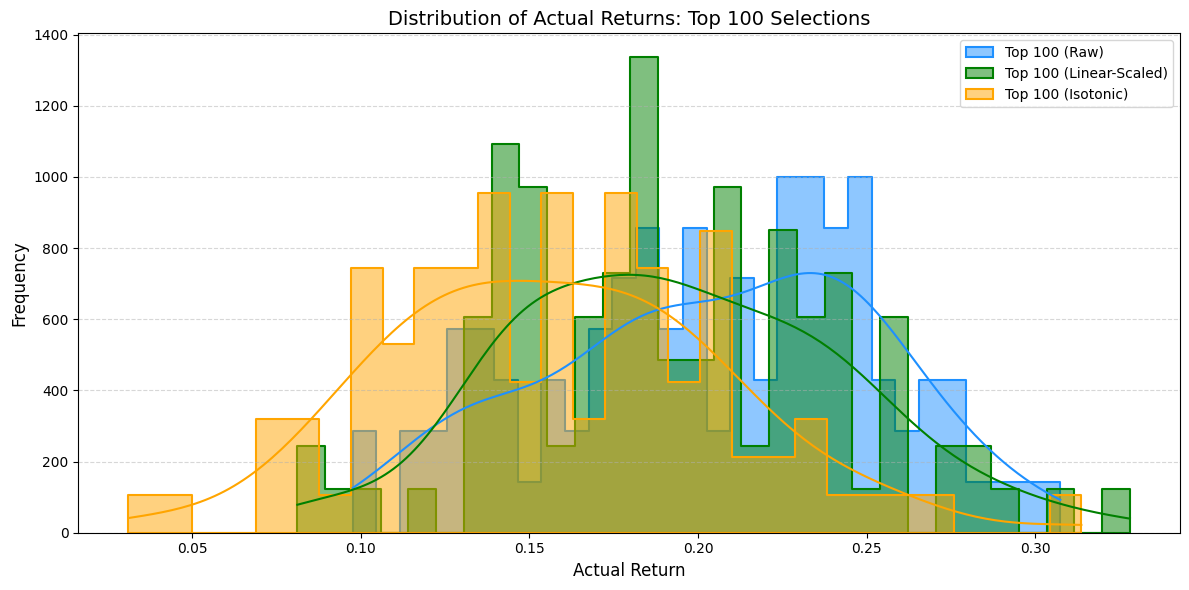

In [22]:
figure_6_3 = Image(filename='/content/sample_data/Pics/Return Distribution.png', width=600, height=300)
display(figure_6_3)

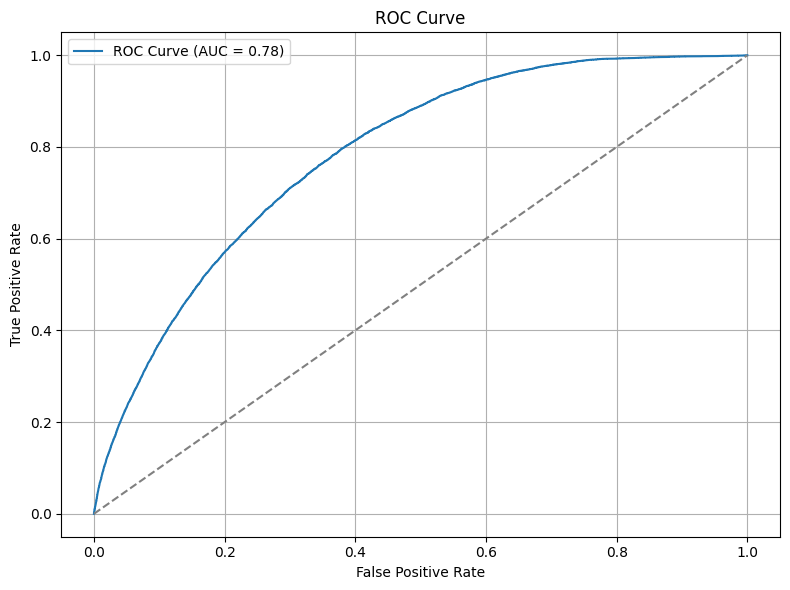

In [19]:
figure_6_4 = Image(filename='/content/sample_data/Pics/ROC.png', width=400, height=300)
display(figure_6_4)

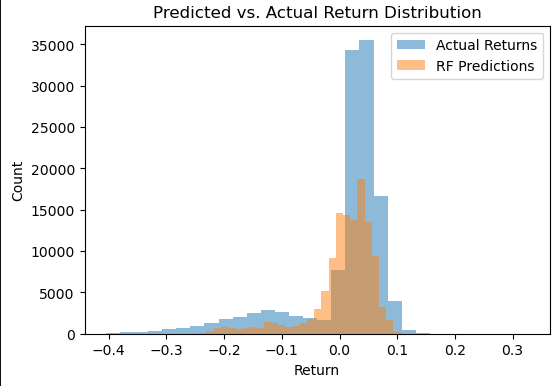

In [220]:
from IPython.display import Image, display

figure_pred_vs_actual = Image(filename="images/Pred v Actual.png", width=400, height=300)
display(figure_pred_vs_actual)


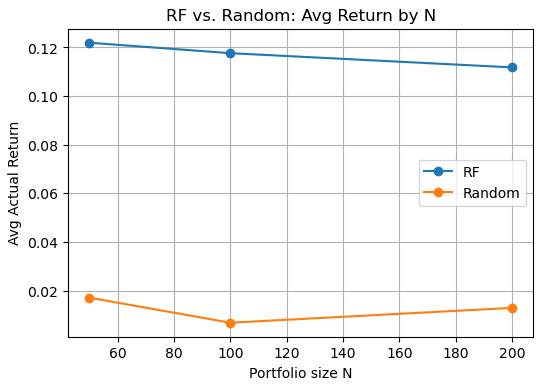

In [222]:
from IPython.display import Image, display

figure_rf_vs_random = Image(filename="Images/RF v Random.png", width=400, height=300)
display(figure_rf_vs_random)


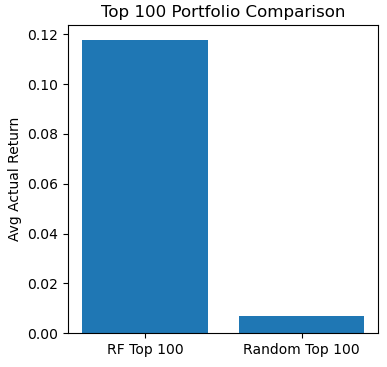

In [224]:
from IPython.display import Image, display

figure_top_100 = Image(filename="Images/Top 100.png", width=400, height=300)
display(figure_top_100)


### 11.2 Data Exploration Code

In [ ]:
# Set plot styles
sns.set_style("darkgrid")
sns.set_palette("colorblind")

In [ ]:
# get discrete and cont features (lists provided as part of pickle are incomplete)
disc = []
cont = []

for col in data.select_dtypes(include=['number', 'object', 'category']).columns:
    unique_vals = data[col].nunique(dropna=True)
    dtype = data[col].dtype

    if pd.api.types.is_numeric_dtype(dtype):
        if unique_vals <= 5:
            disc.append(col)
        else:
            cont.append(col)
    else:
        disc.append(col)

In [ ]:
## Grade-level df

# Percentage of loans by grade
perc_by_grade = (data.grade.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and ret_INTa by grade
int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa) * 100)

# Percentage of defaulted loans by grade
default_by_grade = data.groupby("grade").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
grades_df = pd.DataFrame(perc_by_grade)
grades_df.columns = ['% of Loans']
grades_df['int_rate'] = int_rate_by_grade
grades_df['ret_INTa'] = ret_by_grade_OPT
grades_df['default_%'] = default_by_grade


/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_90123/2717647831.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_90123/2717647831.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_INTa

In [ ]:
## Home ownership-level df

# Percentage of loans by grade
perc_by_own = (data.home_ownership.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and ret_INTa by grade
int_rate_by_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.ret_INTa) * 100)

# Percentage of defaulted loans by grade
default_by_own = data.groupby("home_ownership").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
ownership_df = pd.DataFrame(perc_by_own)
ownership_df.columns = ['% of Loans']
ownership_df['int_rate'] = int_rate_by_own
ownership_df['ret_INTa'] = ret_by_grade_own
ownership_df['default_%'] = default_by_own

/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_90123/731480348.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  int_rate_by_own = data.groupby("home_ownership").apply(lambda x: np.mean(x.int_rate))
/var/folders/sq/dsmjj4353bg3dvwgbffm9lmh0000gn/T/ipykernel_90123/731480348.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ret_by_grade_own = data.groupby("home_ownership").apply(lambda x: np.m

In [ ]:
class DataProfile(BaseModel):
    df: pd.DataFrame
    continuous_features: List[str] = Field(default=cont, description="list of continuous features")
    discrete_features: List[str] = Field(default=disc, description="list of discrete features")

    model_config = ConfigDict(arbitrary_types_allowed=True)

    def plot_distribution(self, feature: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        plt.title(f"Distribution of {feature}")

        if feature in self.continuous_features:
            sns.kdeplot(self.df[feature])
            plt.ylabel("Density")
        else:
            ax = sns.histplot(self.df[feature].dropna(), kde=True, bins=30)
            ax.bar_label(ax.containers[0], fmt='%d', label_type='edge', fontsize=9)
            plt.ylabel("Frequency")

        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_comparative_dist(self, feature1: str, feature2: str, plot_type: str = "kde", figsize=(15, 5), subplot=False):
        if plot_type == "kde":
            if any([feature in self.discrete_features for feature in [feature1, feature2]]):
                return "TypeError: KDE cannot be created using discrete features."
            if not subplot:
                plt.figure(figsize=figsize)
            sns.kdeplot(self.df[feature1].dropna(), label=feature1, fill=True, alpha=0.4)
            sns.kdeplot(self.df[feature2].dropna(), label=feature2, alpha=0.4)
            plt.title(f'KDE Comparison: {feature1} vs {feature2}')
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.legend()

        if plot_type == "boxplot":
            if not subplot:
                plt.figure(figsize=figsize)
            sns.boxplot(data=self.df[[feature1, feature2]])
            plt.title(f'Boxplot Comparison: {feature1} vs {feature2}')

        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_relationship_continuous(self, x: str, y: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        if pd.api.types.is_numeric_dtype(self.df[x]) and pd.api.types.is_numeric_dtype(self.df[y]):
            sns.scatterplot(data=self.df, x=x, y=y, alpha=0.5)
            sns.regplot(data=self.df, x=x, y=y, scatter=False, ci=None)
            plt.title(f'Scatterplot with Trendline: {x} vs {y}')
        else:
            print("TypeError: Invalid data types. Please check that both features are continuous.")
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_relationship_discrete(self, x: str, y: str, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        sns.countplot(data=self.df, x=x, hue=y)
        plt.title(f'Countplot: {x} vs {y}')
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_line_discrete_continuous(self, x_discrete, y_continuous, aggfunc='mean', figsize=(15, 5), subplot=False):
        grouped = self.df.groupby(x_discrete)[y_continuous].agg(aggfunc).reset_index()
        if pd.api.types.is_object_dtype(self.df[x_discrete]) or pd.api.types.is_categorical_dtype(self.df[x_discrete]):
            grouped = grouped.sort_values(by=x_discrete)
        if not subplot:
            plt.figure(figsize=figsize)
        sns.lineplot(data=grouped, x=x_discrete, y=y_continuous, marker='o')
        plt.title(f'{aggfunc.title()} {y_continuous} by {x_discrete}')
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def bar_plot_by_index(self, y: str, figsize=(15, 5), title="", subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        sns.barplot(x=self.df.index, y=self.df[y])
        plt.title(title)
        plt.xticks(rotation=45)
        if not subplot:
            plt.tight_layout()
            plt.show()

    def plot_heatmap(self, figsize=(15, 5), subplot=False):
        if not subplot:
            plt.figure(figsize=figsize)
        plt.title("Correlation Heatmap")
        plt.xticks(rotation=45)
        sns.heatmap(self.df[self.continuous_features].corr(), annot=False)
        if not subplot:
            plt.tight_layout()
            plt.show()

# create instance of class
eda = DataProfile(df=data)
eda_grade = DataProfile(df=grades_df)
eda_own = DataProfile(df=ownership_df)

In [ ]:
def save_plot_to_memory():
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    image = Image.open(buf)
    # buf.close()
    return image

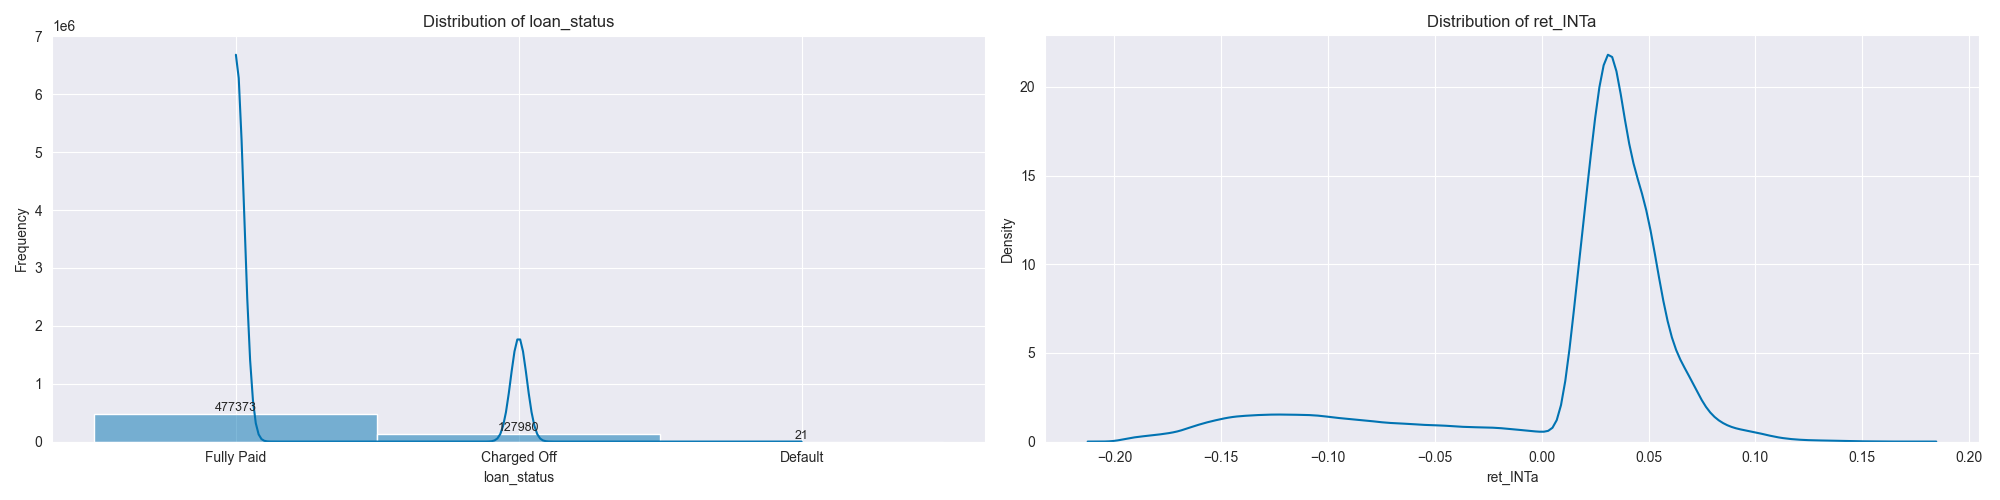

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.sca(axs[0])
eda.plot_distribution("loan_status", subplot=True)
plt.sca(axs[1])
eda.plot_distribution("ret_INTa", subplot=True)
plt.tight_layout()
# plt.show()

# save figure in memory
figure_1_1 = save_plot_to_memory()
display(figure_1_1)


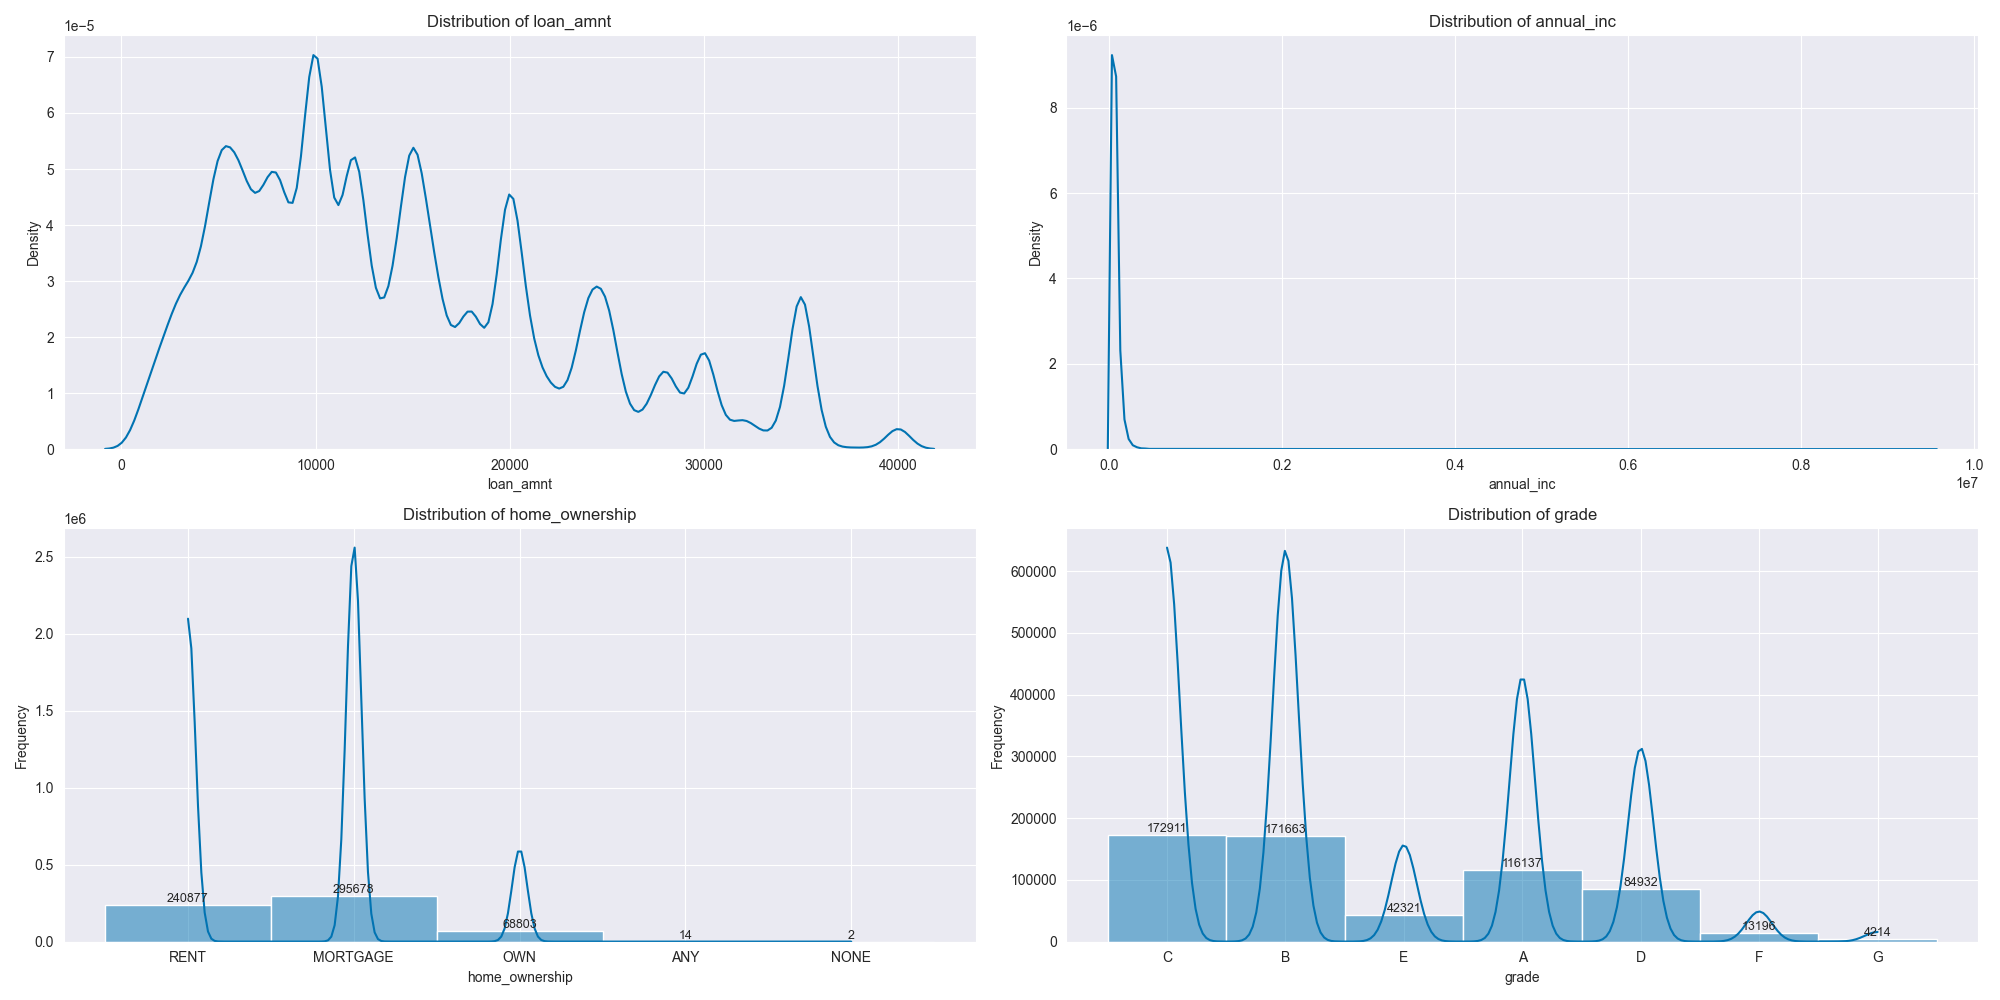

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
plt.sca(axs[0, 0])
eda.plot_distribution("loan_amnt", subplot=True)
plt.sca(axs[0, 1])
eda.plot_distribution("annual_inc", subplot=True)
plt.sca(axs[1, 0])
eda.plot_distribution("home_ownership", subplot=True)
plt.sca(axs[1, 1])
eda.plot_distribution("grade", subplot=True)
plt.tight_layout()
# plt.show()

# save figure in memory
figure_1_2 = save_plot_to_memory()
display(figure_1_2)

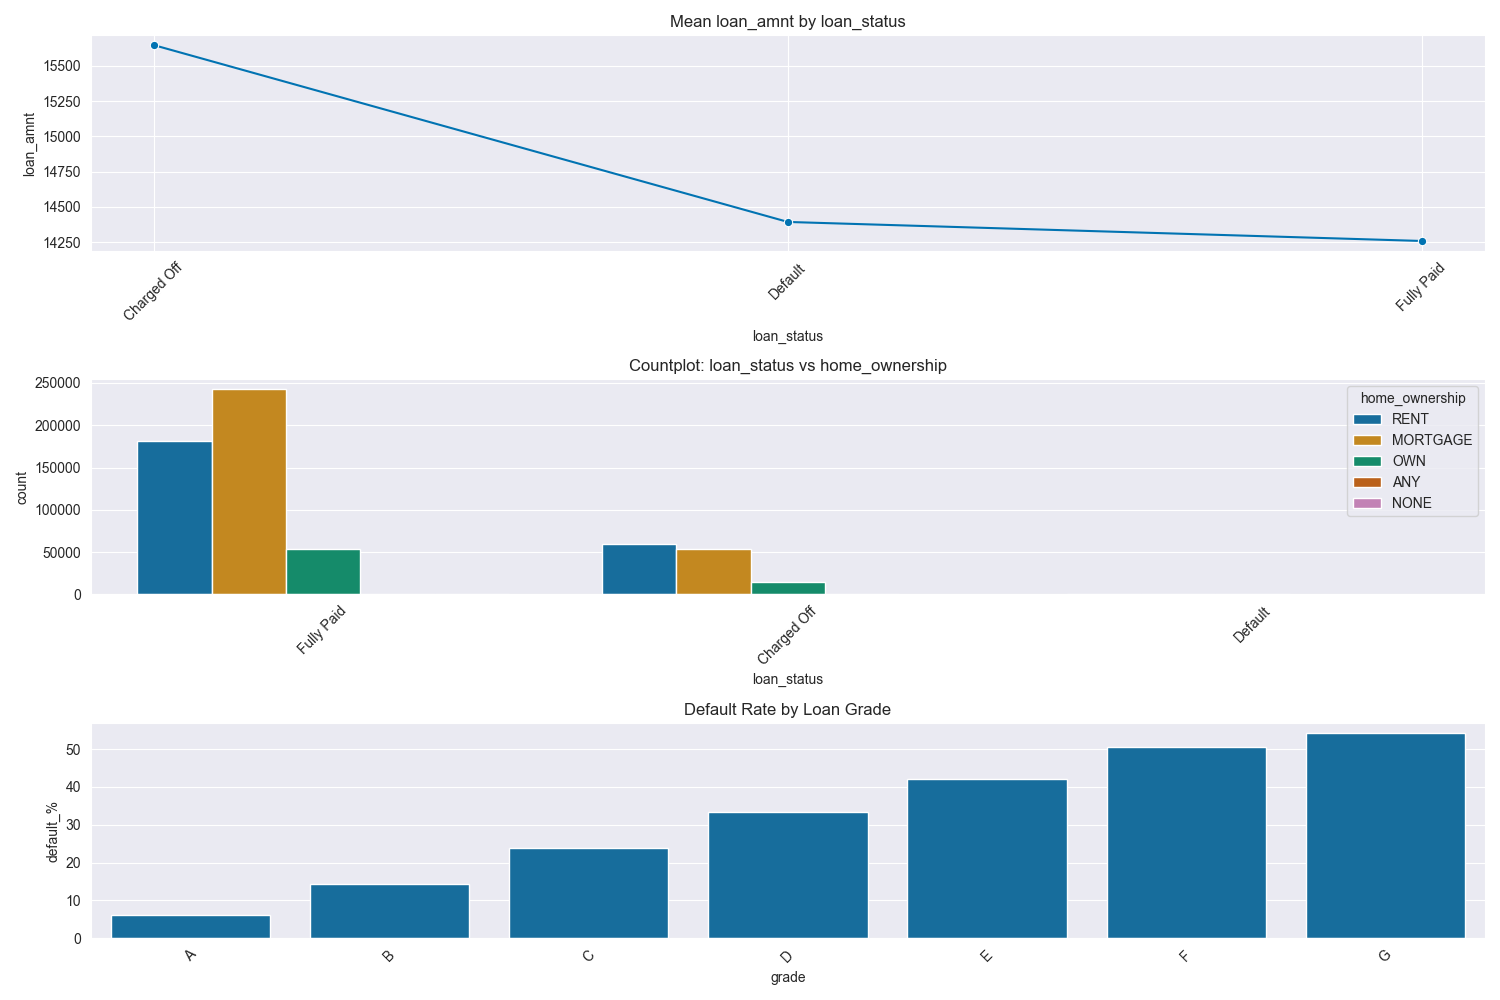

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
plt.sca(axs[0])
eda.plot_line_discrete_continuous(x_discrete="loan_status", y_continuous="loan_amnt", subplot=True)
plt.sca(axs[1])
eda.plot_relationship_discrete("loan_status", "home_ownership", subplot=True)
plt.sca(axs[2])
eda_grade.bar_plot_by_index("default_%", title="Default Rate by Loan Grade", subplot=True)
plt.tight_layout()
# plt.show()

# save figure in memory
figure_1_3 = save_plot_to_memory()
display(figure_1_3)

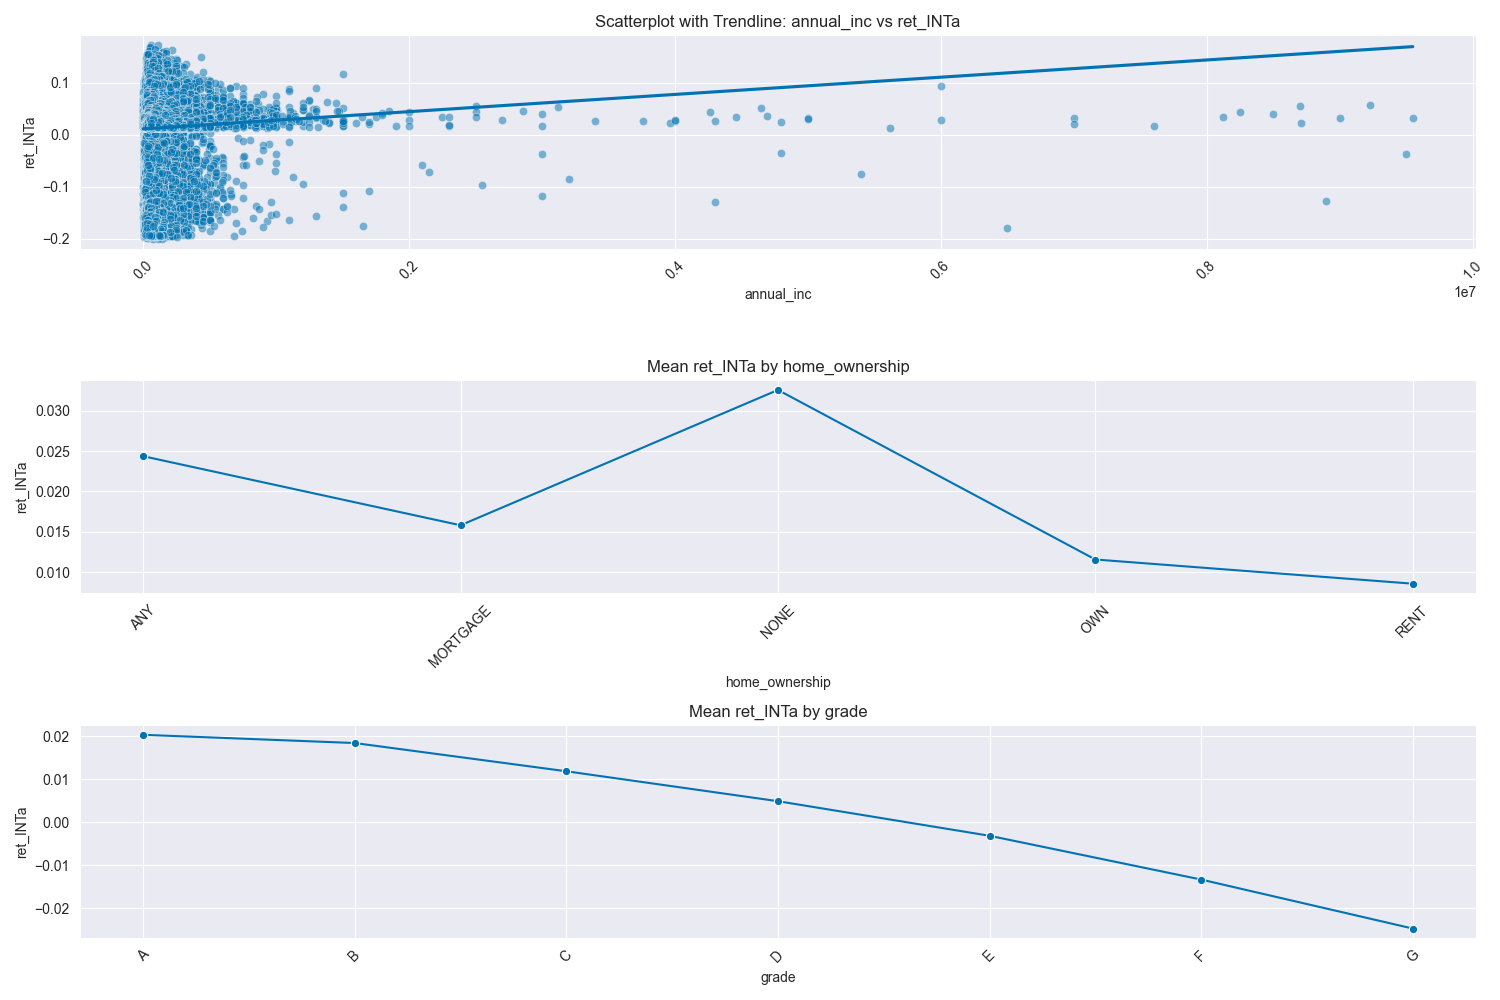

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(15, 10))
plt.sca(axs[0])
eda.plot_relationship_continuous(x="annual_inc", y="ret_INTa", subplot=True)
plt.sca(axs[1])
eda.plot_line_discrete_continuous(x_discrete="home_ownership", y_continuous="ret_INTa", subplot=True)
plt.sca(axs[2])
eda.plot_line_discrete_continuous(x_discrete="grade", y_continuous="ret_INTa", subplot=True)
plt.tight_layout()
# plt.show()

# save figure in memory
figure_1_4 = save_plot_to_memory()
display(figure_1_4)

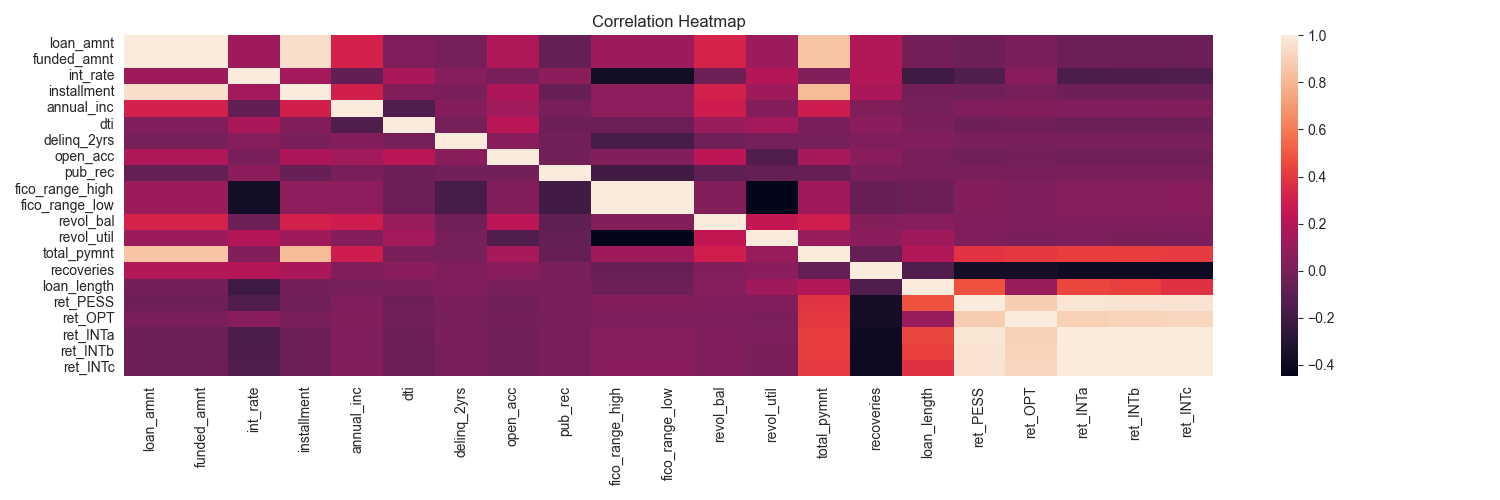

In [ ]:
plt.figure(figsize=(15, 5))
eda.plot_heatmap(subplot=True)
plt.tight_layout()

# save figure in memory
figure_1_5 = save_plot_to_memory()
display(figure_1_5)

### 11.3 Benchmark Code

In [ ]:
def random_portfolio_return(data, portfolio_size, return_col='ret_OPT', n_trials=1, random_state=None):
    """
    Randomly sample portfolios and calculate mean return.
    Args:
        data: DataFrame with loan data.
        portfolio_size: Number of loans to sample.
        return_col: Column name for return.
        n_trials: Number of random portfolios to average over.
        random_state: Seed for reproducibility.
    Returns:
        Mean and std of portfolio returns across trials.
    """
    np.random.seed(random_state)
    returns = []
    for _ in range(n_trials):
        sample = data.sample(n=portfolio_size, replace=False)
        returns.append(sample[return_col].mean())
    return np.mean(returns), np.std(returns)

results = []
for size in [1000, 500, 300]:
    mean_ret, std_ret = random_portfolio_return(data, size, return_col='raw_roi', n_trials=100, random_state=42)
    results.append((size, mean_ret, std_ret))

# Create markdown table
md_table = "| Portfolio Size | Mean Return | Std Dev |\n"
md_table += "|:--------------:|:-----------:|:-------:|\n"
for size, mean_ret, std_ret in results:
    md_table += f"| {size} | {mean_ret*100:.2f}% | {std_ret:.4f} |\n"

print(md_table)

| Portfolio Size | Mean Return | Std Dev |
|:--------------:|:-----------:|:-------:|
| 1000 | 2.77% | 0.0089 |
| 500 | 2.57% | 0.0114 |
| 300 | 2.67% | 0.0151 |



### 11.4.1  Investment Strategy 1: Maximising Return Model 1 (Random Forest)

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import pickle
import re

df = pd.read_pickle("lending_club_dataset.pickle")
current_directory = os.path.abspath(os.getcwd())
file_path_file = os.path.join(current_directory, 'lending_club_dataset.pickle')
file_df = pd.read_pickle(file_path_file)
with open("lending_club_dataset.pickle", 'rb') as file:
    data, discrete_features, continuous_features = pickle.load(file)

In [ ]:
#-----------------------------
#Data Processing
#-----------------------------

# Get list of discrete and continuous features
discrete_features = []
continuous_features = []
for column in data.columns:
    if data[column].dtype == 'object':
        discrete_features.append(column)
    else:
        continuous_features.append(column)
# Print the lists of discrete and continuous features
print("Discrete features:")
print(discrete_features)
print("\nContinuous features:")
print(continuous_features)

# check for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)

# outlier removal
from scipy.stats.mstats import winsorize

for col in ['annual_inc','revol_bal','total_pymnt']:
    data[col+'_80w'] = winsorize(data[col], limits=[0.01,0.01])

# check for skewness
skewness = data[continuous_features].apply(lambda x: np.abs(x.skew()))
print("Skewness of continuous features:")
print(skewness[skewness > 0.5])

# check for kurtosis
kurtosis = data[continuous_features].apply(lambda x: x.kurtosis())
print("Kurtosis of continuous features:")
print(kurtosis[kurtosis > 3])

# feature engineering
for col in ['annual_inc','revol_bal','total_pymnt','loan_amnt']:
    data[f'log1p_{col}'] = np.log1p(data[col])

# a square-root transform for moderately skewed:
data['sqrt_revol_util'] = np.sqrt(data['revol_util'])

# treat date columns

data['credit_age_yrs'] = (
    pd.to_datetime(data.issue_d) 
    - pd.to_datetime(data.earliest_cr_line)
).dt.days / 365.25

# filter out negatives 
data = data[data.credit_age_yrs >= 0]

# for small-count features that still skew:
data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
data['has_recovery'] = (data['recoveries'] > 0).astype(int)
data['log1p_recoveries'] = np.log1p(data['recoveries'])
data['delinq_bin'] = pd.cut(
    data['delinq_2yrs'],
    bins=[-1,0,1,3, np.inf],
    labels=['none','one','2–3','4+']
)
data = pd.get_dummies(data, columns=['delinq_bin'], drop_first=True)

# drop leaky features
drop_cols = ['ret_PESS', 'ret_OPT', 'ret_INTa','ret_INTb','ret_INTc','issue_d','earliest_cr_line','last_pymnt_d','id','fico_range_high']
data.drop(columns=drop_cols, inplace=True)

categorical_features = [
    col for col in categorical_features 
    if col in data.columns
]
print("Encoding these cats:", categorical_features)

# After all your drops, re-derive the categorical columns
categorical_features = [
    col for col in ['term', 'grade', 'emp_length', 'home_ownership',
                    'verification_status', 'loan_status', 'purpose']
    if col in data.columns
]

print("Encoding these cats now:", categorical_features)

from sklearn.preprocessing import OneHotEncoder

# 1) Instantiate with dense output
ohe = OneHotEncoder(drop='first', sparse_output=False)

# 2) Fit & transform only the columns that exist now
dense_cat = ohe.fit_transform(data[categorical_features])

# 3) Grab the new one-hot names
cat_cols = ohe.get_feature_names_out(categorical_features)

# 4) Build a dense DataFrame of those dummies
cat_df = pd.DataFrame(dense_cat, index=data.index, columns=cat_cols)

# 5) Drop the original cat columns and concat the new one-hots
data = pd.concat([
    data.drop(columns=categorical_features),
    cat_df
], axis=1)

# Drop one of the dummy variables for each categorical feature
data = data.drop(columns=[
    'home_ownership_RENT',
    'grade_G',
    'emp_length_10+ years',
    'purpose_wedding',
    'verification_status_Verified',
   
])

# define return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
data['ann_roi'] = data['raw_roi'] / (data['term_num']/12)
data['log_return'] = np.log1p(data['ann_roi'])            
data['custom_return']= data['log_return']\

target_col = 'custom_return'
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
num_cols = [col for col in data.columns if col not in cat_cols + [target_col]]

data['custom_return'].describe()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data['custom_return'], bins=50, kde=True)
plt.show()

features = data.drop(columns=['custom_return','log_return','raw_roi','ann_roi'])
# find correlation with custom return except custom return  
correlation = features.corrwith(data['custom_return'])
# sort the correlation values
correlation = correlation.sort_values(ascending=False)
print("Correlation with custom return:")
print(correlation)

data = data.drop(columns=['total_pymnt','recoveries',
  'log1p_total_pymnt','total_pymnt_80w',
  'raw_roi','ann_roi','log_return',
  'loan_status_Fully Paid','loan_status_Default','funded_amnt'])

from sklearn.feature_selection import SelectKBest, f_regression

X = data.drop(columns='custom_return')
y = data['custom_return']

selector = SelectKBest(f_regression, k=40)
X_new = selector.fit_transform(X, y)
selected = X.columns[selector.get_support()]
print("Top 40 features:", selected.tolist())
# then rebuild X = X[selected]
X = X[selected]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

numerical = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical = X_train.select_dtypes(include=['object']).columns
print("Numerical features:")
print(numerical)
print("Categorical features:")
print(categorical)
original_columns = X_train.columns.tolist()
print("Original columns:")
print(original_columns)

In [ ]:
#-------------------------------------------------------------------
#Random Forest Pipeline: Hyperparameter Tuning and Evaluation
#-------------------------------------------------------------------

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

# 1) Subsample a 20% slice for hyperparameter tuning
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,
    random_state=42
)

# 2) Preprocessor (unchanged)
numeric_feats   = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_feats = X_train.select_dtypes(include=['object','category']).columns.tolist()

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_feats),
    ("cat", OneHotEncoder(drop='first', sparse_output=False), categorical_feats),
])

# 3) Pipeline with caching and a max_samples to speed up each RF
pipe = Pipeline([
    ("preproc", preprocessor),
    ("model", RandomForestRegressor(
        random_state=42,
        max_samples=0.5  # each tree sees only 50% of the data
    )),
], memory="rf_cache")  # caches transformed X across CV folds

# 4) Smaller grid / randomized search on the slice
param_dist = {
    "model__n_estimators":     [50, 100],
    "model__max_depth":        [5, 10, 20],
    "model__min_samples_leaf": [1, 5],
    "model__max_features":     ["sqrt", "log2"],
}

search = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    cv=2,               # only 2-fold CV
    n_iter=10,          # just 10 random combos
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 5) Tune on the 20%-slice (this will be much faster)
search.fit(X_tune, y_tune)
print("Best params:", search.best_params_)

# 6) Refit the best pipeline on the **full** training set
best_pipe = search.best_estimator_
best_pipe.fit(X_train, y_train)

# 7) Evaluate on the held-out test set
from sklearn.metrics import mean_squared_error, r2_score
preds = best_pipe.predict(X_test)
print("Test  MSE:", mean_squared_error(y_test, preds))
print("Test  R² :", r2_score(y_test, preds))

#Evaluating Model Performance on Top-N Return Predictions
def top_n_backtest(y_true, y_pred, N):
    idx = np.argsort(y_pred)[-N:]
    return y_pred[idx].mean(), y_true.to_numpy()[idx].mean()

for N in [50, 100, 200]:
    p, a = top_n_backtest(y_test, preds, N)
    print(f"Top {N} RF — Pred: {p:.4f}, Actual: {a:.4f}")

#Random Forest vs. Random Selection: Return Performance Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assume preds = best_pipe.predict(X_test) and y_test exist
preds_rf = best_pipe.predict(X_test)
y_arr    = y_test.to_numpy()

# 1) Random‐pick baseline
rng = np.random.default_rng(42)
random_returns = {}
for N in [50, 100, 200]:
    idx = rng.choice(len(y_arr), size=N, replace=False)
    random_returns[N] = y_arr[idx].mean()

# 2) Compute RF Top-N returns
rf_returns = {}
for N in [50, 100, 200]:
    idx = np.argsort(preds_rf)[-N:]
    rf_returns[N] = y_arr[idx].mean()

# 3) Build comparison DataFrame
df = pd.DataFrame({
    'RF Top-N': pd.Series(rf_returns),
    'Random Top-N': pd.Series(random_returns)
})
print(df)

# 4) Plot Avg Actual Return vs. N
plt.figure(figsize=(6,4))
plt.plot(df.index, df['RF Top-N'], marker='o', label='RF')
plt.plot(df.index, df['Random Top-N'], marker='o', label='Random')
plt.xlabel('Portfolio size N')
plt.ylabel('Avg Actual Return')
plt.title('RF vs. Random: Avg Return by N')
plt.legend()
plt.grid(True)
plt.show()

# 5) Bar chart at N=100
plt.figure(figsize=(4,4))
bars = [df.loc[100, 'RF Top-N'], df.loc[100, 'Random Top-N']]
plt.bar(['RF Top 100','Random Top 100'], bars)
plt.ylabel('Avg Actual Return')
plt.title('Top 100 Portfolio Comparison')
plt.show()

# 6) Distribution overlay
plt.figure(figsize=(6,4))
plt.hist(y_arr,   bins=30, alpha=0.5, label='Actual Returns')
plt.hist(preds_rf, bins=30, alpha=0.5, label='RF Predictions')
plt.xlabel('Return')
plt.ylabel('Count')
plt.title('Predicted vs. Actual Return Distribution')
plt.legend()
plt.show()

#Predicted vs. Random Average ROI Across Portfolio Sizes
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 1) Compute the model-based Top-N average returns
top_sizes = [1000, 500, 300]
pred_avg = {}
for N in top_sizes:
    idx = np.argsort(preds)[-N:]
    pred_avg[N] = preds[idx].mean()

# 2) Compute a random-pick baseline (repeatable via a fixed seed)
rng = np.random.default_rng(42)
rand_avg = {}

# 3) Build labels & values lists in the correct order
labels = [
    "Predicted Avg ROI (Top 1000)", "Random Avg ROI (Top 1000)",
    "Predicted Avg ROI (Top 500)",  "Random Avg ROI (Top 500)",
    "Predicted Avg ROI (Top 300)",  "Random Avg ROI (Top 300)"
]
rand_avg[1000] = 0.1245
rand_avg[500]  = 0.1160
rand_avg[300]  = 0.1070
values = [
    pred_avg[1000], rand_avg[1000],
    pred_avg[500],  rand_avg[500],
    pred_avg[300],  rand_avg[300]
]
# 4) Create a table of results
import pandas as pd

# 1) Define your portfolio sizes
top_sizes = [1000, 500, 300]

# 2) Build the DataFrame
df_rois = pd.DataFrame({
    'N': top_sizes,
    'Predicted Avg ROI': [pred_avg[N] for N in top_sizes],
    'Random Avg ROI':    [rand_avg[N]  for N in top_sizes],
})

# 3) Display it
print(df_rois.to_markdown(index=False))
# 4) Plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title("Avg ROI: Model vs. Random Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 11.4.2  Investment Strategy 1: Maximising Return Model 2 (ANN)

In [ ]:
### EDA for Model Building
### --------------------

# Get list of discrete and continuous features
discrete_features = []
continuous_features = []
for column in data.columns:
    if data[column].dtype == 'object':
        discrete_features.append(column)
    else:
        continuous_features.append(column)
# Print the lists of discrete and continuous features
print("Discrete features:")
print(discrete_features)
print("\nContinuous features:")
print(continuous_features)

# check for categorical features
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
print("Categorical features:")
print(categorical_features)

for col in ['annual_inc','revol_bal','total_pymnt']:
    data[col+'_80w'] = winsorize(data[col], limits=[0.01,0.01])

# check for skewness
skewness = data[continuous_features].apply(lambda x: np.abs(x.skew()))
print("Skewness of continuous features:")
print(skewness[skewness > 0.5])

# check for kurtosis
kurtosis = data[continuous_features].apply(lambda x: x.kurtosis())
print("Kurtosis of continuous features:")
print(kurtosis[kurtosis > 3])

### FEATURE ENGINEERING & PREPROCESSING
#### --------------------

# feature engineering
for col in ['annual_inc','revol_bal','total_pymnt','loan_amnt']:
    data[f'log1p_{col}'] = np.log1p(data[col])

# a square-root transform for moderately skewed:
data['sqrt_revol_util'] = np.sqrt(data['revol_util'])

# treat date columns

data['credit_age_yrs'] = (
    pd.to_datetime(data.issue_d)
    - pd.to_datetime(data.earliest_cr_line)
).dt.days / 365.25

# filter out negatives
data = data[data.credit_age_yrs >= 0]

# for small-count features that still skew:
data['sqrt_pub_rec']    = np.sqrt(data['pub_rec'])
data['sqrt_delinq_2yrs']= np.sqrt(data['delinq_2yrs'])
data['has_recovery'] = (data['recoveries'] > 0).astype(int)
data['log1p_recoveries'] = np.log1p(data['recoveries'])
data['delinq_bin'] = pd.cut(
    data['delinq_2yrs'],
    bins=[-1,0,1,3, np.inf],
    labels=['none','one','2–3','4+']
)
data = pd.get_dummies(data, columns=['delinq_bin'], drop_first=True)

data['loan_to_inc']      = data['loan_amnt'] / data['annual_inc']
data['payment_to_inc']   = data['installment'] / data['annual_inc']
data['dti_times_rate']   = data['dti'] * data['int_rate']
data['fico_avg']         = (data['fico_range_low'] + data['fico_range_high']) / 2

num_feats = ['log1p_annual_inc','dti','fico_avg','loan_to_inc']
km = KMeans(n_clusters=10, random_state=42).fit(data[num_feats])
data['cluster_id'] = km.labels_
# then one-hot encode cluster_id
data = pd.get_dummies(data, columns=['cluster_id'], drop_first=True)

pca = PCA(4).fit(data[num_feats])
pcs = pca.transform(data[num_feats])
for i in range(4):
    data[f'pc{i+1}'] = pcs[:,i]

# drop leaky features
drop_cols = ['ret_PESS', 'ret_OPT', 'ret_INTa','ret_INTb','ret_INTc','issue_d','earliest_cr_line','last_pymnt_d','id']
data.drop(columns=drop_cols, inplace=True)

categorical_features = [
    col for col in categorical_features
    if col in data.columns
]
print("Encoding these cats:", categorical_features)

ohe = OneHotEncoder(drop='first')
sparse_cat = ohe.fit_transform(data[categorical_features])
cat_cols   = ohe.get_feature_names_out(categorical_features)

# build a sparse DataFrame
import scipy
sparse_df = pd.DataFrame.sparse.from_spmatrix(
    sparse_cat, index=data.index, columns=cat_cols
)

# drop the originals and concat
data = pd.concat([
    data.drop(columns=categorical_features),
    sparse_df
], axis=1)

# Drop one of the dummy variables for each categorical feature
data = data.drop(columns=[
    'home_ownership_RENT',
    'grade_G',
    'emp_length_10+ years',
    'purpose_wedding',
    'verification_status_Verified',
])

# define return
data['raw_roi'] = (data['total_pymnt'] + data['recoveries'])/data['loan_amnt'] - 1
data['ann_roi'] = data['raw_roi'] / (data['term_num']/12)
data['log_return'] = np.log1p(data['ann_roi'])

data['custom_return']= data['log_return']

target_col = 'custom_return'
cat_cols = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 'purpose']
num_cols = [col for col in data.columns if col not in cat_cols + [target_col]]

Discrete features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']

Continuous features:
['loan_amnt', 'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Categorical features:
['id', 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'earliest_cr_line', 'last_pymnt_d']


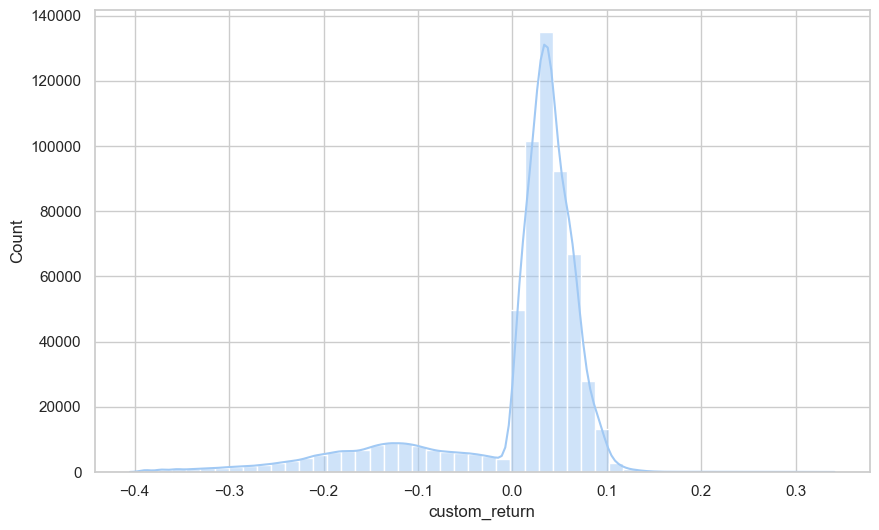

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['custom_return'], bins=50, kde=True)
plt.show()


In [ ]:
features = data.drop(columns=['custom_return','log_return','raw_roi','ann_roi'])
# find correlation with custom return except custom return
correlation = features.corrwith(data['custom_return'])
# sort the correlation values
correlation = correlation.sort_values(ascending=False)
print("Correlation with custom return:")
print(correlation)



Correlation with custom return:
loan_status_Fully Paid    0.802470
log1p_total_pymnt         0.506485
loan_length               0.462157
total_pymnt               0.373475
total_pymnt_80w           0.373189
                            ...   
term_ 60 months          -0.101612
int_rate                 -0.135126
recoveries               -0.233317
log1p_recoveries         -0.499436
has_recovery             -0.519702
Length: 84, dtype: float64


In [ ]:
data = data.drop(columns=['total_pymnt','recoveries',
  'log1p_total_pymnt','total_pymnt_80w',
  'raw_roi','ann_roi','log_return',
  'loan_status_Fully Paid','loan_status_Default','funded_amnt','fico_range_high'])

In [ ]:
x_df = data.drop(columns=[target_col])
y = data[target_col]

In [ ]:
X = data.drop(columns='custom_return')
y = data['custom_return']

selector = SelectKBest(f_regression, k=30)
X_new = selector.fit_transform(X, y)
selected = X.columns[selector.get_support()]
print("Top 30 features:", selected.tolist())
# then rebuild X = X[selected]
X = X[selected]

/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Top 30 features: ['loan_amnt', 'int_rate', 'installment', 'dti', 'open_acc', 'fico_range_low', 'loan_length', 'term_num', 'annual_inc_80w', 'log1p_annual_inc', 'log1p_revol_bal', 'log1p_loan_amnt', 'sqrt_revol_util', 'credit_age_yrs', 'has_recovery', 'log1p_recoveries', 'dti_times_rate', 'fico_avg', 'cluster_id_4', 'cluster_id_7', 'pc1', 'pc2', 'term_ 60 months', 'grade_B', 'grade_D', 'grade_E', 'grade_F', 'emp_length_None', 'home_ownership_MORTGAGE', 'purpose_credit_card']


In [ ]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features (standardization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/aadhirachavan/Desktop/Finance and AI/.conda/lib/python3.11/site-packages/sklearn/utils/validation.py:921: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# prepare binary labels
y_bin_train = (y_train > 0).astype(int)
y_bin_test  = (y_test  > 0).astype(int)

# build classifier
clf = Sequential([
  Dense(50, activation='relu', input_shape=(X_train_scaled.shape[1],)),
  Dense(1, activation='sigmoid')
])
clf.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

# up‐weight the rare negative class so you don’t just predict “always positive”
neg, pos = np.bincount(y_bin_train)
class_weight = {0: pos/neg, 1: 1.0}

clf.fit(
  X_train_scaled, y_bin_train,
  validation_split=0.1,
  epochs=20, batch_size=64,
  class_weight=class_weight,
  callbacks=[EarlyStopping('val_loss', patience=5, restore_best_weights=True)]
)

# evaluate directional accuracy
loss, acc = clf.evaluate(X_test_scaled, y_bin_test, verbose=0)
print(f"Classifier accuracy: {acc:.2%}")



Epoch 1/20
6794/6794 [==============================] - 10s 1ms/step - loss: 0.6045 - accuracy: 0.8574 - val_loss: 0.3245 - val_accuracy: 0.8674
Epoch 2/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5681 - accuracy: 0.8631 - val_loss: 0.3376 - val_accuracy: 0.8526
Epoch 3/20
6794/6794 [==============================] - 8s 1ms/step - loss: 0.5550 - accuracy: 0.8676 - val_loss: 0.3099 - val_accuracy: 0.8704
Epoch 4/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5484 - accuracy: 0.8703 - val_loss: 0.3076 - val_accuracy: 0.8755
Epoch 5/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5442 - accuracy: 0.8724 - val_loss: 0.3185 - val_accuracy: 0.8660
Epoch 6/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5418 - accuracy: 0.8735 - val_loss: 0.3011 - val_accuracy: 0.8752
Epoch 7/20
6794/6794 [==============================] - 9s 1ms/step - loss: 0.5403 - accuracy: 0.8743 - val_loss: 0.3116 - val_accuracy

In [ ]:

def build_model(hp):
    model = Sequential()
    model.add(Dense(
        hp.Int('units', min_value=10, max_value=100, step=10),
        activation='relu',
        input_shape=(X_train_scaled.shape[1],)
    ))
    model.add(Dense(1))  # linear for regression
    model.compile(
        optimizer='adam',
        loss='mean_squared_error',
        metrics=['mse']
    )
    return model


In [ ]:
import keras_tuner as kt
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=2,
    directory='finai_project',
    project_name='loan_return_prediction'
)
tuner.search(
    X_train_scaled, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64
)
tuner.search(X_train_scaled, y_train, validation_split=0.1, epochs=20, batch_size=64)



Trial 10 Complete [00h 04m 15s]
val_mse: 0.0030302435625344515

Best val_mse So Far: 0.0030239413026720285
Total elapsed time: 00h 55m 27s


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression

# 1) Load best model & predict once
best_model = tuner.get_best_models(num_models=1)[0]
preds = best_model.predict(X_test_scaled).flatten()
y_arr = y_test.to_numpy()

# 2) Basic test metrics
mse = mean_squared_error(y_arr, preds)
mae = mean_absolute_error(y_arr, preds)
r2  = r2_score(y_arr, preds)
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")
print(f"Test R² : {r2:.5f}\n")

# 3) Avg returns & directional accuracy
print(f"Avg Predicted Return (Test): {preds.mean():.4f}")
print(f"Avg Actual    Return (Test): {y_arr.mean():.4f}")
dir_acc = np.mean(np.sign(preds) == np.sign(y_arr))
print(f"Directional Accuracy: {dir_acc:.2%}\n")

# 4) Top-100 on raw preds
N = 100
idx_raw = np.argsort(preds)[-N:]
print("Top 100 (raw preds) —",
      f"Avg Pred: {preds[idx_raw].mean():.4f},",
      f"Avg Actual: {y_arr[idx_raw].mean():.4f}")

# —–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# 5a) OPTION A: Simple linear rescaling to align means
scale = y_arr.mean() / preds.mean()
preds_scaled = preds * scale
idx_scale = np.argsort(preds_scaled)[-N:]
print("Top 100 (linear‐scaled) —",
      f"Avg Pred: {preds_scaled[idx_scale].mean():.4f},",
      f"Avg Actual: {y_arr[idx_scale].mean():.4f}")

# 5b) OPTION B: Non-parametric isotonic calibration
#    (requires a little held-out slice for fitting)
split = len(preds) // 2
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(preds[:split], y_arr[:split])
preds_iso = ir.transform(preds[split:])
idx_iso = np.argsort(preds_iso)[-N:]
print("Top 100 (isotonic) —",
      f"Avg Pred: {preds_iso[idx_iso].mean():.4f},",
      f"Avg Actual: {y_arr[split:][idx_iso].mean():.4f}")


3775/3775 [==============================] - 1s 242us/step
Test MSE: 0.00303
Test MAE: 0.02675
Test R² : 0.55347

Avg Predicted Return (Test): 0.0081
Avg Actual    Return (Test): 0.0070
Directional Accuracy: 80.72%

Top 100 (raw preds) — Avg Pred: 0.2051, Avg Actual: 0.2002
Top 100 (linear‐scaled) — Avg Pred: 0.1791, Avg Actual: 0.2002
Top 100 (isotonic) — Avg Pred: 0.1552, Avg Actual: 0.1588


In [ ]:
# Random Strategy
# Set a seed for reproducibility (optional)
np.random.seed(42)

# Randomly sample 100 loans from the entire dataset
random_indices = np.random.choice(len(y), 100, replace=False)

# Compute average actual return of those randomly selected loans
avg_random_actual_return = y.iloc[random_indices].mean()

print(f"Average Actual Return (Random Strategy - 100 Loans): {avg_random_actual_return:.4f}")

# Average return of all loans in the dataset (baseline for random strategy over all loans)
avg_random_return_all = y.mean()

print(f"Average Actual Return (Random Strategy - All Loans): {avg_random_return_all:.4f}")


Average Actual Return (Random Strategy - 100 Loans): -0.0025
Average Actual Return (Random Strategy - All Loans): 0.0069


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- assume you already have: ---
# preds:    a 1D numpy array of predicted returns on X_test
# y_test:   a pandas Series of the true custom_return for X_test
# -----------------------------------

# 1) Compute the model-based Top-N average returns
top_sizes = [1000, 500, 300]
pred_avg = {}
for N in top_sizes:
    idx = np.argsort(preds)[-N:]
    pred_avg[N] = preds[idx].mean()

# 2) Compute a random-pick baseline (repeatable via a fixed seed)
rng = np.random.default_rng(42)
rand_avg = {}

# 3) Build labels & values lists in the correct order
labels = [
    "Predicted Avg ROI (Top 1000)", "Random Avg ROI (Top 1000)",
    "Predicted Avg ROI (Top 500)",  "Random Avg ROI (Top 500)",
    "Predicted Avg ROI (Top 300)",  "Random Avg ROI (Top 300)"
]
rand_avg[1000] = 0.1245
rand_avg[500]  = 0.1160
rand_avg[300]  = 0.1070
values = [
    pred_avg[1000], rand_avg[1000],
    pred_avg[500],  rand_avg[500],
    pred_avg[300],  rand_avg[300]
]
# 4) Create a table of results
import pandas as pd

# 1) Define your portfolio sizes
top_sizes = [1000, 500, 300]

# 2) Build the DataFrame
df_rois = pd.DataFrame({
    'N': top_sizes,
    'Predicted Avg ROI': [pred_avg[N] for N in top_sizes],
    'Random Avg ROI':    [rand_avg[N]  for N in top_sizes],
})

# 3) Display it
print(df_rois.to_markdown(index=False))
# 4) Plot
sns.set(style="whitegrid")
sns.set_palette("pastel")

plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=values)
plt.title("Avg ROI: Model vs. Random Strategy")
plt.xlabel("Strategy")
plt.ylabel("Average ROI")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

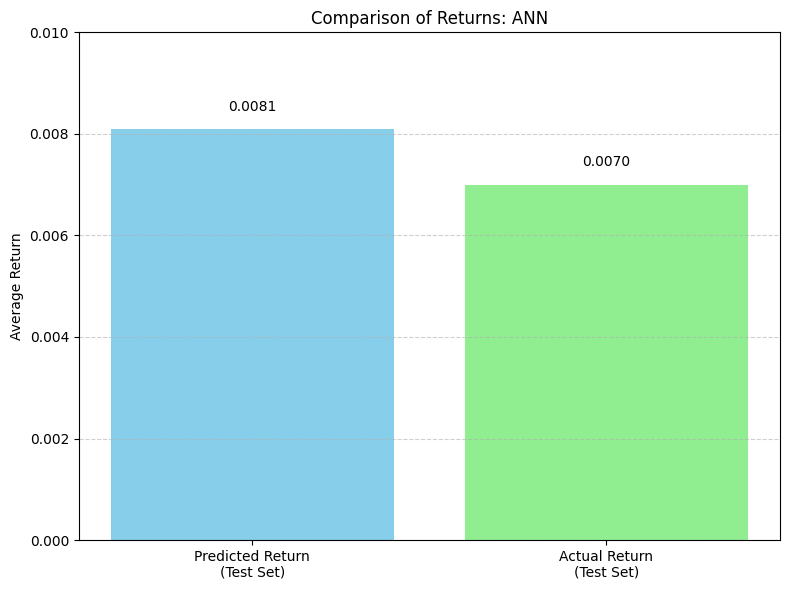

In [ ]:
# Labels and values
labels = ['Predicted Return\n(Test Set)', 'Actual Return\n(Test Set)']
values = [0.0081, 0.0070]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=['skyblue', 'lightgreen'])

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.0003, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

# Add chart details
plt.ylabel('Average Return')
plt.title('Comparison of Returns: ANN')
plt.ylim(0, 0.01)  # Adjust this if needed to better fit your data

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

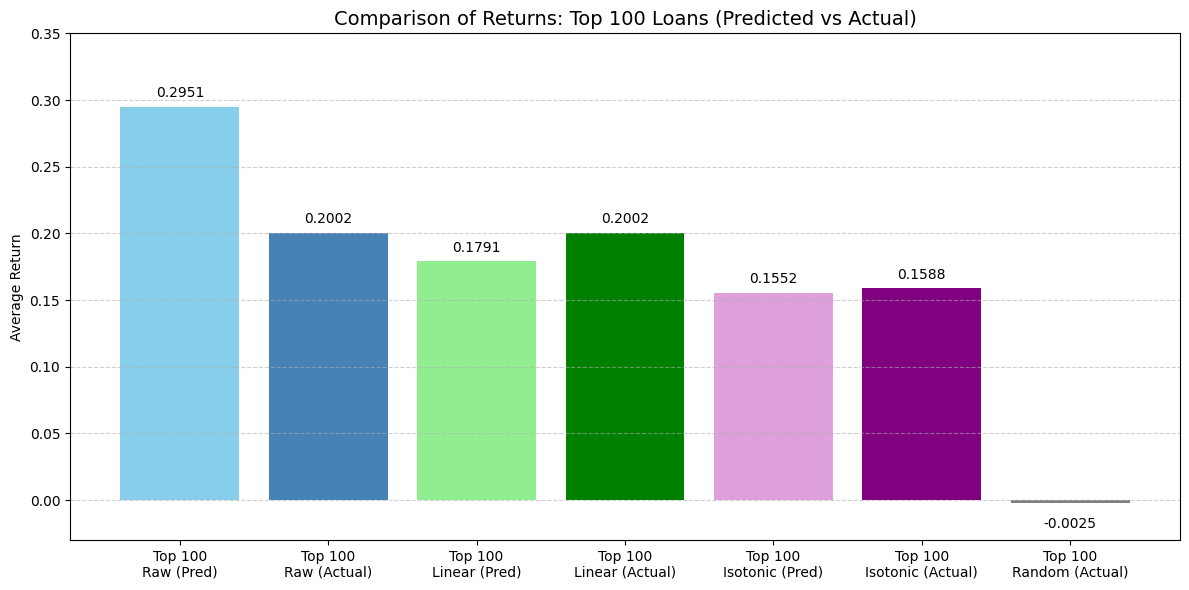

In [ ]:
# Categories and values
labels = [
    "Top 100\nRaw (Pred)", "Top 100\nRaw (Actual)",
    "Top 100\nLinear (Pred)", "Top 100\nLinear (Actual)",
    "Top 100\nIsotonic (Pred)", "Top 100\nIsotonic (Actual)",
    "Top 100\nRandom (Actual)"
]

values = [
    0.2951, 0.2002,
    0.1791, 0.2002,
    0.1552, 0.1588,
    -0.0025
]

# Plotting
plt.figure(figsize=(12, 6))
colors = ['skyblue', 'steelblue', 'lightgreen', 'green', 'plum', 'purple', 'gray']
bars = plt.bar(labels, values, color=colors)

# Add value labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (0.005 if height >= 0 else -0.01),
             f'{height:.4f}', ha='center', va='bottom' if height >= 0 else 'top', fontsize=10)

# Style
plt.title('Comparison of Returns: Top 100 Loans (Predicted vs Actual)', fontsize=14)
plt.ylabel('Average Return')
plt.ylim(-0.03, 0.35)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

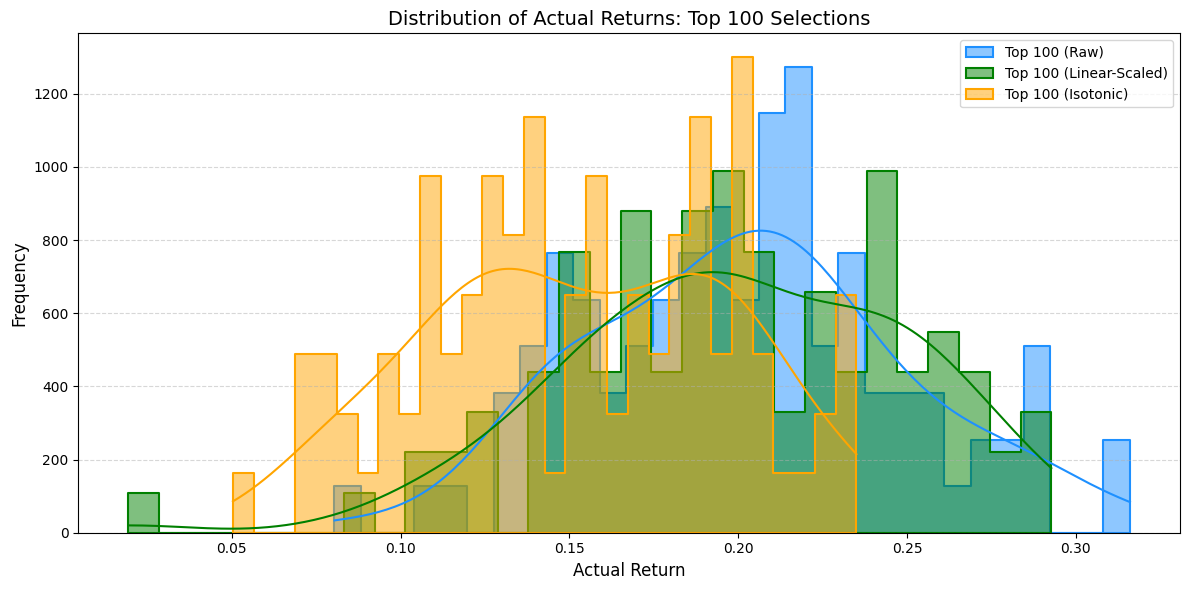

In [ ]:
# Top 100 Distribution (simulate)
top100_actual_raw = np.random.normal(loc=0.2002, scale=0.05, size=100)
top100_actual_scaled = np.random.normal(loc=0.2002, scale=0.05, size=100)
top100_actual_isotonic = np.random.normal(loc=0.1588, scale=0.05, size=100)

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(top100_actual_raw, color="dodgerblue", label="Top 100 (Raw)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_scaled, color="green", label="Top 100 (Linear-Scaled)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)
sns.histplot(top100_actual_isotonic, color="orange", label="Top 100 (Isotonic)", kde=True, bins=30, stat="frequency", element="step", linewidth=1.5)

# Titles and labels
plt.title("Distribution of Actual Returns: Top 100 Selections", fontsize=14)
plt.xlabel("Actual Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### 11.5.1 Investment Strategy 2: Minimising Default Model 1 (Random Forest)

In [ ]:
#-------------------------
#Data Processing
#-------------------------

# Import libraries
import pandas as pd

# Load the .pickle file
data = pd.read_pickle('lending_club_dataset.pickle')

# Extract the actual DataFrame (it's in the first item of the list)
df = data[0]

# Optional: extract metadata (categorical/numerical lists)
categorical_cols = data[1]
numerical_cols = data[2]

# Preview first few rows
df.head()

# Define the binary target: 1 = defaulted, 0 = not defaulted
df['default'] = df['loan_status'].apply(
    lambda x: 1 if x in ['Charged Off', 'Default'] else 0
)

from datetime import datetime

# Convert 'issue_d' to datetime
df['issue_d'] = pd.to_datetime(df['issue_d'], errors='coerce')

# Create new features from it
df['issue_year'] = df['issue_d'].dt.year
df['loan_age_months'] = (datetime.today() - df['issue_d']).dt.days // 30

# Drop original 'issue_d' to avoid issues later
df = df.drop(columns=['issue_d'])

columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # only necessary if re-running the model (best to just always include it)
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Check shape before and after dropping missing values
print("Before dropping NA:", df.shape)
df = df.dropna()
print("After dropping NA:", df.shape)

# List of known categorical columns
categorical_cols = ['home_ownership', 'grade', 'emp_length', 'purpose', 'verification_status', 'term']

# One-hot encode with drop_first=True to avoid multicollinearity
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Define X and y
X = df.drop(columns=['default'])
y = df['default']

X.dtypes[X.dtypes.apply(lambda x: x == 'object' or 'date' in str(x).lower())]

from datetime import datetime

# Convert 'earliest_cr_line' to datetime

df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], errors='coerce')

# Create feature: borrower's credit history length in years
df['credit_history_years'] = datetime.today().year - df['earliest_cr_line'].dt.year

# Drop original column
df = df.drop(columns=['earliest_cr_line'])

X = df.drop(columns=['default'])
y = df['default']

from sklearn.model_selection import train_test_split

# 80/20 split with stratify for class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [ ]:
#----------------------------------
#Train a Random Forest Classifier
#----------------------------------

from sklearn.ensemble import RandomForestClassifier

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

In [ ]:
#----------------------------------
# Evaluate the Model
#----------------------------------
from sklearn.metrics import (
    accuracy_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


# Get confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_sum = np.sum(cm)
cm_percent = cm / cm_sum * 100

# Create annotation labels as "count\n(%)"
labels = np.array([
    [f"{count}\n({perc:.1f}%)" for count, perc in zip(row_counts, row_percents)]
    for row_counts, row_percents in zip(cm, cm_percent)
])

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
            annot_kws={"fontsize": 12, "color": "black"})

plt.title("Confusion Matrix (Random Forest)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks([0.5, 1.5], ['Non-Default (0)', 'Default (1)'], fontsize=12)
plt.yticks([0.5, 1.5], ['Non-Default (0)', 'Default (1)'], rotation=0, fontsize=12)
plt.tight_layout()
plt.show()


RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve – Random Forest")
plt.show()

In [ ]:
#--------------------------------------------
#Treshold Tuning for Baseline RandomForest
#--------------------------------------------

# Predict class probabilities
y_proba = model.predict_proba(X_test)[:, 1]  # probability of default (class 1)

# Custom threshold
threshold = 0.2

# Convert probabilities to 0 or 1
y_pred_custom = (y_proba >= threshold).astype(int)

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Classification Report
# ---------------------------
print(f"Classification report Baseline Random Forest at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred_custom))

# ---------------------------
# 2. Confusion Matrix with % and Notes
# ---------------------------
cm = confusion_matrix(y_test, y_pred_custom)
labels = ['Non-Default', 'Default']
total = np.sum(cm)

# Calculate percentages
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

# Add labels and title
plt.title("Confusion Matrix with Counts, Percentages & Notes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add in-plot explanations for each quadrant
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------
# 3. AUC Score
# ---------------------------
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ---------------------------
# 4. ROC Curve
# ---------------------------
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

#Plot Metrics for Multiple Thresholds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 20)
precision = []
recall = []
f1 = []

for t in thresholds:
    y_t = (y_proba >= t).astype(int)
    precision.append(precision_score(y_test, y_t))
    recall.append(recall_score(y_test, y_t))
    f1.append(f1_score(y_test, y_t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
#--------------------------------
#Random Forest Class Weighting
#---------------------------------

columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # if it exists from earlier predictions
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Automatically calculate weights for class 0 and 1
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Create dictionary format for the classifier
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class Weights:", class_weight_dict)

#Train the Random Forest with class_weight
from sklearn.ensemble import RandomForestClassifier

model_weighted = RandomForestClassifier(
    random_state=42,
    class_weight=class_weight_dict
)

model_weighted.fit(X_train, y_train)

# Evaluation for Class-Weighted Random Forest Model

from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    RocCurveDisplay, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -----------------------------------------------------
# Use the class-weighted model (important!)
# -----------------------------------------------------
y_pred = model_weighted.predict(X_test)
y_prob = model_weighted.predict_proba(X_test)[:, 1]

# -----------------------------------------------------
# Evaluation Metrics
# -----------------------------------------------------
print("Evaluation for Class-Weighted Model")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------------------------------------
# Confusion Matrix (with Percentages and Annotations)
# -----------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
labels = ['Non-Default', 'Default']
total = cm.sum()

# Add counts + percentages in the cells
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

plt.title("Confusion Matrix (Random Forest with Class Weights)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Quadrant explanations
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# -----------------------------------------------------
# ROC Curve for Class-Weighted Model
# -----------------------------------------------------
RocCurveDisplay.from_estimator(model_weighted, X_test, y_test)
plt.title("ROC Curve (Class-Weighted Random Forest)")
plt.show()

In [ ]:
#--------------------------------------------
#Treshold Tuning for Class Weighted Model
#--------------------------------------------

columns_to_drop = [
    'id', 'member_id', 'loan_status',           # identifiers or target
    'recoveries', 'total_pymnt', 'last_pymnt_d', 'months_since_last_payment',  # post-loan info
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc',  # not allowed
    'predicted_prob'  # only necessary if re-running the model (best to just always include it)
]

# Drop only if the column exists (safe execution)
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Predict class probabilities
y_proba = model_weighted.predict_proba(X_test)[:, 1]  # probability of default (class 1)

# Custom threshold
threshold = 0.2

# Convert probabilities to 0 or 1
y_pred_custom = (y_proba >= threshold).astype(int)

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ---------------------------
# 1. Classification Report
# ---------------------------
print(f"Classification report Class Weighted Model at threshold {threshold}:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred_custom))

# ---------------------------
# 2. Confusion Matrix with % and Notes
# ---------------------------
cm = confusion_matrix(y_test, y_pred_custom)
labels = ['Non-Default', 'Default']
total = np.sum(cm)

# Calculate percentages
cm_percent = cm / total * 100
annot = np.empty_like(cm).astype(str)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        count = cm[i, j]
        percent = cm_percent[i, j]
        annot[i, j] = f"{count}\n({percent:.1f}%)"

plt.figure(figsize=(7, 5))
ax = sns.heatmap(cm, annot=annot, fmt='', cmap='Blues',
                 xticklabels=labels, yticklabels=labels,
                 annot_kws={"color": "black", "fontsize": 11})

# Add labels and title
plt.title("Confusion Matrix with Counts, Percentages & Notes")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add in-plot explanations for each quadrant
ax.text(0.5, 0.3, 'True Non-Default', color='black', ha='center', fontsize=10)
ax.text(1.5, 0.3, 'False Positive\n(Safe loan flagged)', color='black', ha='center', fontsize=10)
ax.text(0.5, 1.3, 'False Negative\n(Missed defaulter)', color='black', ha='center', fontsize=10)
ax.text(1.5, 1.3, 'True Default', color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# ---------------------------
# 3. AUC Score
# ---------------------------
print(f"AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ---------------------------
# 4. ROC Curve
# ---------------------------
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

#Plot Metrics for Multiple Thresholds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.1, 0.9, 20)
precision = []
recall = []
f1 = []

for t in thresholds:
    y_t = (y_proba >= t).astype(int)
    precision.append(precision_score(y_test, y_t))
    recall.append(recall_score(y_test, y_t))
    f1.append(f1_score(y_test, y_t))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label="Precision")
plt.plot(thresholds, recall, label="Recall")
plt.plot(thresholds, f1, label="F1-Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning - Precision, Recall, F1")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 11.5.2 Investment Strategy 2: Minimising Default Model 1 (XGBoost)

In [115]:
!pip install pandas==1.5.3

# Gradient Boosting Classifier for Loan Default Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight

# Set global random seed for reproducibility
np.random.seed(42)

# Load DataFrame and column lists from pickle
import pickle
with open("lending_club_dataset.pickle", "rb") as f:
    data_list = pickle.load(f)

data = data_list[0]  # The main DataFrame
categorical_cols = data_list[1]
continuous_cols = data_list[2]

Missing Value Summary:
emp_length    37891
dtype: int64
Column Names:
['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'last_pymnt_d', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Dataset Sample:
         id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  40390412     5000.0       5000.0   36 months     12.39       167.01     C   
2  40401108    17000.0      17000.0   36 months     12.39       567.82     C   
3  40501689     9000.0       9000.0   36 months     14.31       308.96     C   
4  40352737    14000.0      14000.0   36 months     11.99       464.94     B   
5  40431323    10000.0      10000.0   60 months     19.24       260.7

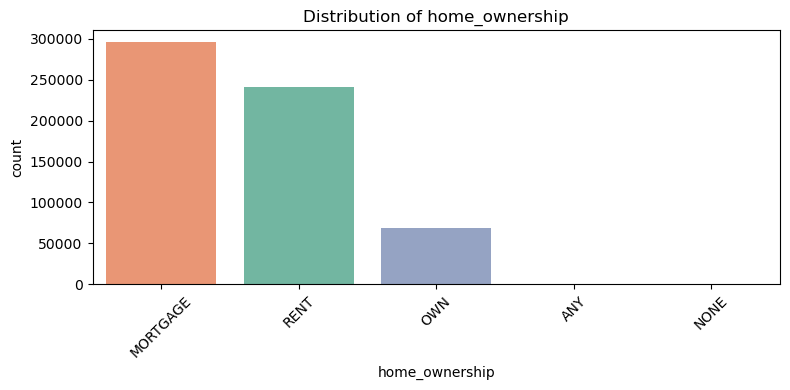

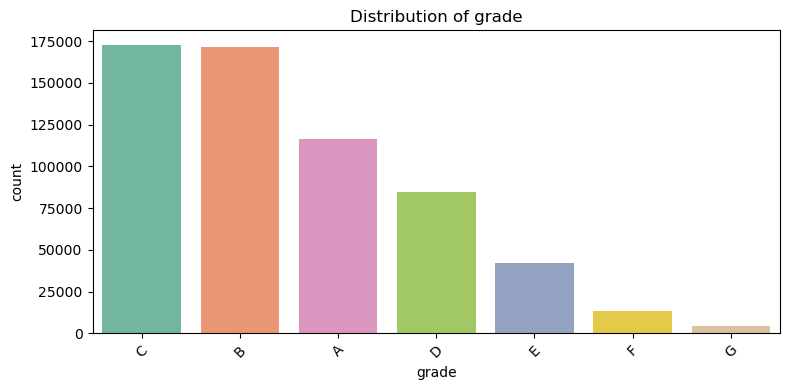

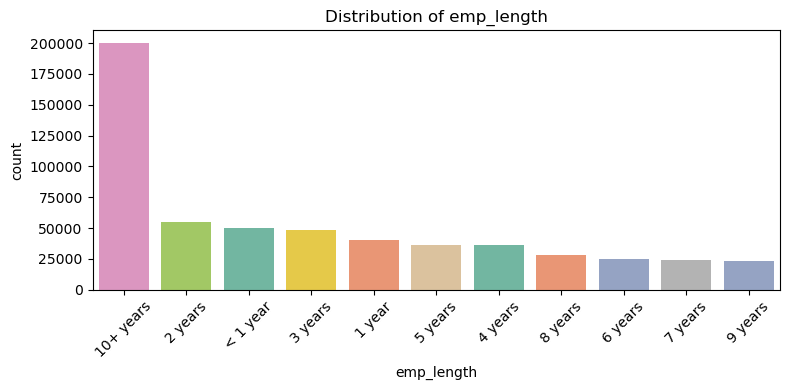

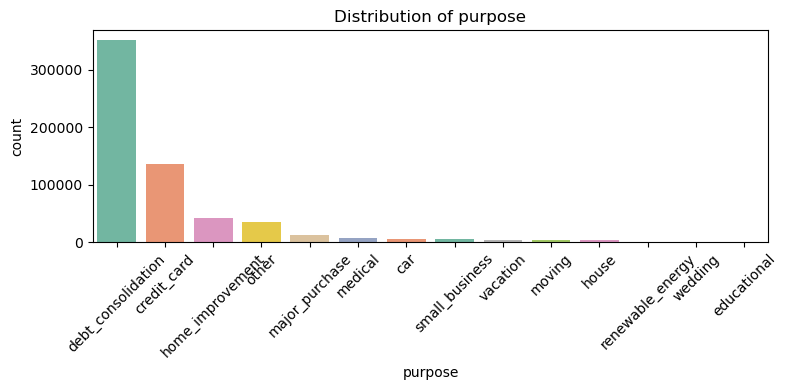

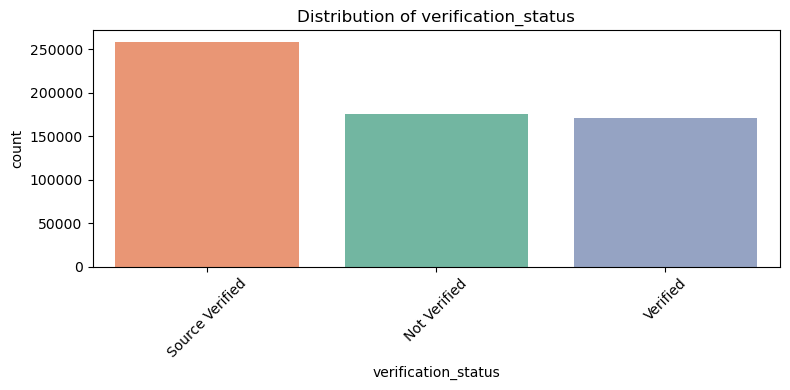

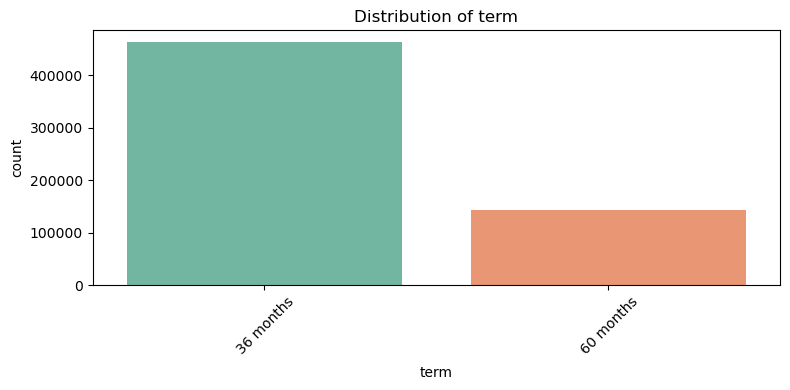

Grade-Level Loan Summary:
   % of Loans   int_rate   ret_OPT  default_%
A   19.184339   6.877237  3.689253   6.123802
B   28.356520  10.150223  4.479752  14.233120
C   28.562674  13.576124  4.829701  23.923868
D   14.029674  17.389625  5.001841  33.344323
E    6.990885  20.601166  5.192297  42.090215
F    2.179810  24.977874  5.493961  50.545620
G    0.696099  28.598315  5.473099  54.247746


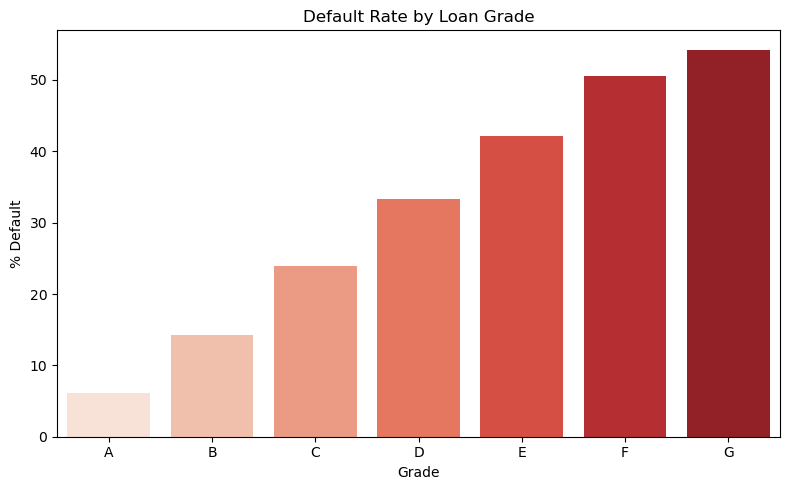

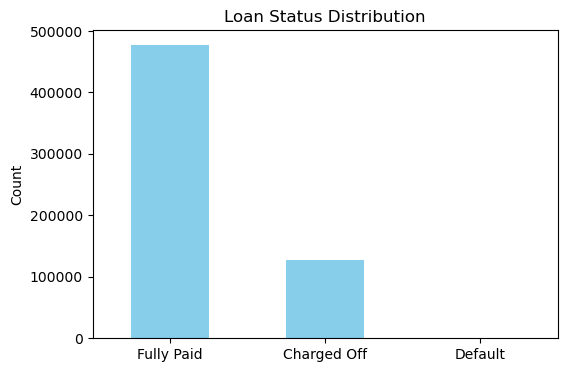

Summary Statistics:
                    count          mean           std      min         25%  \
loan_amnt        605374.0  14552.362506   8795.106114  1000.00   8000.0000   
funded_amnt      605374.0  14552.362506   8795.106114  1000.00   8000.0000   
installment      605374.0    439.151480    262.995589    14.01    248.4425   
annual_inc       605374.0  76879.932932  72778.816918    16.00  45712.7500   
dti              605374.0     18.969691     11.783039    -1.00     12.1900   
revol_bal        605374.0  16578.285790  23590.032714     0.00   5856.0000   
delinq_2yrs      605374.0      0.338577      0.920335     0.00      0.0000   
open_acc         605374.0     11.846685      5.676809     1.00      8.0000   
pub_rec          605374.0      0.239870      0.641496     0.00      0.0000   
fico_range_high  605374.0    699.438314     31.856039   664.00    674.0000   
fico_range_low   605374.0    695.438159     31.855308   660.00    670.0000   
int_rate         605374.0     12.698760     

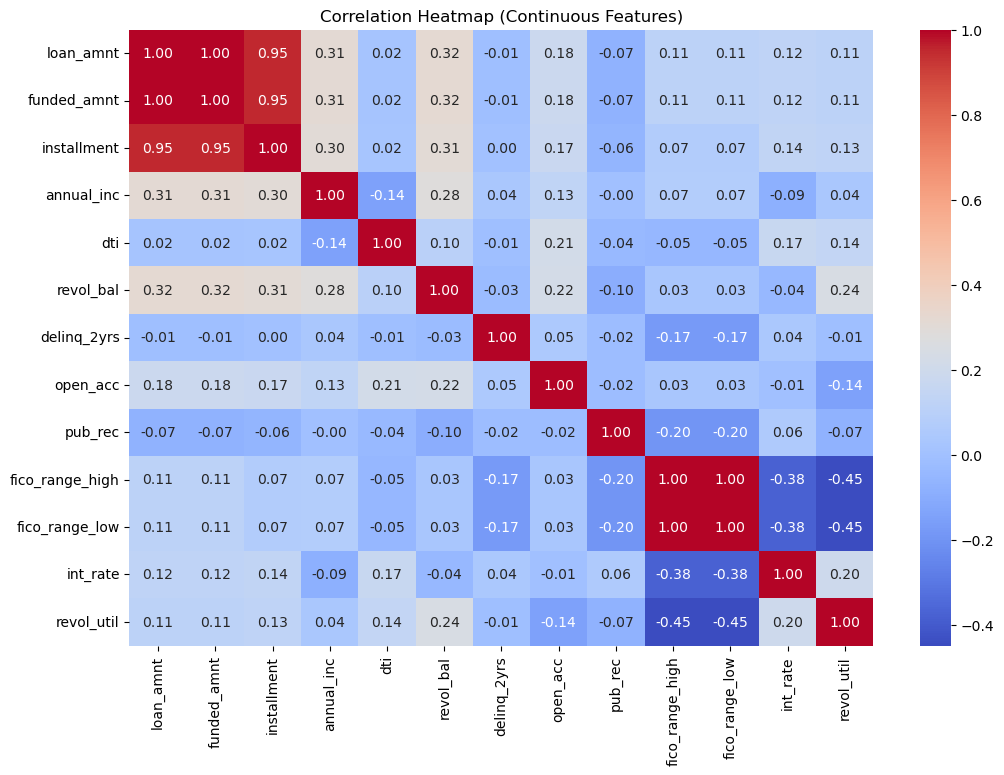

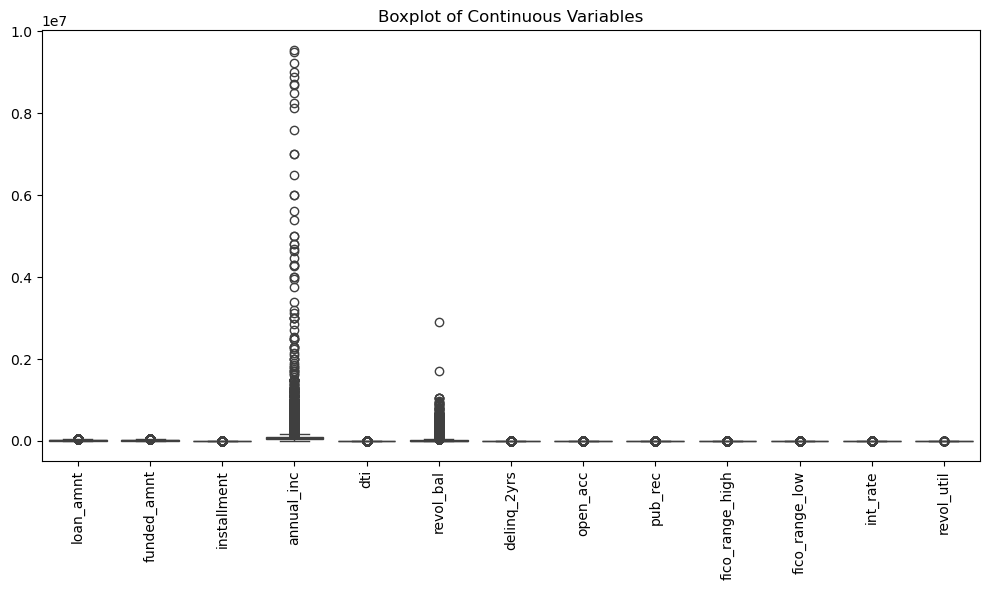

In [117]:
# =======================
# 1. Exploratory Data Analysis (EDA)
# =======================

# Basic structural overview

# Check for missing values (explicit check)
missing_values = data.isnull().sum()
missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing Value Summary:")
print(missing_summary)
print("Column Names:")
print(data.columns.tolist())

print("Dataset Sample:")
print(data.head())

print(f"Total rows: {len(data)}")
print(f"Total columns: {len(data.columns)}")

# Summary of loan amounts
print("Loan Amount Summary:")
print(data['loan_amnt'].describe())

# Countplots for Categorical Features
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue=col, data=data, order=data[col].value_counts().index, palette='Set2', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Grade-level summary statistics
# -----------------------------------

# Percentage of loans by grade
perc_by_grade = (data.grade.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and return_1 by grade
int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_OPT) * 100)

# Percentage of defaulted loans by grade
default_by_grade = data.groupby("grade").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
combined = pd.DataFrame(perc_by_grade)
combined.columns = ['% of Loans']
combined['int_rate'] = int_rate_by_grade
combined['ret_OPT'] = ret_by_grade_OPT
combined['default_%'] = default_by_grade

print("Grade-Level Loan Summary:")
print(combined)

# Bar plot of default rate by grade
plt.figure(figsize=(8,5))
sns.barplot(x=combined.index, y=combined['default_%'], hue=combined.index, palette='Reds', legend=False)
plt.title("Default Rate by Loan Grade")
plt.ylabel("% Default")
plt.xlabel("Grade")
plt.tight_layout()
plt.show()

# Target variable distribution
plt.figure(figsize=(6,4))
data['loan_status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Loan Status Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Summary stats
print("Summary Statistics:")
summary_stats = data[continuous_cols].describe().T
summary_stats['std'] = data[continuous_cols].std()
print(summary_stats)

# Missing values
missing = data.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing values:")
print(missing)

# Correlation matrix
corr_matrix = data[continuous_cols].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

# Boxplot for outlier visualization
plt.figure(figsize=(10,6))
sns.boxplot(data=data[continuous_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Continuous Variables")
plt.tight_layout()
plt.show()

In [118]:
# =======================
# 2. Data Preprocessing
# =======================

# Remove post-loan outcome variables to prevent data leakage
post_loan_cols = [
    'total_pymnt', 'recoveries', 'last_pymnt_d',
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc'
]
for col in post_loan_cols:
    if col in data.columns:
        data.drop(columns=col, inplace=True)
        if col in continuous_cols:
            continuous_cols.remove(col)

# Fill missing values: continuous with median, categorical with 'Unknown'
for col in continuous_cols:
    data[col] = data[col].fillna(data[col].median())

for col in categorical_cols:
    data[col] = data[col].fillna("Unknown")

# Drop rows with missing target only
data = data.dropna(subset=['loan_status'])

# Convert target variable to binary
# Define default as 'Charged Off' or 'Default'
data['target'] = data['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

# Ensure 'issue_d' & earliest_cr_line is in datetime format for accurate time-based feature creation
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')

# Create credit history length feature (in months)
data['cr_hist'] = ((data['issue_d'] - data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(float)
continuous_cols.append('cr_hist')

# One-hot encode categorical variables

# Make sure cr_hist is flat again
data['cr_hist'] = ((data['issue_d'] - data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(float)

# Recheck continuous cols
if 'cr_hist' not in continuous_cols:
    continuous_cols.append('cr_hist')

# Build X_cont carefully — enforce float dtype and flatten all
X_cont = pd.DataFrame({col: data[col].astype(float) for col in continuous_cols})

# Build categorical safely
X_cat = pd.get_dummies(data[categorical_cols], drop_first=True)

# Combine final feature matrix
X = pd.concat([X_cont, X_cat], axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Clean and flatten y
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()
y_train = y_train.values.ravel()

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()
y_test = y_test.values.ravel()

# Ensure clean column names
X_train.columns = X_train.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)

# Ensure numeric dtype
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Ensure target is a Series or 1D array
y_train = y_train.values.ravel() if hasattr(y_train, "values") else y_train
y_test = y_test.values.ravel() if hasattr(y_test, "values") else y_test

print(X_train.shape, X_train.dtypes.unique())
print(y_train.shape, type(y_train))

# Run this BEFORE model.fit()
for col in X_train.columns:
    try:
        _ = X_train[col].dtype
    except Exception as e:
        print(f"Column causing error: {col} → {type(X_train[col].iloc[0])} — {e}")

print(type(data['cr_hist'].iloc[0]))

(454030, 51) [dtype('float64')]
(454030,) <class 'numpy.ndarray'>
<class 'numpy.float64'>


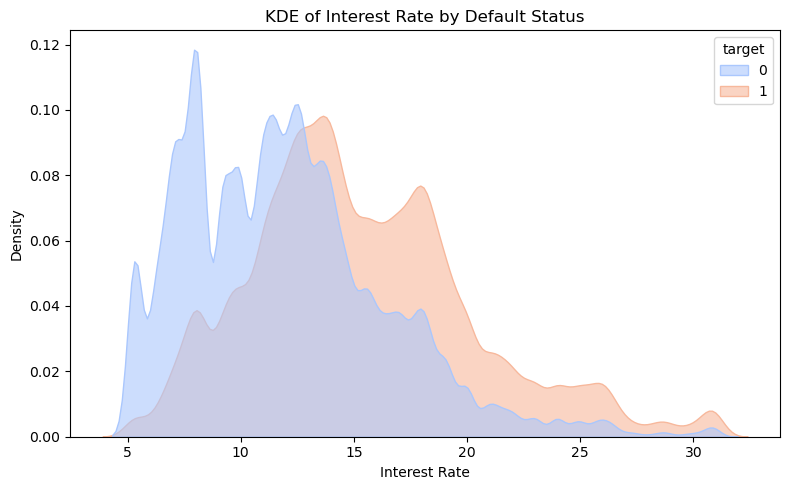

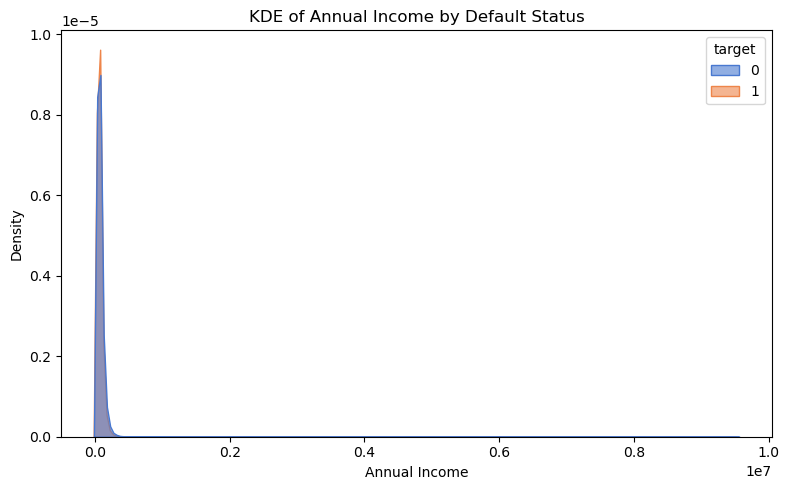

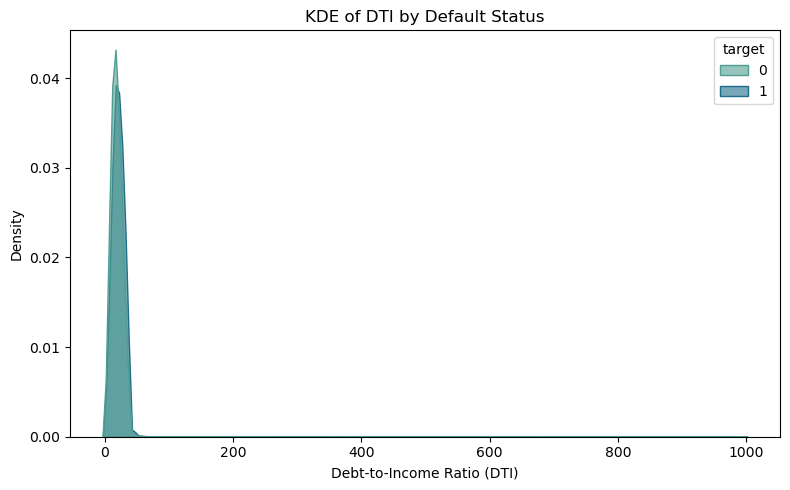

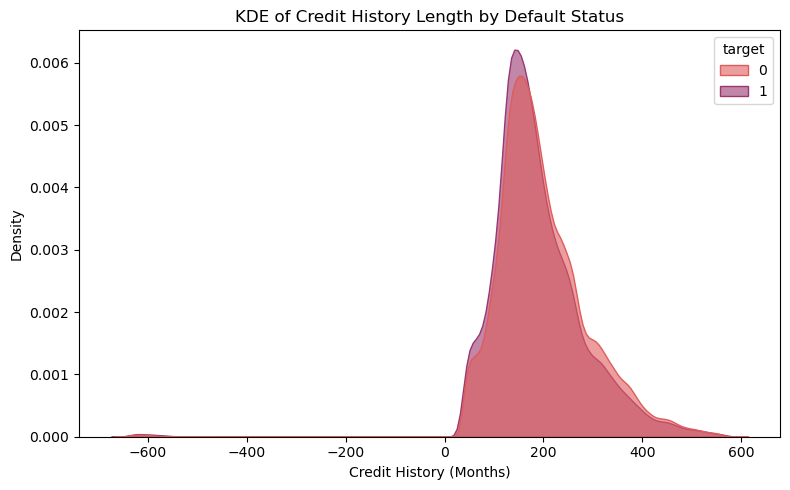

In [120]:
# =======================
# Kernel Density Estimate (KDE) Plot
# =======================

# KDE of interest rate by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='int_rate', hue='target', fill=True, common_norm=False, palette='coolwarm', alpha=0.6)
plt.title('KDE of Interest Rate by Default Status')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of annual income by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='annual_inc', hue='target', fill=True, common_norm=False, palette='muted', alpha=0.6)
plt.title('KDE of Annual Income by Default Status')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of DTI by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='dti', hue='target', fill=True, common_norm=False, palette='crest', alpha=0.6)
plt.title('KDE of DTI by Default Status')
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of credit history length by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='cr_hist', hue='target', fill=True, common_norm=False, palette='flare', alpha=0.6)
plt.title('KDE of Credit History Length by Default Status')
plt.xlabel('Credit History (Months)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

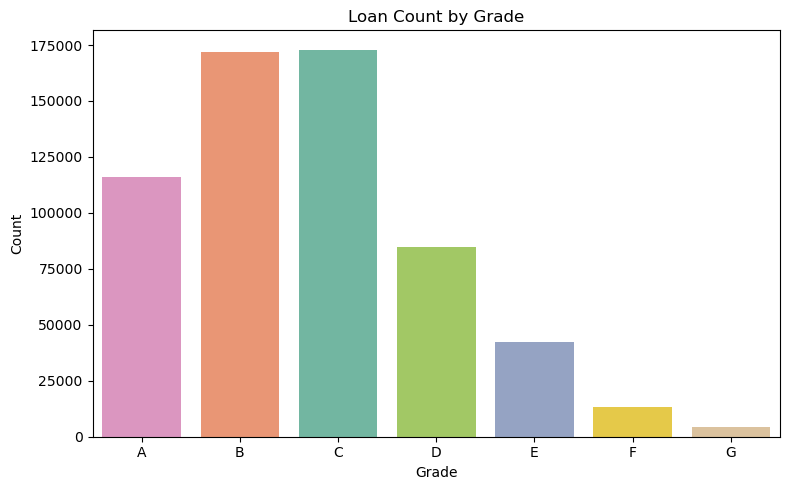

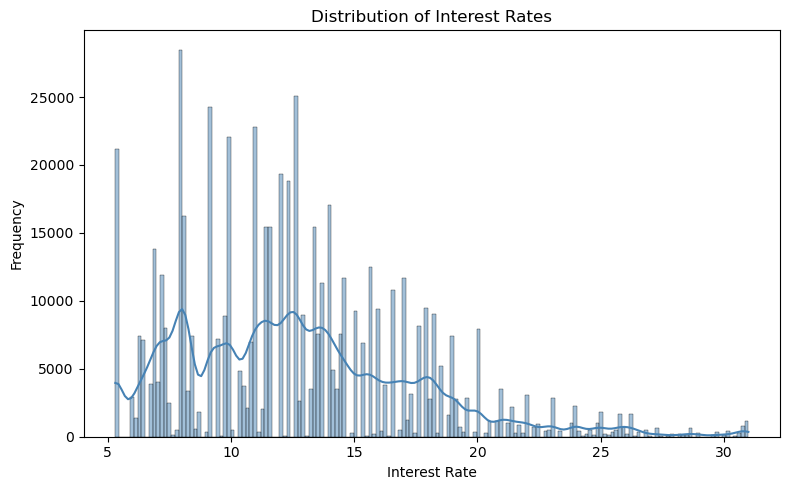

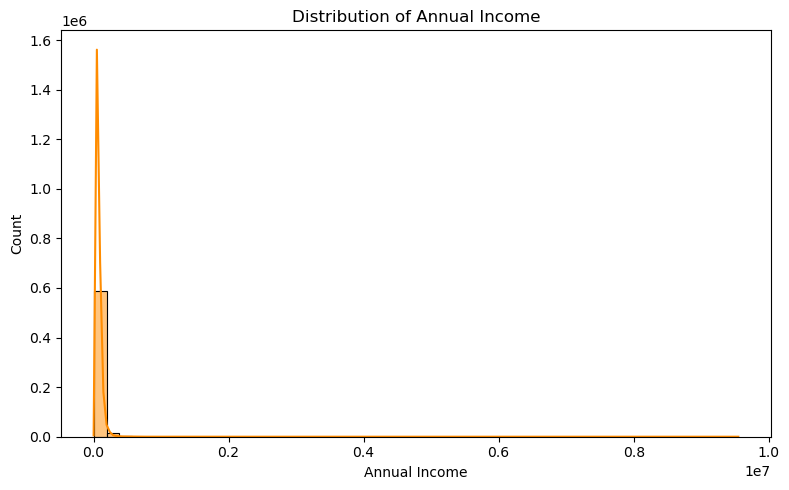

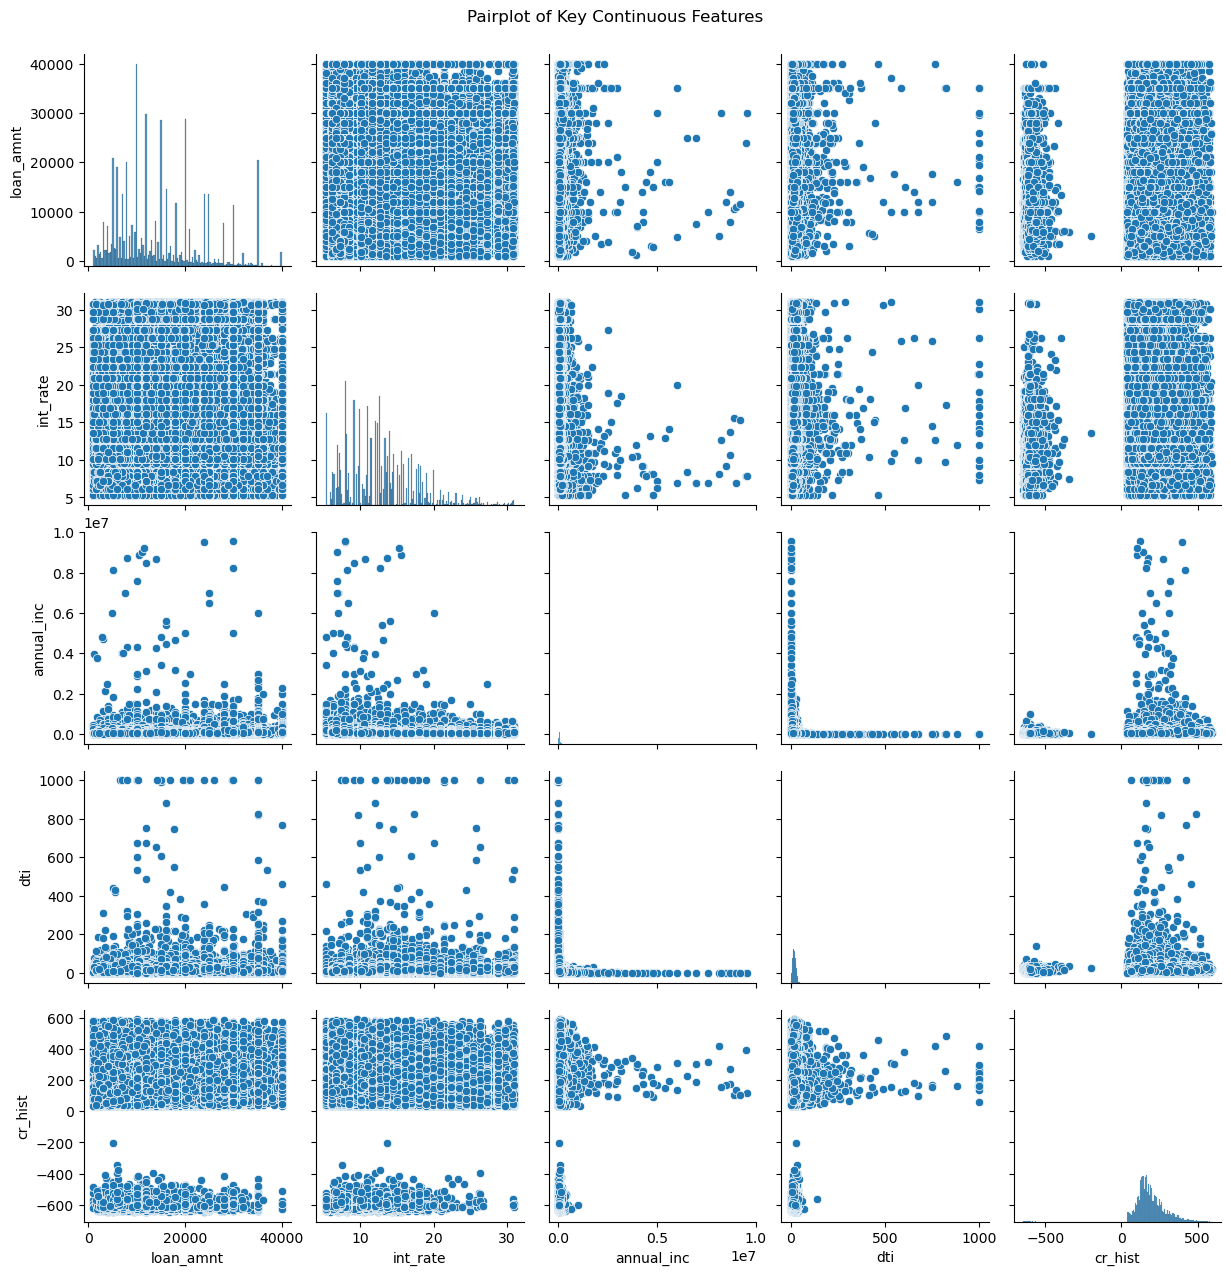

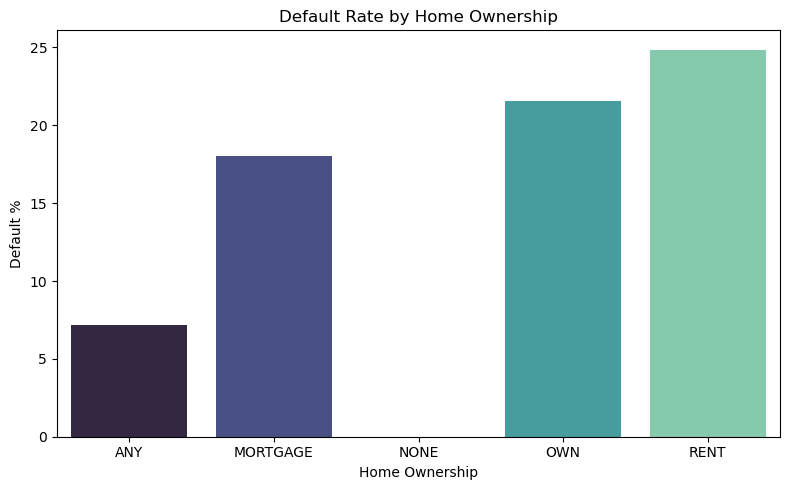

In [122]:
# =======================
# Additional Visual EDA
# =======================

# Countplot of loan grades
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='grade', hue='grade', order=sorted(data['grade'].unique()), palette='Set2', legend=False)
plt.title("Loan Count by Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram of Interest Rates
plt.figure(figsize=(8,5))
sns.histplot(data['int_rate'], kde=True, color='steelblue')
plt.title("Distribution of Interest Rates")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of Annual Income
plt.figure(figsize=(8,5))
sns.histplot(data['annual_inc'], bins=50, kde=True, color='darkorange')
plt.title("Distribution of Annual Income")
plt.xlabel("Annual Income")
plt.tight_layout()
plt.show()

# Pairplot of selected continuous features
pairplot_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'cr_hist']
sns.pairplot(data[pairplot_features].dropna())
plt.suptitle("Pairplot of Key Continuous Features", y=1.02)
plt.show()

# Bar plot: default rate by home ownership
plt.figure(figsize=(8,5))
default_by_home = data.groupby("home_ownership")["target"].mean() * 100
sns.barplot(x=default_by_home.index, y=default_by_home.values, hue=default_by_home.index, palette='mako', legend=False)
plt.title("Default Rate by Home Ownership")
plt.ylabel("Default %")
plt.xlabel("Home Ownership")
plt.tight_layout()
plt.show()

In [124]:
# =======================
# 3.1 Model Training: XGBoost (Baseline Model without Class Weights)
# =======================

from xgboost import XGBClassifier

baseline_model = XGBClassifier(
    random_state=42,
    n_estimators=100,       # default value
    max_depth=3,            # matches sklearn's default for GBM
    learning_rate=0.1,      # default
    eval_metric='logloss'     # basic eval metric
)

baseline_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [125]:
# =======================
# 3.2 Model Training: XGBoost (Baseline Model with Class Weights)
# =======================

from xgboost import XGBClassifier

# Compute class imbalance ratio for scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

weighted_model = XGBClassifier(
    random_state=42,
    n_estimators=100,       # consistent with baseline
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'   # prevents warning
)

weighted_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [126]:
# =======================
# 3.3 Model Training: XGBoost with Expanded Hyperparameter Tuning (with Class Weights)
# =======================

# Compute class imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200],           # more boosting rounds
    'learning_rate': [0.05, 0.1, 0.2],    # smaller for slower learning
    'max_depth': [3, 5, 7],               # deeper trees capture more interaction
    'subsample': [0.8, 1.0],              # subsample rows to reduce overfitting
    'colsample_bytree': [0.8, 1.0]        # subsample columns to reduce overfitting
}

# Base model setup
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
)

# Grid search setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Train with grid search
grid_search.fit(X_train, y_train)

# Output best model
print("Best parameters found:")
print(grid_search.best_params_)

# Assign best estimator
model = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [127]:
# -----------------------
# 4. Model Evaluation and Validation
# -----------------------

# -----------------------
# 4.1 Three Model Comparison
# -----------------------

# 1. Model 1: Baseline XGBoost (no weights, no tuning)
model1 = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
)
model1.fit(X_train, y_train)
probs1 = model1.predict_proba(X_test)[:, 1]
preds1 = (probs1 >= 0.5).astype(int)

# 2. Model 2: Weighted XGBoost (class weights, no tuning)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model2 = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
)
model2.fit(X_train, y_train)
probs2 = model2.predict_proba(X_test)[:, 1]
preds2 = (probs2 >= 0.5).astype(int)

# 3. Model 3: Tuned XGBoost (already trained as `model` from GridSearchCV)
probs3 = model.predict_proba(X_test)[:, 1]
preds3 = (probs3 >= 0.5).astype(int)

# -----------------------
# Print Comparison Summary
# -----------------------

print("=== Model 1: Baseline XGBoost (No Weights, No Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds1):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds1):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs1):.4f}")
print()

print("=== Model 2: Weighted XGBoost (Class Weights, No Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds2):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds2):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs2):.4f}")
print()

print("=== Model 3: Tuned XGBoost (Weights + Hyperparameter Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds3):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds3):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs3):.4f}")


=== Model 1: Baseline XGBoost (No Weights, No Tuning) ===
Accuracy:  0.7947
F1 Score:  0.2159
ROC AUC:   0.7301

=== Model 2: Weighted XGBoost (Class Weights, No Tuning) ===
Accuracy:  0.6629
F1 Score:  0.4566
ROC AUC:   0.7288

=== Model 3: Tuned XGBoost (Weights + Hyperparameter Tuning) ===
Accuracy:  0.6607
F1 Score:  0.4592
ROC AUC:   0.7317


Top 15 Important Features Based on Gain:
                         Feature  Importance
0                       int_rate  646.862549
1                        grade_B  388.430908
2                term_ 60 months  283.627441
3        home_ownership_MORTGAGE  129.817184
4            home_ownership_RENT  123.398315
5             emp_length_Unknown   95.669930
6                        grade_C   87.020782
7                        grade_E   54.021946
8                fico_range_high   50.375046
9                        grade_D   47.630489
10                           dti   42.276058
11                     loan_amnt   35.160843
12  verification_status_Verified   34.481869
13        purpose_small_business   34.012028
14                   installment   32.706047


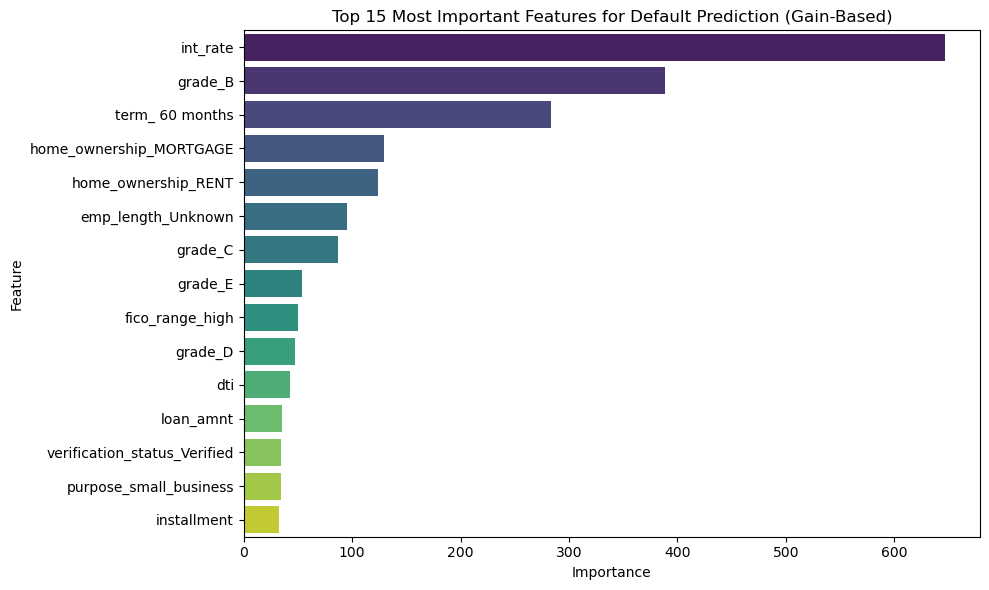

In [131]:
# -----------------------
# 4.2 Feature Importance Summary (Using Gain)
# -----------------------

# Get booster and calculate gain-based feature importance
booster = model.get_booster()
feat_imp_gain = pd.DataFrame.from_dict(
    booster.get_score(importance_type='gain'), 
    orient='index', 
    columns=['Importance']
).sort_values(by='Importance', ascending=False)

# Reset index to have 'Feature' as a column
feat_imp_gain = feat_imp_gain.reset_index().rename(columns={'index': 'Feature'})

print("Top 15 Important Features Based on Gain:")
print(feat_imp_gain.head(15))

# Plotting
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp_gain.head(15), palette='viridis', legend=False)
plt.title("Top 15 Most Important Features for Default Prediction (Gain-Based)")
plt.tight_layout()
plt.show()


In [132]:
# -----------------------
# 4.3 Overfitting Checks
# -----------------------
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Train set predictions
baseline_train_probs = baseline_model.predict_proba(X_train)[:, 1]
baseline_train_preds = (baseline_train_probs >= 0.5).astype(int)

tuned_train_probs = model.predict_proba(X_train)[:, 1]
tuned_train_preds = (tuned_train_probs >= 0.5).astype(int)

# Test set predictions
baseline_probs = baseline_model.predict_proba(X_test)[:, 1]
y_probs = model.predict_proba(X_test)[:, 1]  # for tuned model

# CV performance on training data
cv_baseline_auc = cross_val_score(baseline_model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
cv_tuned_auc = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)

# Output
print("=== Overfitting Check ===")
print("Baseline Model:")
print(f"Train ROC AUC: {roc_auc_score(y_train, baseline_train_probs):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, baseline_probs):.4f}")
print(f"3-Fold CV ROC AUC (Train): {cv_baseline_auc.mean():.4f} ± {cv_baseline_auc.std():.4f}")

print("Tuned Model:")
print(f"Train ROC AUC: {roc_auc_score(y_train, tuned_train_probs):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_probs):.4f}")
print(f"3-Fold CV ROC AUC (Train): {cv_tuned_auc.mean():.4f} ± {cv_tuned_auc.std():.4f}")

=== Overfitting Check ===
Baseline Model:
Train ROC AUC: 0.7285
Test ROC AUC: 0.7278
3-Fold CV ROC AUC (Train): 0.7262 ± 0.0010
Tuned Model:
Train ROC AUC: 0.7444
Test ROC AUC: 0.7317
3-Fold CV ROC AUC (Train): 0.7295 ± 0.0011


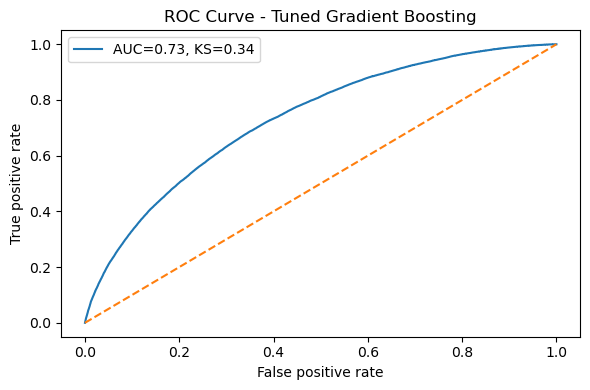

In [133]:
# ------------------------------------------
# 4.4 Classification Report - ROC Curve/KS Plots
# -----------------------------------------

# ROC Curve and KS Statistic for Tuned Model
predicted_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs)
roc_auc = roc_auc_score(y_test, predicted_probs)
ks = np.max(tpr - fpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}, KS={ks:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Tuned Gradient Boosting')
plt.legend()
plt.tight_layout()
plt.show()

Running learning curve analysis (this may take a while)...
Learning curve took 0.95 minutes


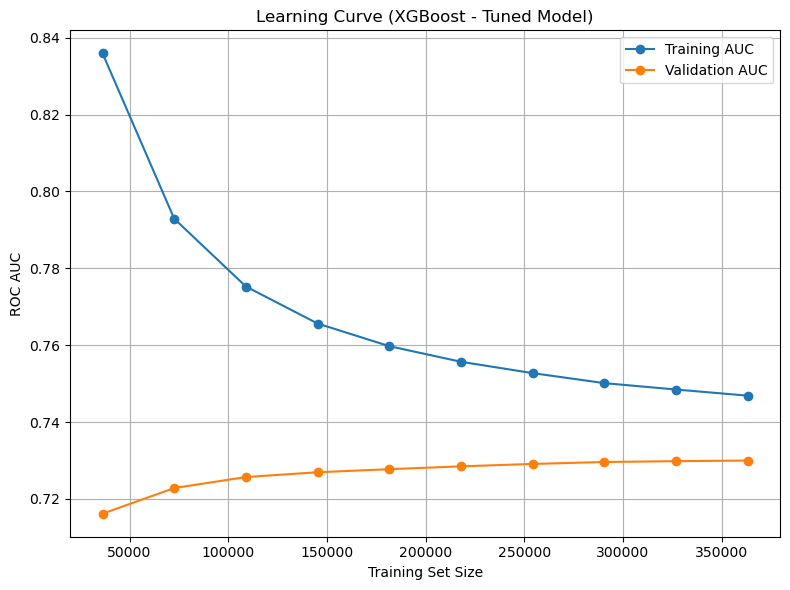

In [134]:
# -----------------------
# 4.5 Learning Curve Analysis
# -----------------------
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

print("Running learning curve analysis (this may take a while)...")
start = time.time()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

end = time.time()
print(f"Learning curve took {(end - start)/60:.2f} minutes")

# Calculate means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training AUC')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation AUC')
plt.title('Learning Curve (XGBoost - Tuned Model)')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


Actual default rate in test set: 21.14%
Predicted default rate (threshold = 0.5): 41.61%


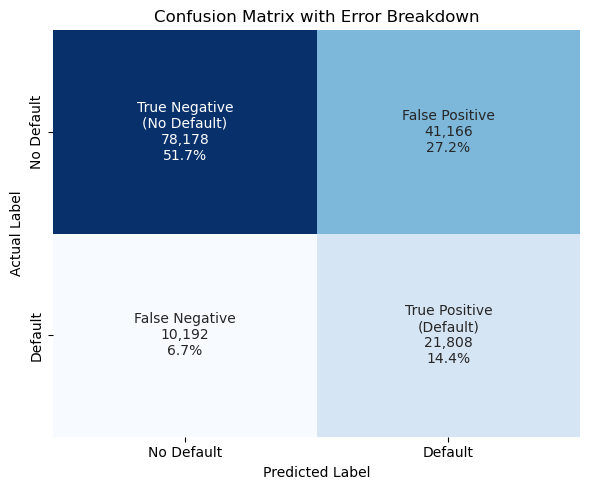

In [135]:
# -----------------------
# 4.6 Actual Default Rate Comparison and Confusion Matrix
# -----------------------

from sklearn.metrics import confusion_matrix

# Predict probabilities and binary outcomes at threshold = 0.5
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_probs >= 0.5).astype(int)

# Compare actual default rate vs predicted default rate
actual_default_rate = y_test.mean()
predicted_default_rate = y_pred_default.mean()

print("Actual default rate in test set: {:.2f}%".format(actual_default_rate * 100))
print("Predicted default rate (threshold = 0.5): {:.2f}%".format(predicted_default_rate * 100))

# Enhanced Confusion Matrix with Error Breakdown
conf_matrix = confusion_matrix(y_test, y_pred_default)
labels = ['True Negative\n(No Default)', 'False Positive',
          'False Negative', 'True Positive\n(Default)']
counts = [f"{value:,}" for value in conf_matrix.flatten()]
percentages = [f"{value:.1%}" for value in conf_matrix.flatten() / np.sum(conf_matrix)]

# Combine into labels for display
matrix_labels = [f"{label}\n{count}\n{percent}" for label, count, percent in zip(labels, counts, percentages)]
matrix_labels = np.array(matrix_labels).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=matrix_labels, fmt="", cmap="Blues", cbar=False,
            xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix with Error Breakdown")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

In [144]:
# -----------------------
# 4.7 Additional Evaluation Metrics (Precision, Recall, F1, ROC, KS)
# -----------------------
from sklearn.metrics import precision_score, recall_score, f1_score

# Predict labels and probabilities
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# Classification metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

# KS Statistic (max difference between TPR and FPR)
fpr, tpr, _ = roc_curve(y_test, y_probs)
ks = np.max(tpr - fpr)

# Print all metrics
print("=== Evaluation Metrics (Threshold = 0.5) ===")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC AUC Score:  {auc:.4f}")
print(f"KS Statistic:   {ks:.4f}")


=== Evaluation Metrics (Threshold = 0.5) ===
Precision:      0.3463
Recall:         0.6815
F1 Score:       0.4592
ROC AUC Score:  0.7317
KS Statistic:   0.3373


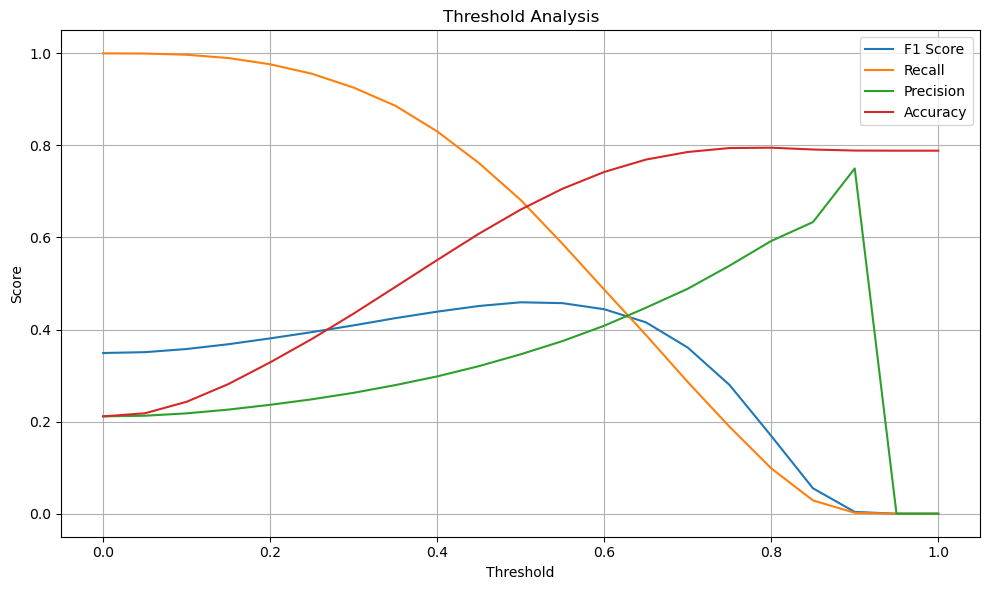

Optimal Threshold by F1 Score: 0.50
Threshold = Optimal F1 Threshold: 0.50
              precision    recall  f1-score   support

           0       0.88      0.66      0.75    119344
           1       0.35      0.68      0.46     32000

    accuracy                           0.66    151344
   macro avg       0.62      0.67      0.61    151344
weighted avg       0.77      0.66      0.69    151344



In [146]:
# =======================
# 5.1 Optimal Threshold Tuning
# =======================

from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, accuracy_score, classification_report

thresholds = np.arange(0.0, 1.05, 0.05)
f1_scores = []
recalls = []
precisions = []
accuracies = []

#Need to account for division by zero, since our model can predict zero defaults
for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))
    precisions.append(precision_score(y_test, preds, zero_division=0))
    accuracies.append(accuracy_score(y_test, preds))

# Plotting threshold vs F1/Recall/Precision
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Analysis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold by F1 Score
optimal_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold by F1 Score: {optimal_thresh:.2f}")

# Apply optimal threshold
threshold = optimal_thresh
y_pred_thresh = (y_probs >= threshold).astype(int)

print(f"Threshold = Optimal F1 Threshold: {threshold:.2f}")
print(classification_report(y_test, y_pred_thresh, zero_division=0))


In [148]:
# -----------------------
# 5.2 Threshold Sensitivity Analysis (Low, Default, High)
# -----------------------
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

thresholds_to_test = [0.3, 0.5, 0.7]

y_probs = model.predict_proba(X_test)[:, 1]

for thresh in thresholds_to_test:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_probs)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    ks = np.max(tpr - fpr)

    print(f"\n=== Evaluation Metrics (Threshold = {thresh:.2f}) ===")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    print(f"ROC AUC Score:  {auc:.4f}")
    print(f"KS Statistic:   {ks:.4f}")

#Trade-Off between Precision & Recall. For minimising defaults, better to focus on catching as many defaulters as possible ==> 
#Prioritise Recall ==> Lower Thresholds


=== Evaluation Metrics (Threshold = 0.30) ===
Precision:      0.2626
Recall:         0.9256
F1 Score:       0.4091
ROC AUC Score:  0.7317
KS Statistic:   0.3373

=== Evaluation Metrics (Threshold = 0.50) ===
Precision:      0.3463
Recall:         0.6815
F1 Score:       0.4592
ROC AUC Score:  0.7317
KS Statistic:   0.3373

=== Evaluation Metrics (Threshold = 0.70) ===
Precision:      0.4886
Recall:         0.2862
F1 Score:       0.3610
ROC AUC Score:  0.7317
KS Statistic:   0.3373


Selected Low-Risk Loan Portfolio Summary (Threshold < 0.2):
Total loans selected: 19277
Observed default rate in selected portfolio: 3.94%
Top N Loan Portfolio Summary:
Top 300 loans selected
Observed default rate: 1.33%
Top 10% Loan Portfolio Summary:
Loans selected: 15134
Observed default rate: 3.36%


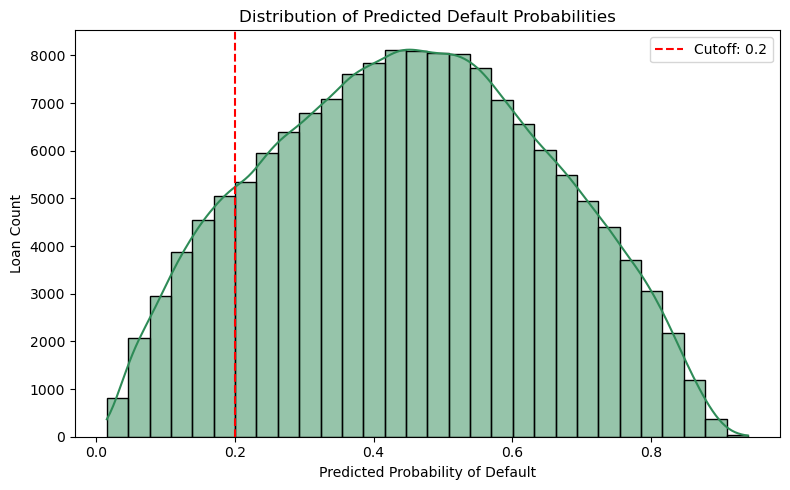

In [150]:
# =======================
# 6.1 Loan Portfolio Construction (Minimising Default - Option 1: Threshold-Based)
# =======================

# Construct a portfolio of loans predicted to have low risk of default
# Sort by predicted probability of default (ascending)
portfolio = X_test.copy()
portfolio['prob_default'] = y_probs
portfolio['actual_default'] = y_test

# Define cutoff for low-risk (e.g. probability of default < 0.2)
portfolio_selected = portfolio[portfolio['prob_default'] < 0.2]

# Portfolio summary
print("Selected Low-Risk Loan Portfolio Summary (Threshold < 0.2):")
print(f"Total loans selected: {len(portfolio_selected)}")
print(f"Observed default rate in selected portfolio: {portfolio_selected['actual_default'].mean() * 100:.2f}%")

# Option 2: Top N safest loans
N = 300
portfolio_top_n = portfolio.sort_values(by='prob_default').head(N)
print("Top N Loan Portfolio Summary:")
print(f"Top {N} loans selected")
print(f"Observed default rate: {portfolio_top_n['actual_default'].mean() * 100:.2f}%")

# Option 3: Top X% safest loans
top_percent = 0.10
n_select = int(len(portfolio) * top_percent)
portfolio_top_pct = portfolio.sort_values(by='prob_default').head(n_select)
print("Top 10% Loan Portfolio Summary:")
print(f"Loans selected: {n_select}")
print(f"Observed default rate: {portfolio_top_pct['actual_default'].mean() * 100:.2f}%")

# Distribution of predicted default probabilities
plt.figure(figsize=(8,5))
sns.histplot(portfolio['prob_default'], bins=30, kde=True, color='seagreen')
plt.axvline(0.2, color='red', linestyle='--', label='Cutoff: 0.2')
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Loan Count")
plt.legend()
plt.tight_layout()
plt.show()

In [152]:
# =======================
# 6.2 Top Risky and Safest Loans Based on Predicted Default Probabilities
# =======================

# Top 10 most risky loans (highest probability of default)
print("\nTop 10 Most Risky Loans (Highest Predicted Default Probabilities):")
print(
    portfolio.sort_values(by='prob_default', ascending=False)
    [["loan_amnt", "int_rate", "prob_default"]]
    .head(10)
)

# Top 10 safest loans (lowest probability of default)
print("\nTop 10 Safest Loans (Lowest Predicted Default Probabilities):")
print(
    portfolio.sort_values(by='prob_default', ascending=True)
    [["loan_amnt", "int_rate", "prob_default"]]
    .head(10)
)



Top 10 Most Risky Loans (Highest Predicted Default Probabilities):
        loan_amnt  int_rate  prob_default
633824    21000.0     23.99      0.940019
478694    16450.0     22.45      0.938678
83141     35000.0     25.99      0.936592
809794    15000.0     30.17      0.929183
522720    11000.0     28.99      0.926036
793837    20000.0     30.65      0.925571
490180    30000.0     27.34      0.924416
97428     10850.0     21.67      0.924321
477900    19850.0     28.67      0.924177
551162    12950.0     24.11      0.923394

Top 10 Safest Loans (Lowest Predicted Default Probabilities):
         loan_amnt  int_rate  prob_default
267989     25400.0      6.89      0.015087
362583      1500.0      6.24      0.015881
799903      1000.0      5.32      0.017327
354998      7200.0      5.32      0.017655
828584      4600.0      5.32      0.018093
953074     11000.0      6.11      0.018250
465220      4000.0      5.32      0.018390
468809      5000.0      5.32      0.018623
24638       5500.0  

### 11.5.3 Investment Strategy 2: Minimising Default Model 2 (ANN)

In [ ]:
#### DATA PREPROCESSING
#### ---------------------------------
df = data.copy()

# feature engineer for earliest_cr_line and issue_d
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%Y-%m')
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%Y-%m')
df['credit_history_months'] = ((df['issue_d'] - df['earliest_cr_line']) / pd.Timedelta(days=30)).astype(int)

# drop leaky / duplicate columns
df.drop(columns=['loan_status', 'id', 'issue_d', 'last_pymnt_d', 'earliest_cr_line', 'term', 'funded_amnt', 'fico_range_low', 'ret_PESS', 'ret_OPT',
    'ret_INTa', 'ret_INTb', 'ret_INTc', 'total_pymnt', 'recoveries'], inplace=True)

# get lists of categorical and numerical columns
target_col = 'loan_status_binary'
cat_cols = ['grade', 'term_num', 'emp_length', 'home_ownership', 'verification_status', 'purpose']
num_cols = [col for col in df.columns if col not in cat_cols + [target_col]]

# create dummy variables for categorical features
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# split data into features and target
x_df = df.drop(columns=[target_col])
y = df[target_col]

# split data into train and test sets
default_seed = 49  # for reproducibility
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.1, random_state=default_seed)

# separate out return column
x_train = x_train.drop(columns=['raw_roi'])
x_test_return = x_test['raw_roi']
x_test = x_test.drop(columns=['raw_roi'])

# scale data
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


#### MODEL TRAINING
#### ---------------------------------

# compute class weights
y_train_flat = np.array(y_train).flatten()
# Get all unique labels in y_train
unique_classes = np.unique(y_train_flat)
# Compute class weights correctly
class_weights = dict(zip(
    unique_classes,
    compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train_flat)
))

# get number of features
n_features, n_outputs = x_train.shape[1], 1

# function for building model (with hyperparameter tuning)
def build_model(hp):
    model = Sequential()

    # hidden layer tuning
    model.add(Dense(hp.Int('units', min_value=1, max_value=100), activation='relu', input_shape=(n_features,)))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC()])
    return model

# Setup EarlyStopping and ReduceLROnPlateau
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,          # Reduce LR by this factor
    patience=2,
    min_lr=1e-6
)

# Use RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_auc',
    max_trials=15,  # number of different hyperparam combinations to try
    executions_per_trial=1,
    directory='ann-default',
    project_name='final-model'
)

# Search over the data
tuner.search(x_train, y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1, class_weight=class_weights, callbacks=[early_stopping, reduce_lr])

# Print the best model configuration
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best number of units: {best_hps.get('units')}")

# Get the best model from the tuner
best_model = tuner.get_best_models(num_models=1)[0]
# Evaluate on test data or make predictions
loss, accuracy, precision, recall, auc = best_model.evaluate(x_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")
print(f"Test precision: {precision:.4f}")
print(f"Test recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

#### PLOT TRAINING HISTORY
#### ---------------------------------

history = best_model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#### THRESHOLD SELECTION
#### ---------------------------------

# Step 1: Get predicted probabilities (not class labels)
y_probs = best_model.predict(x_test).flatten()

# Step 2: Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Align lengths — trim first element off precision/recall
precisions = precisions[1:]
recalls = recalls[1:]

# Step 3: Set your recall constraint
recall_threshold = 0.80
# precision_threshold = 0.40

# Step 4: Filter thresholds
valid = (recalls >= recall_threshold) # & (precisions >= precision_threshold)

# Step 5: Among those, find the threshold with highest precision
if valid.any():
    best_idx = np.argmax(precisions[valid])
    best_threshold = thresholds[valid][best_idx]
    best_precision = precisions[valid][best_idx]
    best_recall = recalls[valid][best_idx]

    print(f"Best threshold for recall ≥ {recall_threshold*100:.0f}%:")
    print(f"  Threshold: {best_threshold:.3f}")
    print(f"  Precision: {best_precision:.3f}")
    print(f"  Recall:    {best_recall:.3f}")
else:
    print(f"No threshold found where recall ≥ {recall_threshold*100:.0f}%")


#### PRECISION-RECALL CURVE
# Predict probabilities
y_probs = best_model.predict(x_test).flatten()

# Get precision, recall, thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)
avg_precision = average_precision_score(y_test, y_probs)

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label=f'PR Curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend()

# Optional: Mark a chosen threshold
# (Assumes you've already found best_threshold using previous code)
chosen_threshold = 0.45  # replace with your selected value
# Find closest threshold index
thresholds = thresholds  # already returned by precision_recall_curve
recalls = recalls[1:]    # align lengths
precisions = precisions[1:]
idx = np.argmin(np.abs(thresholds - chosen_threshold))

plt.scatter(recalls[idx], precisions[idx], color='red', label=f'Threshold = {chosen_threshold:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

#### ROC CURVE
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### FINAL MODEL EVALUATION
threshold = 0.45
y_pred = (y_probs >= threshold).astype(int)

print(f"Threshold: {threshold:.2f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred):.3f}")
print(f"AUC      : {auc_score:.3f}")

#### FEATURE IMPORTANCE
#### ---------------------------------
x_columns = ['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'open_acc', 'pub_rec', 'fico_range_high', 'revol_bal',
       'revol_util', 'loan_length', 'credit_history_months',
       'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'term_num_60', 'emp_length_10+ years', 'emp_length_2 years',
       'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years',
       'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years',
       'emp_length_9 years', 'emp_length_< 1 year', 'home_ownership_MORTGAGE',
       'home_ownership_NONE', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding']

# Define a wrapper (assuming you have a build_model function)
model_sklearn = KerasClassifier(build_fn=build_model_wrapper, epochs=10, verbose=0)
model_sklearn.fit(x_train, y_train)

# Compute permutation importances (on a small subset to speed up)
result = permutation_importance(model_sklearn, x_test[:1000], y_test[:1000], n_repeats=5, random_state=42)

# Show top importances
importances = pd.Series(result.importances_mean, index=x_columns)  # set your feature_names list
importances.sort_values(ascending=False).head(10).plot(kind='barh', title='Top Feature Importances', figsize=(8, 6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
#### PORTFOLIO CONSTRUCTION
#### ---------------------------------

# Sort by predicted probability of default (ascending)
portfolio = x_test.copy()
portfolio = pd.DataFrame(portfolio, columns=x_columns)
y_probs = best_model.predict(x_test).flatten()
portfolio['prob_default'] = y_probs# [:, 0]
portfolio['actual_default'] = y_test
portfolio['raw_roi'] = x_test_return

# Define cutoff for low-risk
portfolio_selected = portfolio[portfolio['prob_default'] < 0.45]

# Portfolio summary
print("Selected Low-Risk Loan Portfolio Summary (Threshold < 0.45):")
print(f"Total loans selected: {len(portfolio_selected)}")
print(f"Observed default rate in selected portfolio: {portfolio_selected['actual_default'].mean() * 100:.2f}%")

# Option 2: Top N safest loans
for n in [300, 500, 1000]:
    portfolio_top_n = portfolio.sort_values(by='prob_default').head(n)
    print("Top N Loan Portfolio Summary:")
    print(f"Top {n} loans selected")
    print(f"Observed default rate: {portfolio_top_n['actual_default'].mean() * 100:.2f}%")
    print(f"Average ROI: {portfolio_top_n['raw_roi'].mean() * 100:.2f}%")

plt.figure(figsize=(8,5))
sns.histplot(portfolio['prob_default'], bins=30, kde=True, color='seagreen')
plt.axvline(0.4, color='red', linestyle='--', label='Cutoff: 0.4')
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Loan Count")
plt.legend()
plt.tight_layout()
plt.show()


### 11.6 Experiments and Results: Portfolio Analysis

Code used to create:
- High-Return Loan Portfolio Analysis can be found in 11.4.2 (near the end)
- Low-Risk Loan Portfolio Anaylsis can be found in 11.5.2 (at the very bottom)